In [1]:
# author:     Yike Xie
# date:       28/09/21
# content:    make figures according to draft for paper, 

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import * 

In [5]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/pilots/') #enter the YK_util file directory
import YK_util, optimized_pair_comparison
from YK_util import *
from optimized_pair_comparison import *

save_fdn = '/home/yike/phd/dengue/figures/paper_figure/all_figures/'

In [7]:
#initiate the dataset, select monocytes in kids only
path = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid) # log1p=2
adata_kid = removegenes(adata_kid)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
adata_adult = subsetdata(adata, platform='plate')
adata_adult = normalizedata(adata_adult) # log1p=2
adata_adult = removegenes(adata_adult)

# Box and whisker plots (25–75 percentile) of percentages of cell subsets of total PBMC (per patient)

In [9]:
# csts = adata_kid.obs['cell_subtype_2'].astype('category').cat.categories.tolist()
# csts.remove('doublets')
csts = [
 'Naive_B_cells',
 'Memory_B_cells',
 'NK',
 'CD4_T_cells',
 'CD8_T_cells',
 'NKT',
 'Classical_monocytes',
 'non_classical_monocytes',
 'Macrophages',
 'IgA',
 'IgG1_proliferate',
 'IgG1',
 'IgG1_IgG2',
 'IgM',
 'pDCs',
 'cDC1',
 'cDC2',
 'cDC_IFN',
 ]

cds = ['Healthy', 'dengue', 'DWS', 'S_dengue']
IDs = {cd: list(adata_kid[adata_kid.obs['Condition'] == cd].obs['ID'].astype('category').cat.categories) for cd in cds}

df = pd.DataFrame()
fra_ct, fra_ID, cd, cst, patient = [], [], [], [], [], 

for csti in csts:
    adata_cst = adata_kid[adata_kid.obs['cell_subtype_2'] == csti]
    ct = adata_cst.obs['cell_type'].unique()[0]

    for cdi, ID in IDs.items():
        for IDi in ID:
            cell_n = adata_cst[adata_cst.obs['ID'] == IDi].obs.shape[0]
            
            total_ID = adata_kid[(adata_kid.obs['ID'] == IDi) & (adata_kid.obs['cell_type'] != 'T_cells')].obs.shape[0]
            fra_ID.append(cell_n / total_ID)
            
            total_ct = adata_kid[(adata_kid.obs['ID'] == IDi) & (adata_kid.obs['cell_type'] == ct)].obs.shape[0]
            fra_ct.append(cell_n / total_ct)

            cd.append(cdi)
            cst.append(csti)
            patient.append(IDi)

df['cst'] = cst
df['condition'] = cd
df['ID'] = patient
df['fra_ID'] = fra_ID
df['fra_ct'] = fra_ct
df.set_index('cst', inplace=True)

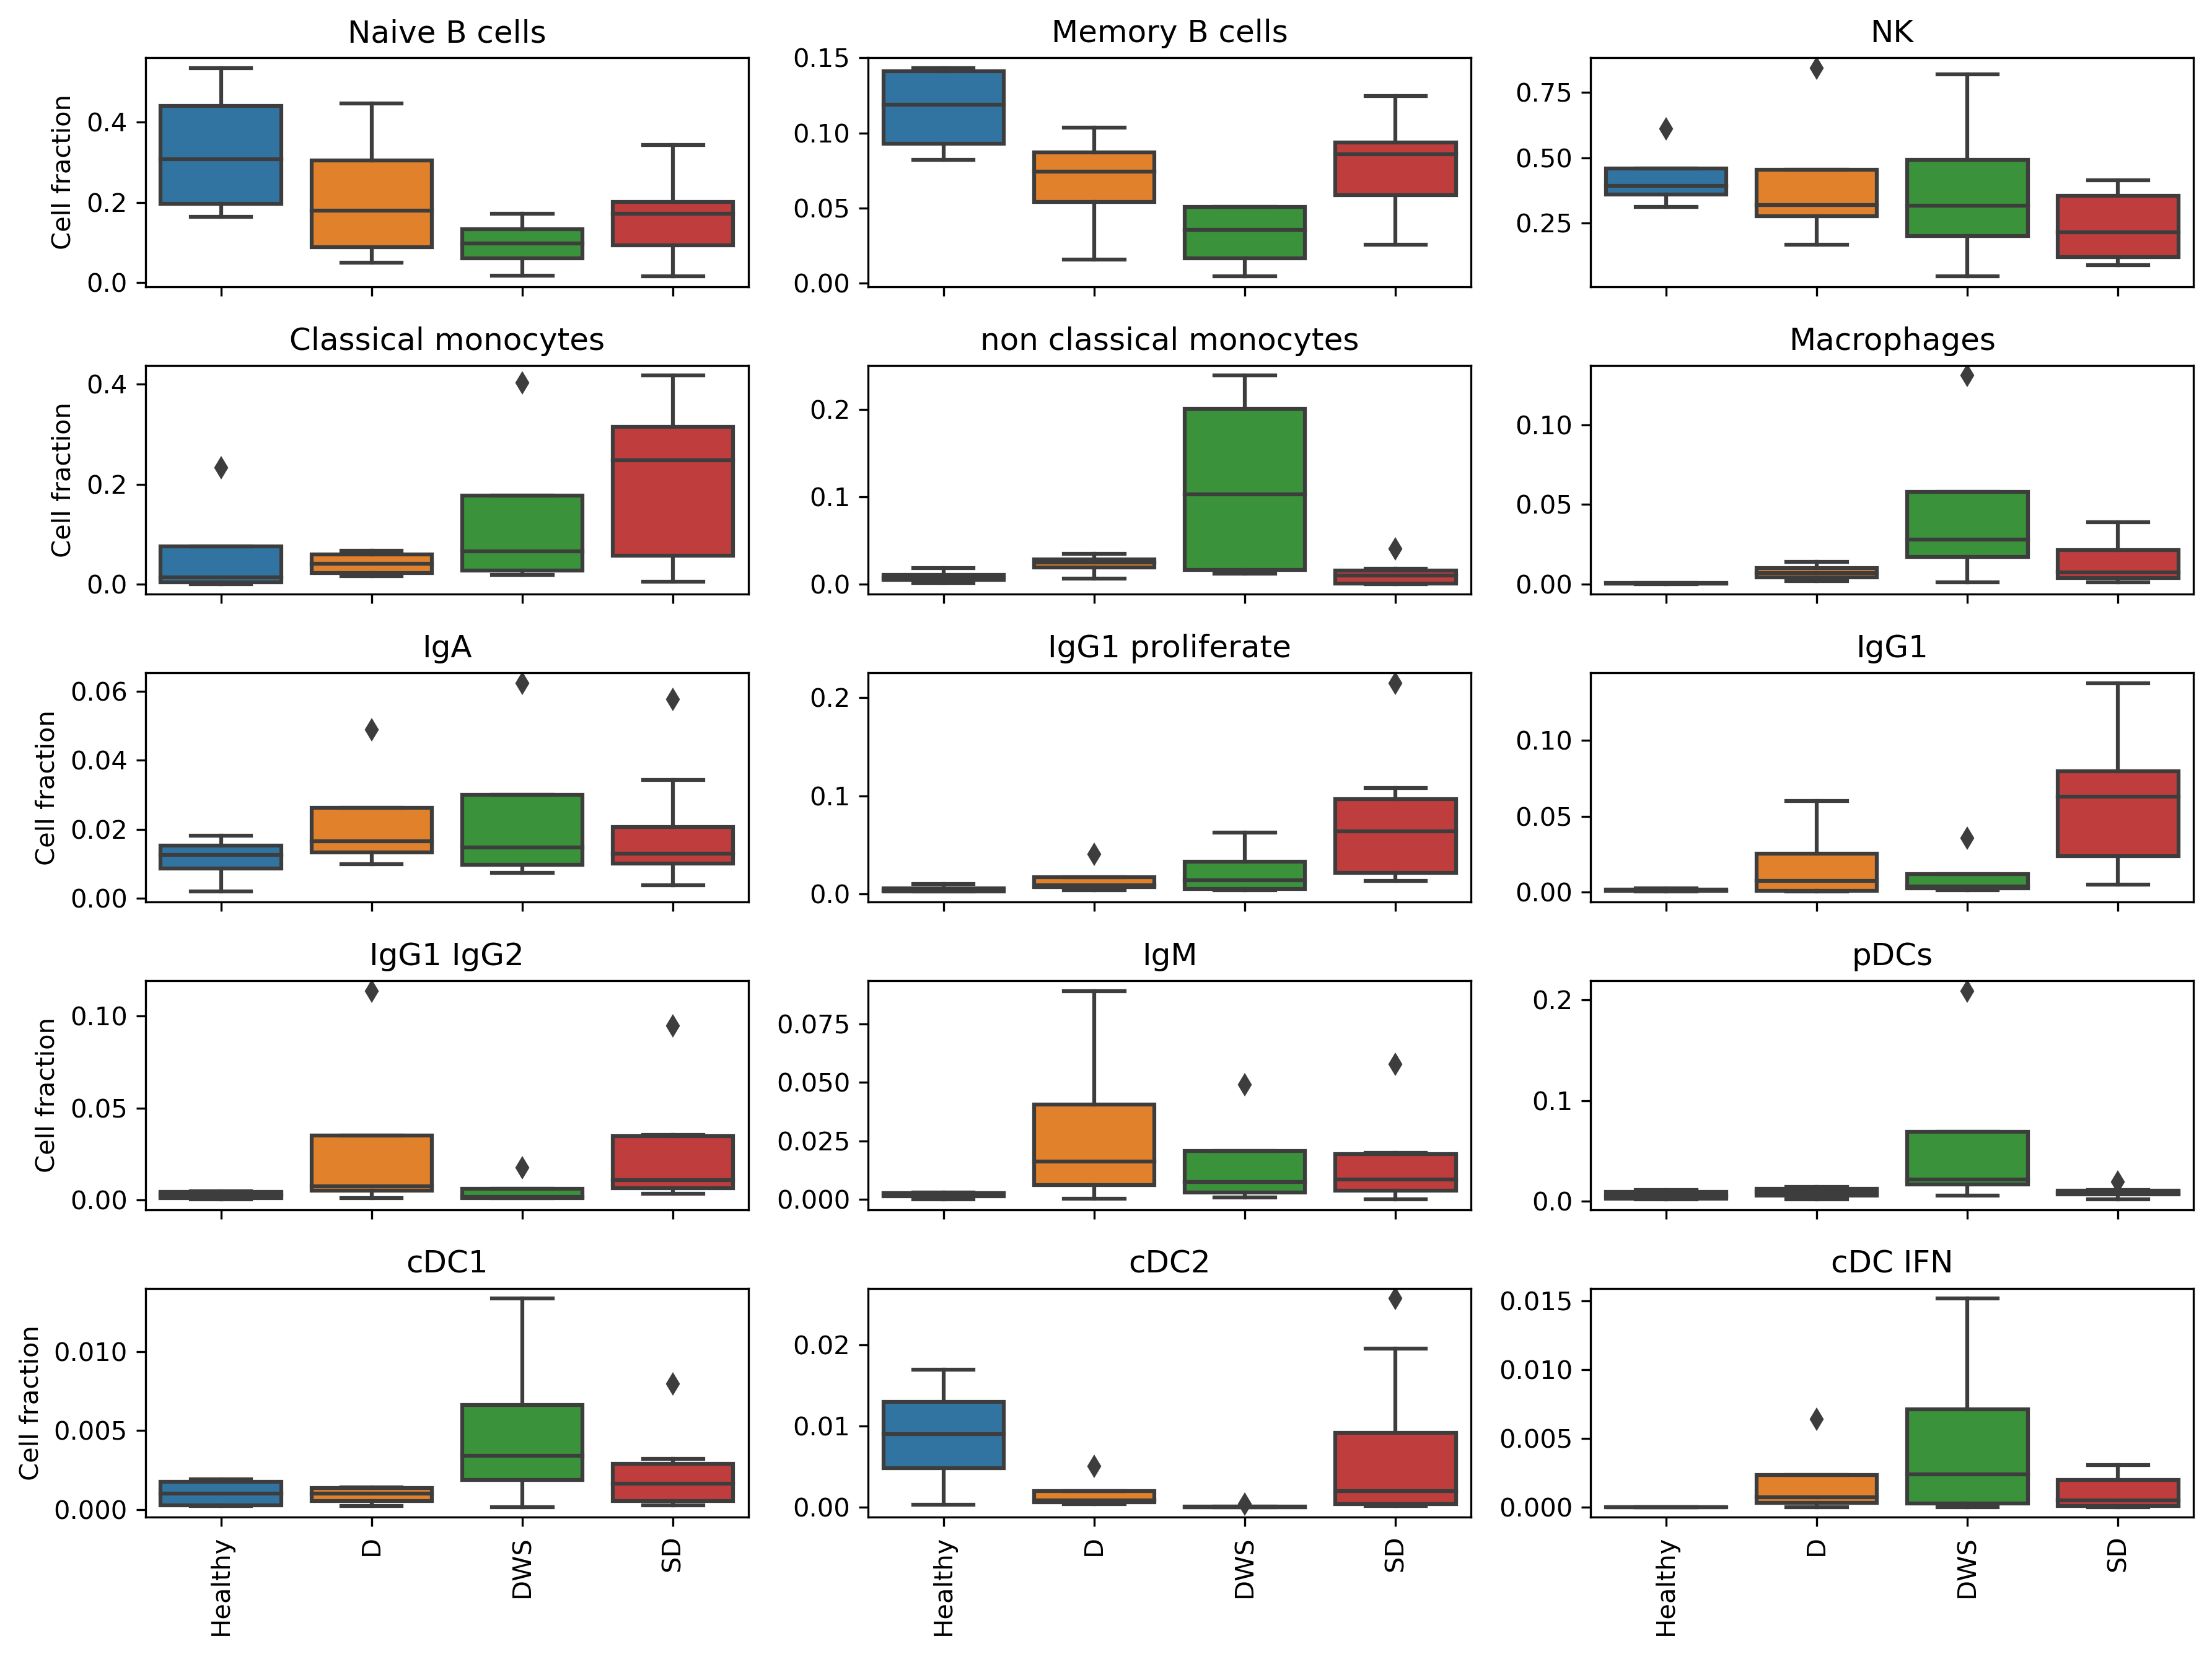

In [7]:
fig, axs = plt.subplots(5, 3, figsize=[12, 9], dpi=300, sharex=True)
axs = axs.ravel()
csts_plot = [
 'Naive_B_cells',
 'Memory_B_cells',
 'NK',
 'Classical_monocytes',
 'non_classical_monocytes',
 'Macrophages',
 'IgA',
 'IgG1_proliferate',
 'IgG1',
 'IgG1_IgG2',
 'IgM',
 'pDCs',
 'cDC1',
 'cDC2',
 'cDC_IFN',
 ]
for cst, ax in zip(csts_plot, axs):
    sns.boxplot(data = df.loc[cst], x = 'condition', y = 'fra_ID', ax=ax)
    ax.set(ylabel=None, 
           xlabel=None,
           title=cst.replace('_', ' '),
          )
    ax.set_xticklabels(['Healthy', 'D', 'DWS', 'SD'], rotation=90)
for i in range(0, 15, 3):
    axs[i].set_ylabel('Cell fraction')
fig.tight_layout()
fig.savefig(save_fdn + 'boxplot_frac_cst_in_sample.png')
#sns.catplot(data=df, x = 'condition', y = 'fra', kind='box', col='cst', col_wrap=3)

####exclude T cells in each ID

# Box and whisker plots (25–75 percentile) of percentages of cell subsets inside each major immune cell type (per cell type)

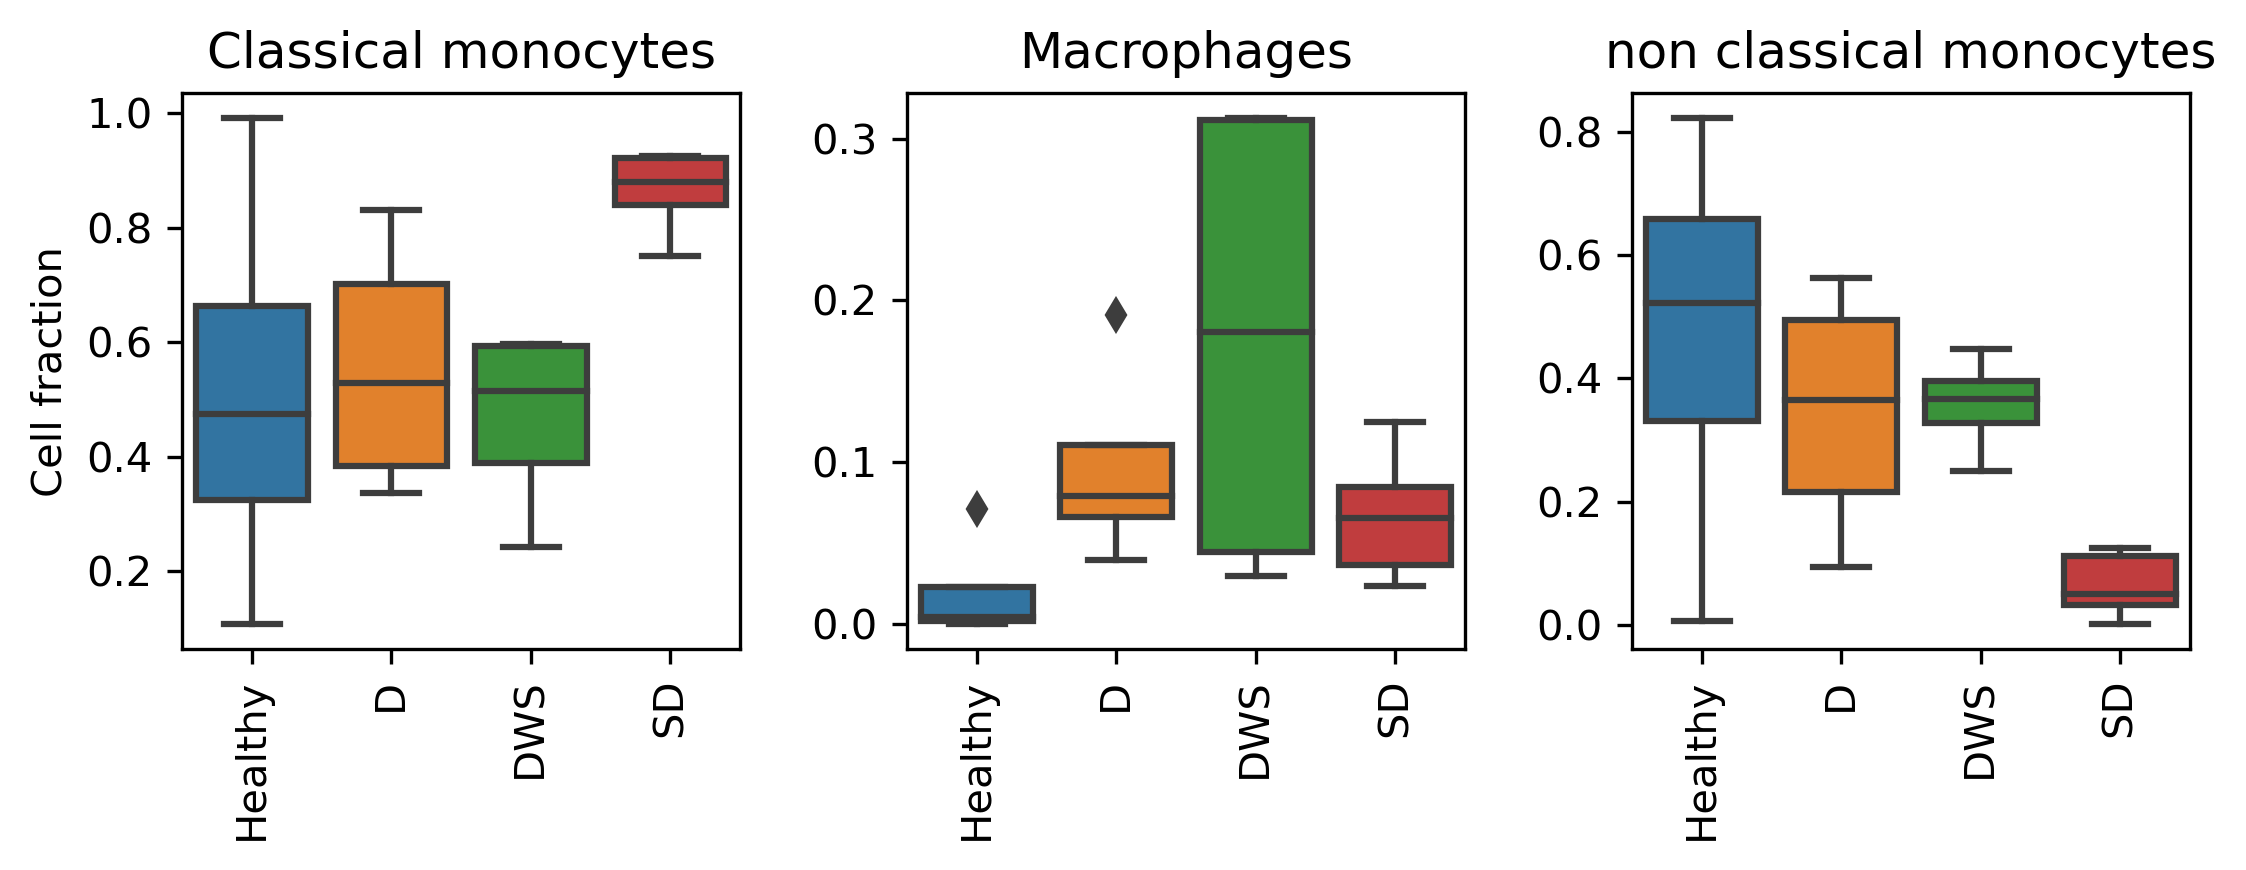

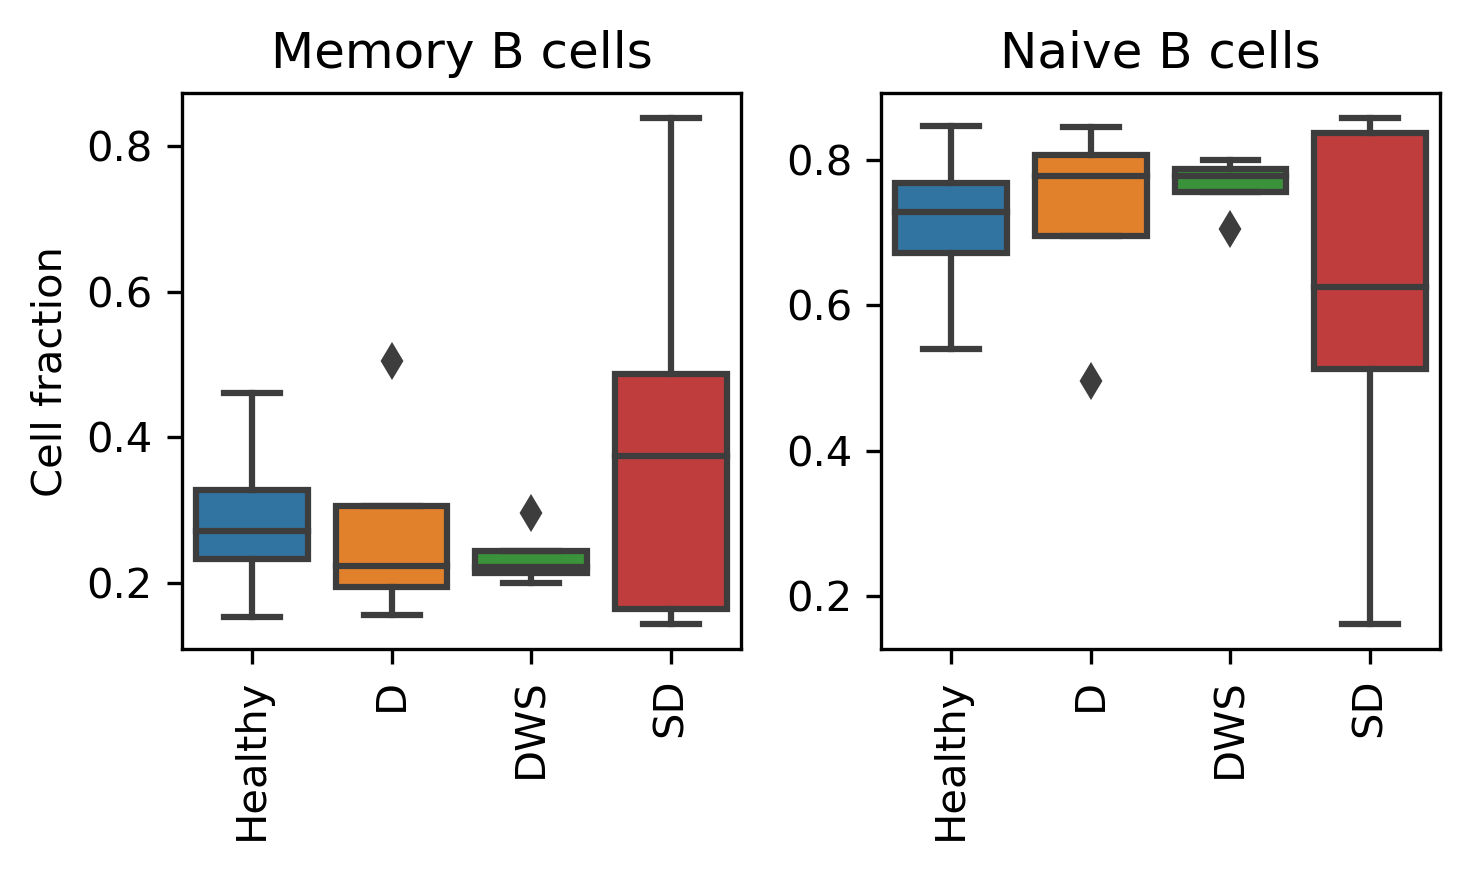

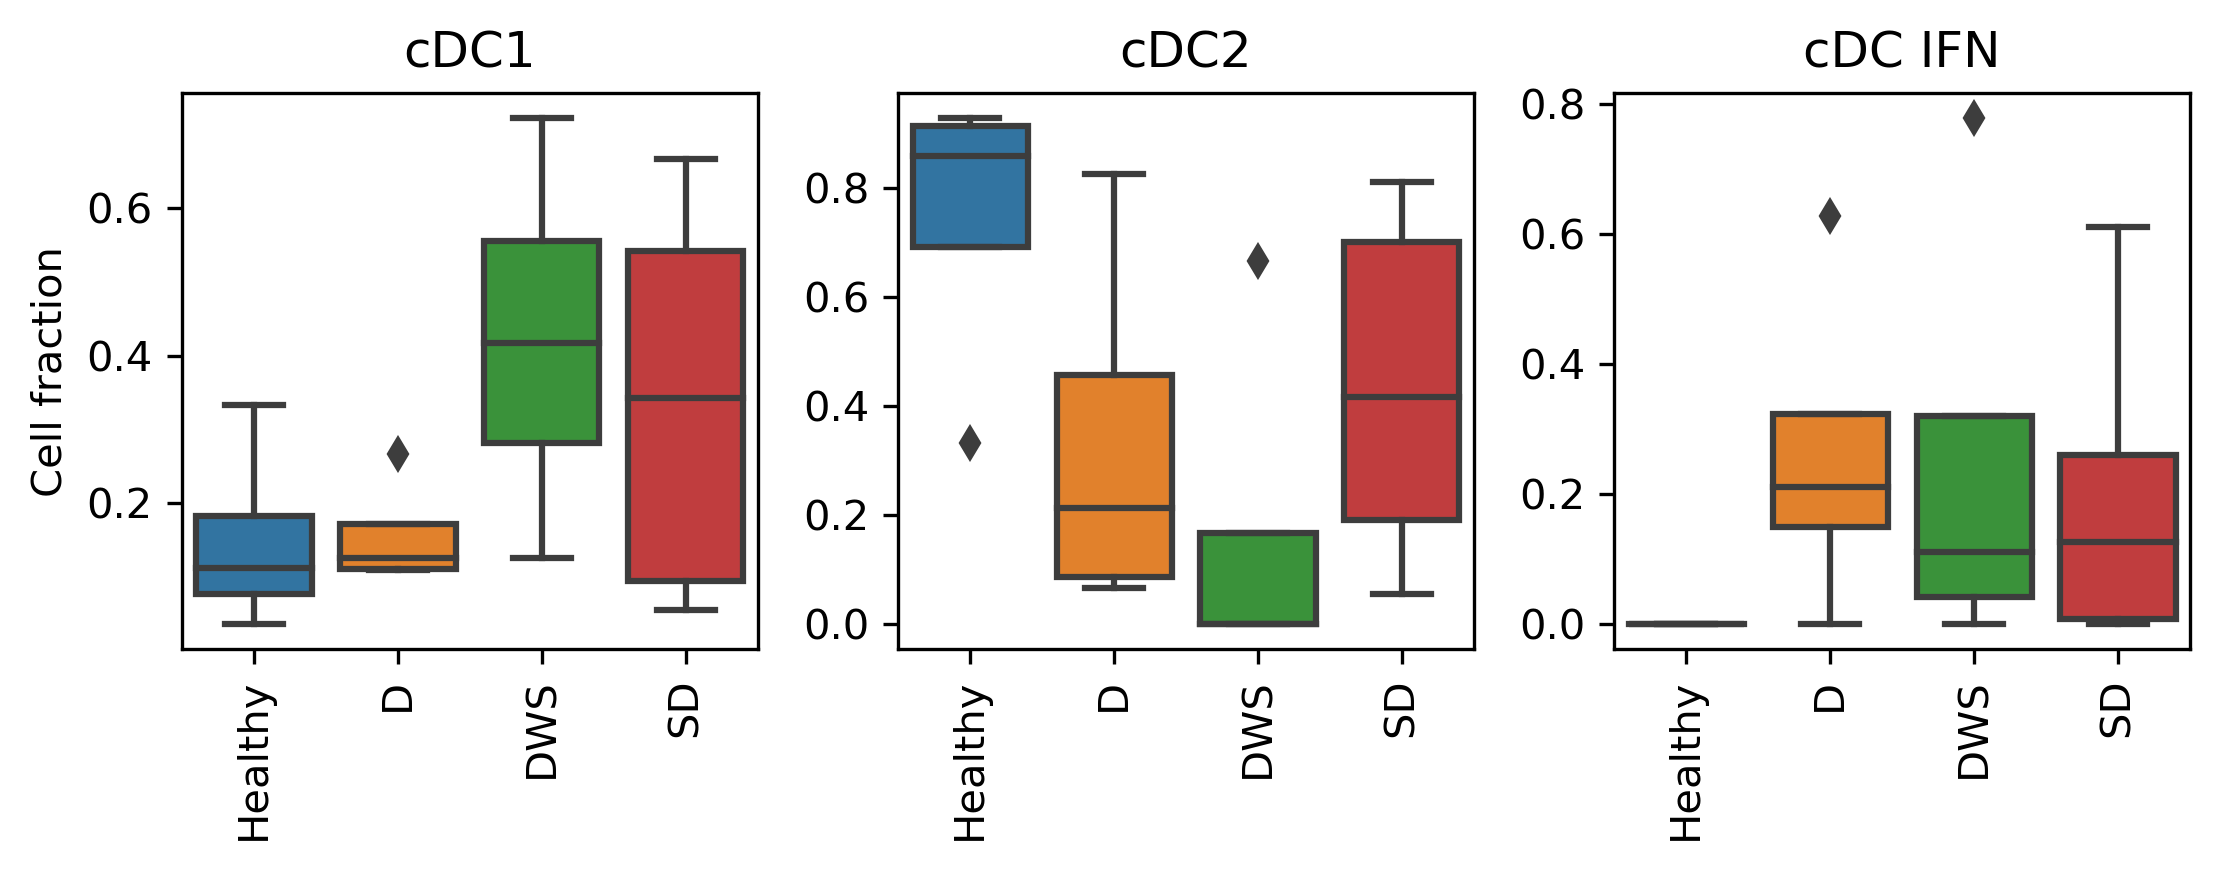

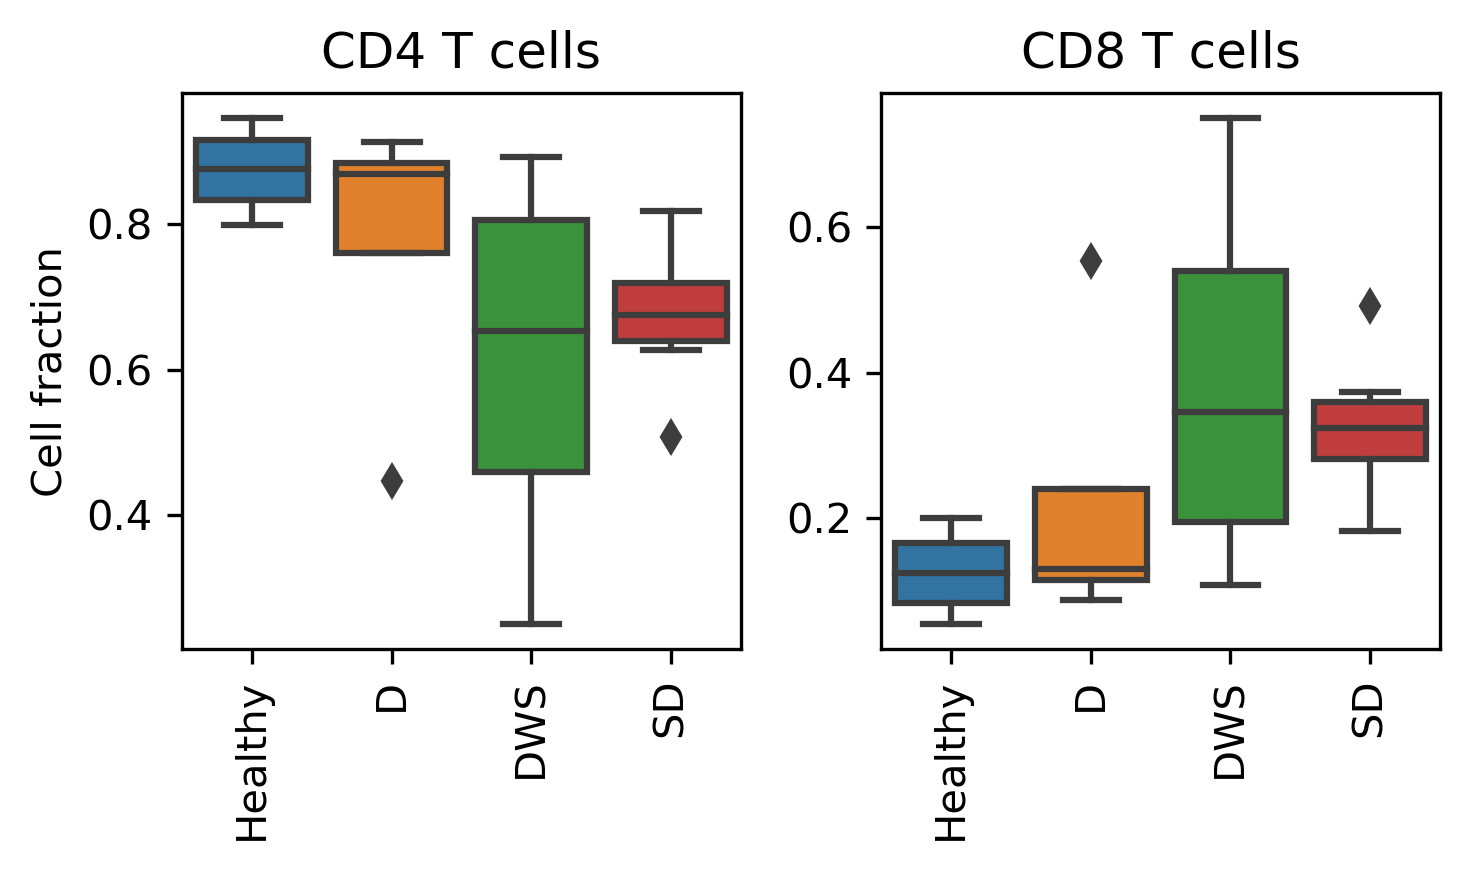

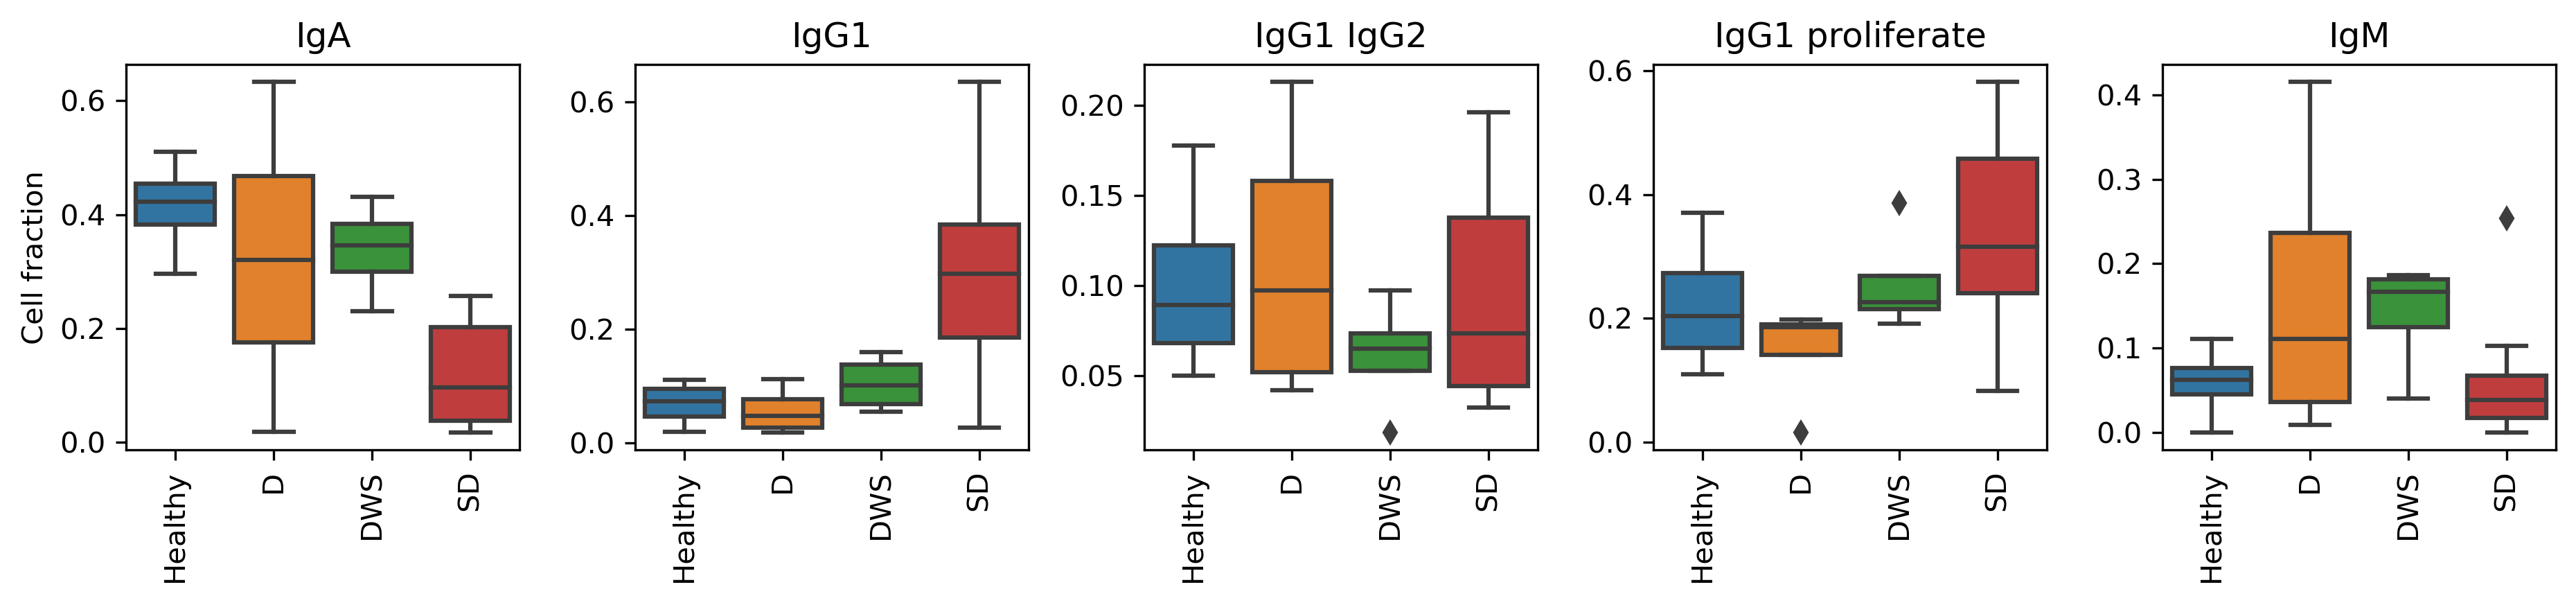

In [335]:
for ct in ['Monocytes', 'B_cells', 'cDCs', 'T_cells', 'Plasmablasts']:
    cst = list(adata_kid[adata_kid.obs['cell_type'] == ct].obs['cell_subtype_2'].astype('category').cat.categories)
    if 'doublets' in cst:
        cst.remove('doublets')

    fig, axs = plt.subplots(1, len(cst), figsize=[len(cst)*2.5, 3], dpi=300)
    for csti, ax in zip(cst, axs):
        sns.boxplot(data = df.loc[csti], x = 'condition', y = 'fra_ct', ax=ax)
        ax.set(ylabel=None, 
               xlabel=None,
               title=csti.replace('_', ' '),
              )
        ax.set_xticklabels(['Healthy', 'D', 'DWS', 'SD'], rotation=90)
    axs[0].set_ylabel('Cell fraction')
    fig.tight_layout()
    fig.savefig(save_fdn + 'boxplot_frac_%s.png'%ct)
    
##### each cell type in each patient

# The volcano plot showing DEGs between the D and SD pediatric monocytes, -log10p > 2 and the log2 fold change > 1

In [11]:
subct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/mo/data_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/mo/data_pair.tsv', sep='\t',  index_col=['cell_subtype', 'gene'])

In [7]:
ct.loc['Monocytes'].sort_values('pvalue')

,med_pair,fra_pair,S_fra,NS_fra,S_avg,NS_avg,statistic,pvalue,avg1,avg2,log2_fold_change
gene,,,,,,,,,,,
IFITM1,-1.611979,0.12500,0.760781,0.864982,1251.153320,4854.071777,0.456392,1.620201e-218,10.273439,7.741715,-2.531724
VIM,0.862360,0.84375,0.971554,0.888087,3574.648438,1617.461182,0.431858,1.437469e-194,9.327337,11.218531,1.891193
COTL1,0.632047,0.68750,0.948555,0.750181,2289.878174,1018.255432,0.421987,2.184354e-185,7.431974,10.303160,2.871186
TNFSF10,-1.538971,0.09375,0.527614,0.768953,340.174530,1228.641846,0.408387,3.761551e-173,7.855918,4.739564,-3.116354
CST3,-0.615224,0.12500,0.995915,0.997112,5954.880859,9036.115234,0.385732,8.176284e-154,12.932890,12.324987,-0.607903
...,...,...,...,...,...,...,...,...,...,...,...
FGF17,0.000000,0.00000,0.000000,0.000722,0.000000,0.362825,0.000722,1.000000e+00,0.006481,0.000000,-0.006481
NPM2,0.000000,0.12500,0.000303,0.000000,0.037894,0.000000,0.000303,1.000000e+00,0.000000,0.002112,0.002112
GFRA2,0.000000,0.43750,0.007414,0.003610,1.803566,1.272764,0.003804,1.000000e+00,0.029588,0.056448,0.026859


In [15]:
def scatter_plot(data, name, ylim=200, xlim=3):
    #from adjustText import adjust_text
    data['-log10[pvalue]'] = -np.log10(data['pvalue'])
    
    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (data['-log10[pvalue]'] > 10)
    data.loc[(data['log2_fold_change'] > 1) & (data['-log10[pvalue]'] > 10), 'DEGs'] = 'Yes'
    data.loc[(data['log2_fold_change'] < -1) & (data['-log10[pvalue]'] > 10), 'DEGs'] = 'Yes'
    data.loc[~ req, 'DEGs'] = 'No'
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=300, facecolor=None)
    sns.set_style('ticks')
    sns.scatterplot(data=data, x='log2_fold_change', y='-log10[pvalue]', hue='DEGs', ax=ax, s=5, legend = False)

    for x, y, gene in zip(data[req]['log2_fold_change'], data[req]['-log10[pvalue]'], data[req].index):
        ax.text(x - 0.5, y, gene, c='black', fontsize=6)
    
    ax.set(
        xlim=(-xlim, xlim),
        ylim=(-10, ylim),
        xlabel='log2 fold change',
        ylabel='-log10P',
        title='%s (SD vs D)'%name.replace('_', ' ')
    )
    ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
    ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
    ax.axhline(10, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles=[], labels=None)

    return {'fig': fig, 'ax': ax}

In [52]:
def scatter_plot(data, name, ylim=200, xlim=3):
    #from adjustText import adjust_text
    data['-log10[pvalue]'] = -np.log10(data['pvalue'])
    
    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (data['-log10[pvalue]'] > 10)
    data.loc[(data['log2_fold_change'] > 1) & (data['-log10[pvalue]'] > 10), 'DEGs'] = 'Yes'
    data.loc[(data['log2_fold_change'] < -1) & (data['-log10[pvalue]'] > 10), 'DEGs'] = 'Yes'
    data.loc[~ req, 'DEGs'] = 'No'
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=300, facecolor=None)
    sns.set_style('ticks')
    sns.scatterplot(data=data, x='log2_fold_change', y='-log10[pvalue]', hue='DEGs', ax=ax, s=100, legend = False)

#     for x, y, gene in zip(data[req]['log2_fold_change'], data[req]['-log10[pvalue]'], data[req].index):
#         ax.text(x - 0.5, y, gene, c='black', fontsize=6)
    
    ax.set(
        xlim=(-xlim, xlim),
        ylim=(-10, ylim),
#         xlabel='log2 fold change',
#         ylabel='-log10P',
        #title='%s (SD vs D)'%name.replace('_', ' ')
    )
#     ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
#     ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
#     ax.axhline(10, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
    #ax.axis("off")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles=[], labels=None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('log2 fold change', fontsize=50)
    ax.set_ylabel('-log10P', fontsize=50)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return {'fig': fig, 'ax': ax}

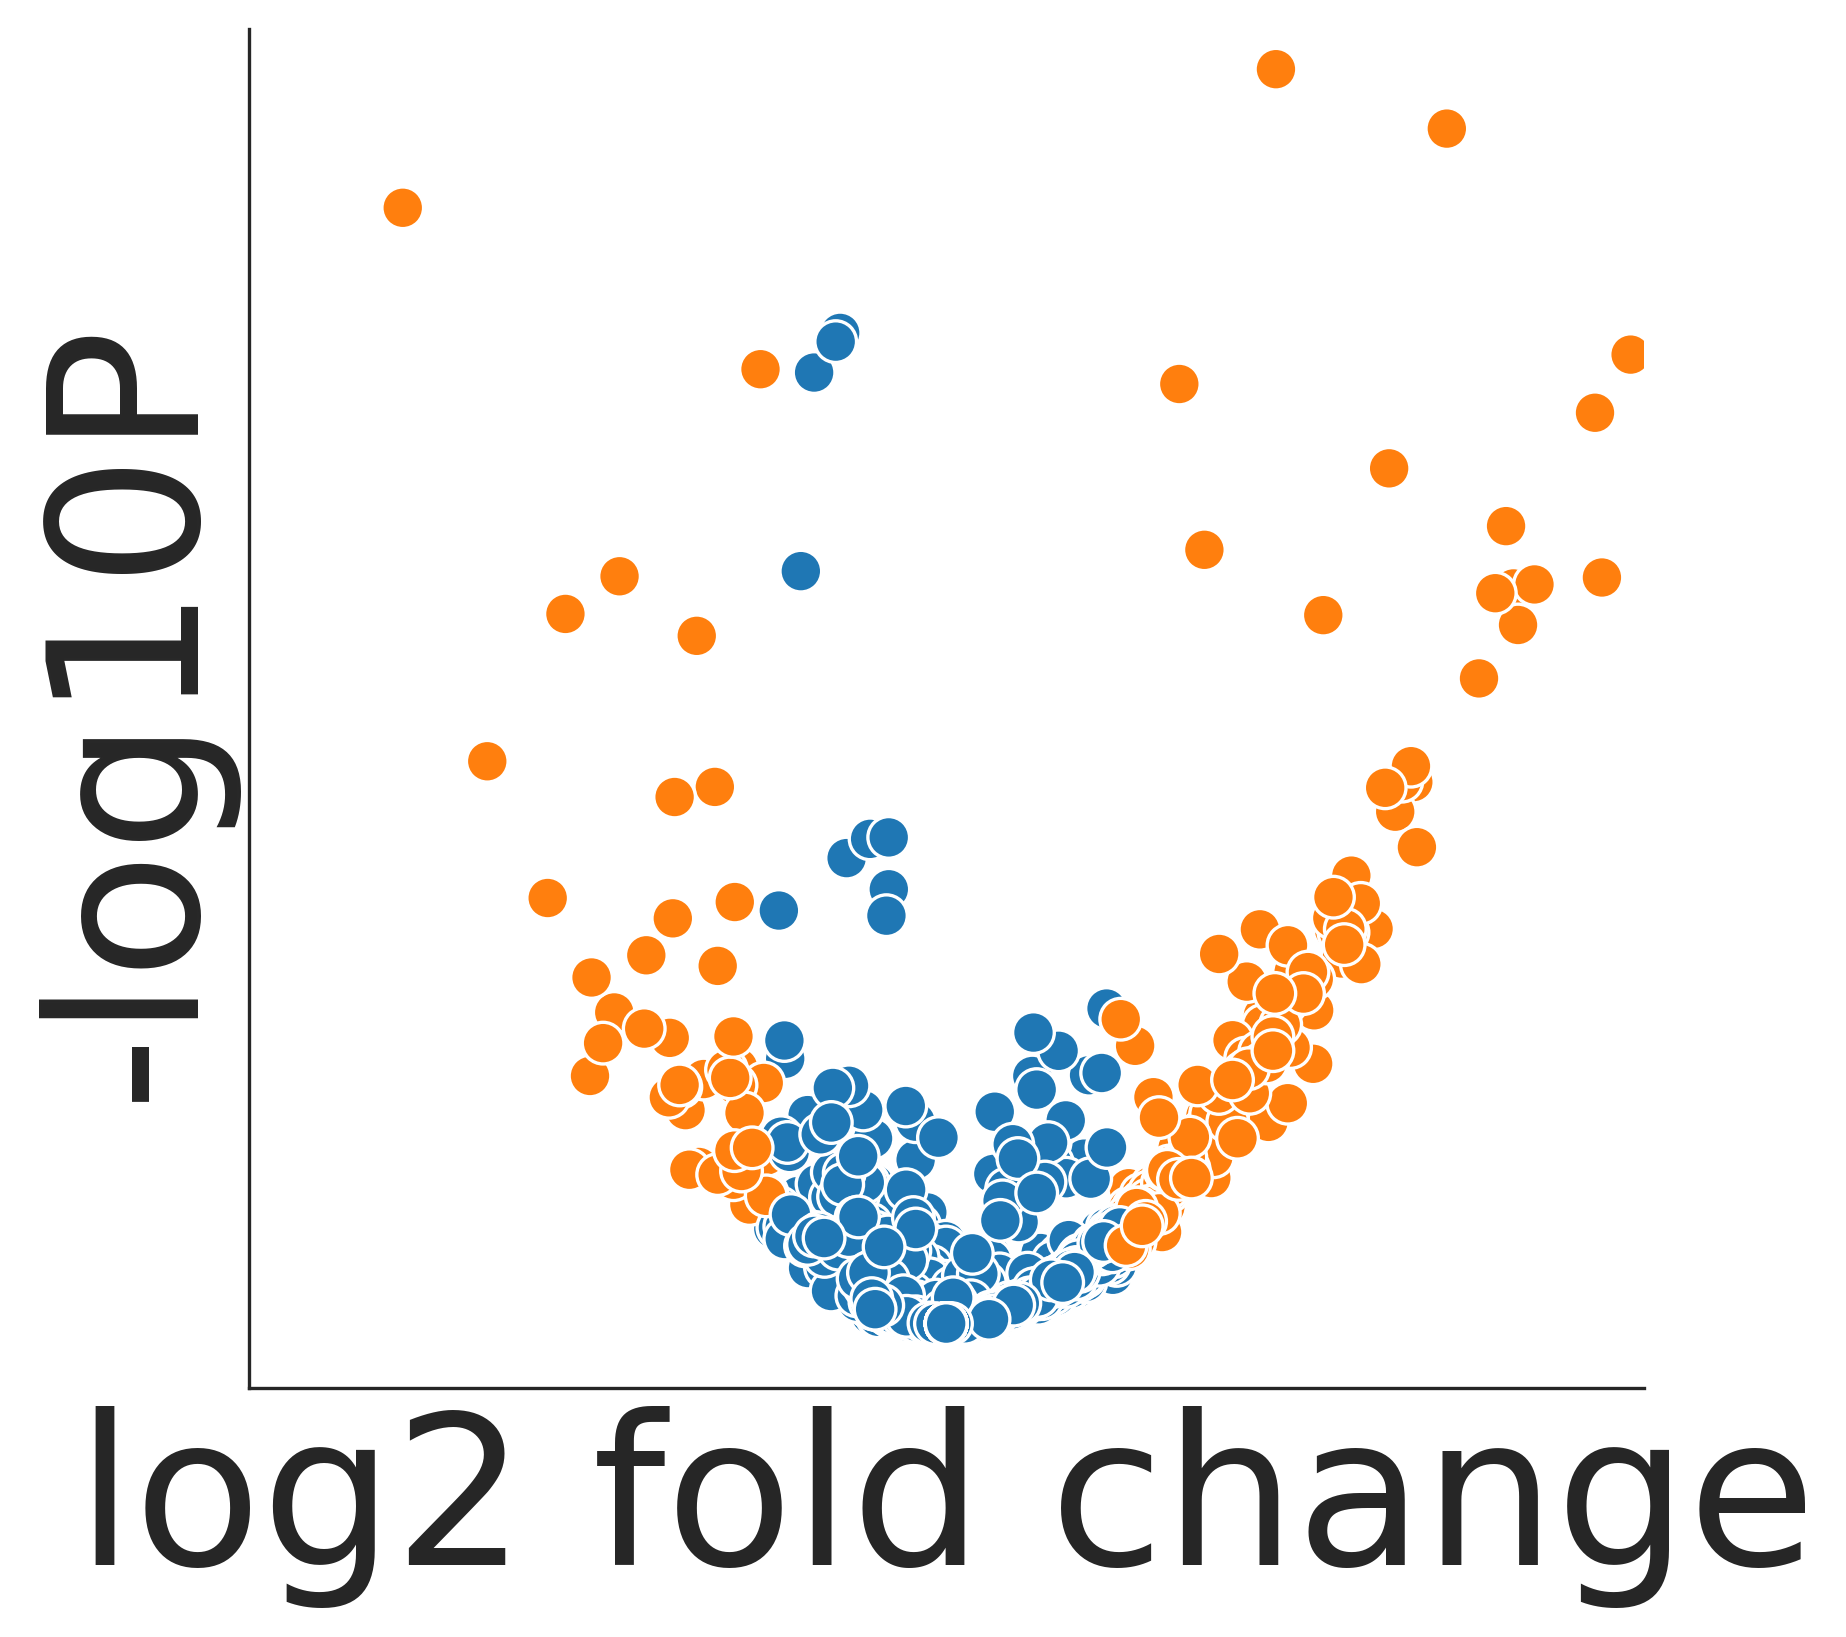

In [53]:
m_dt = scatter_plot(ct.loc['Monocytes'], 'Monocytes', ylim=200, xlim=4)
m_dt['fig'].savefig('/home/yike/Desktop/' + 'volcano_monocytes1.png', transparent=True)

In [20]:
data = ct.loc['Monocytes']
data['-log10[pvalue]'] = -np.log10(data['pvalue'])

req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (data['-log10[pvalue]'] > 10)
data.loc[(data['log2_fold_change'] > 1) & (data['-log10[pvalue]'] > 10), 'DEGs'] = 'up'
data.loc[(data['log2_fold_change'] < -1) & (data['-log10[pvalue]'] > 10), 'DEGs'] = 'down'
data.loc[~ req, 'DEGs'] = 'normal'

In [291]:
data[data['DEGs'] == 'up'].index.tolist()

['ENO1',
 'RBP7',
 'PGD',
 'CDA',
 'FGR',
 'NDUFS5',
 'ATP6V0B',
 'UQCRH',
 'JUN',
 'RPL5',
 'CD53',
 'FCGR1A',
 'S100A10',
 'S100A9',
 'S100A12',
 'S100A8',
 'RAB13',
 'TAGLN2',
 'MGST3',
 'CREG1',
 'SELL',
 'GLUL',
 'NCF2',
 'CD55',
 'ARF1',
 'ID2',
 'HADHA',
 'PCBP1',
 'CAPG',
 'VAMP8',
 'IL1R2',
 'IL1B',
 'CD302',
 'GCA',
 'XRCC5',
 'SLC11A1',
 'RPL15',
 'CRTAP',
 'UQCRC1',
 'TWF2',
 'TKT',
 'NFKBIZ',
 'HCLS1',
 'CSTA',
 'RNF7',
 'JCHAIN',
 'CXCL8',
 'CXCL3',
 'CXCL2',
 'EREG',
 'CCNI',
 'RPS3A',
 'HMGB2',
 'ACSL1',
 'BTF3',
 'TMEM167A',
 'VCAN',
 'CAST',
 'CD14',
 'DUSP1',
 'RACK1',
 'SERPINB1',
 'LY86',
 'HIST1H1E',
 'FLOT1',
 'RPL10A',
 'FKBP5',
 'PIM1',
 'CCND3',
 'UBE2J1',
 'TNFAIP3',
 'STX11',
 'SOD2',
 'RAC1',
 'DBNL',
 'PPIA',
 'UPP1',
 'CD36',
 'GNB2',
 'TBXAS1',
 'TMEM176B',
 'TMEM176A',
 'SLC25A6',
 'CD99',
 'RBM3',
 'PLP2',
 'VSIG4',
 'PGK1',
 'TSC22D3',
 'SLC25A5',
 'G6PD',
 'FDFT1',
 'CTSB',
 'SLC25A37',
 'CLU',
 'CEBPD',
 'RPL7',
 'PABPC1',
 'NDUFB9',
 'GRINA',
 'PLI

In [292]:
data[data['DEGs'] == 'down'].index.tolist()

['HES4',
 'ISG15',
 'RSAD2',
 'NAGK',
 'CX3CR1',
 'TNFSF10',
 'CXCL10',
 'CD74',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DQB1',
 'PSMB9',
 'HLA-DPA1',
 'HLA-DPB1',
 'MARCKS',
 'CALHM6',
 'RNASET2',
 'NT5C3A',
 'FGL2',
 'SAMD9',
 'GIMAP7',
 'GIMAP4',
 'IFITM2',
 'IFITM1',
 'CDKN1C',
 'SERPING1',
 'MS4A7',
 'RARRES3',
 'DRAP1',
 'CTSC',
 'CARD16',
 'IFIT2',
 'IFIT3',
 'IFIT1',
 'CLEC12A',
 'LPAR6',
 'SAMD4A',
 'ZFP36L1',
 'ISG20',
 'CD300E',
 'RPS4Y1',
 'LGALS2',
 'APOBEC3A',
 'MX2',
 'MX1']

# genes expression fold change in representative altered pathways between the D and SD pediatric samples of 3 monocytes sub-populations

In [15]:
subct = subct.reset_index().set_index('gene')

In [7]:
mono_up = pd.read_excel('/home/yike/phd/dengue/figures/paper_figure/all_figures/monocytes_up/metascape_result.xlsx',
                       engine='openpyxl', sheet_name='Enrichment')

mono_down = pd.read_excel('/home/yike/phd/dengue/figures/paper_figure/all_figures/monocytes_down/metascape_result.xlsx',
                         engine='openpyxl', sheet_name='Enrichment')

In [37]:
# Neutrophil degranulation, upregulated
g_list1 = mono_up.loc[0]['Symbols'].split(',')

# Signaling by Interleukins, upregulated
g_list2 = mono_up.loc[47]['Symbols'].split(',')

# Interferon Signaling, downregulated
g_list3 = mono_down.loc[0]['Symbols'].split(',') + mono_down.loc[23]['Symbols'].split(',')

# antigen processing and presentation of exogenous peptide antigen via MHC class II, downregulated
g_list4 = mono_down.loc[24]['Symbols'].split(',') + mono_down.loc[23]['Symbols'].split(',')

# response to interferon-alpha
g_list5 = mono_down.loc[205]['Symbols'].split(',') + mono_down.loc[23]['Symbols'].split(',')

# Type II interferon signaling (IFNG)
g_list6 = mono_down.loc[217]['Symbols'].split(',') + mono_down.loc[23]['Symbols'].split(',')

In [182]:
def pathway_heatmap(subct, g_list, title):    
    df = subct.loc[g_list][['cell_subtype', 'log2_fold_change']]
    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), 3]), columns=['Classical_monocytes', 'non_classical_monocytes', 'Macrophages'], index=df.index.unique())

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col]['log2_fold_change'][0]

    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    g = sns.clustermap(df_new, cmap=cmap, center=0)
    g.fig.set_dpi(300)
    g.fig.suptitle(title, x=0.5, y=1.05, fontsize=20)
    ax = g.ax_heatmap
    ax.set_ylabel(None)
    xlabels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels, rotation=90)
    #g.fig.tight_layout()
    g.fig.savefig(save_fdn + title + '.png', bbox_inches='tight')

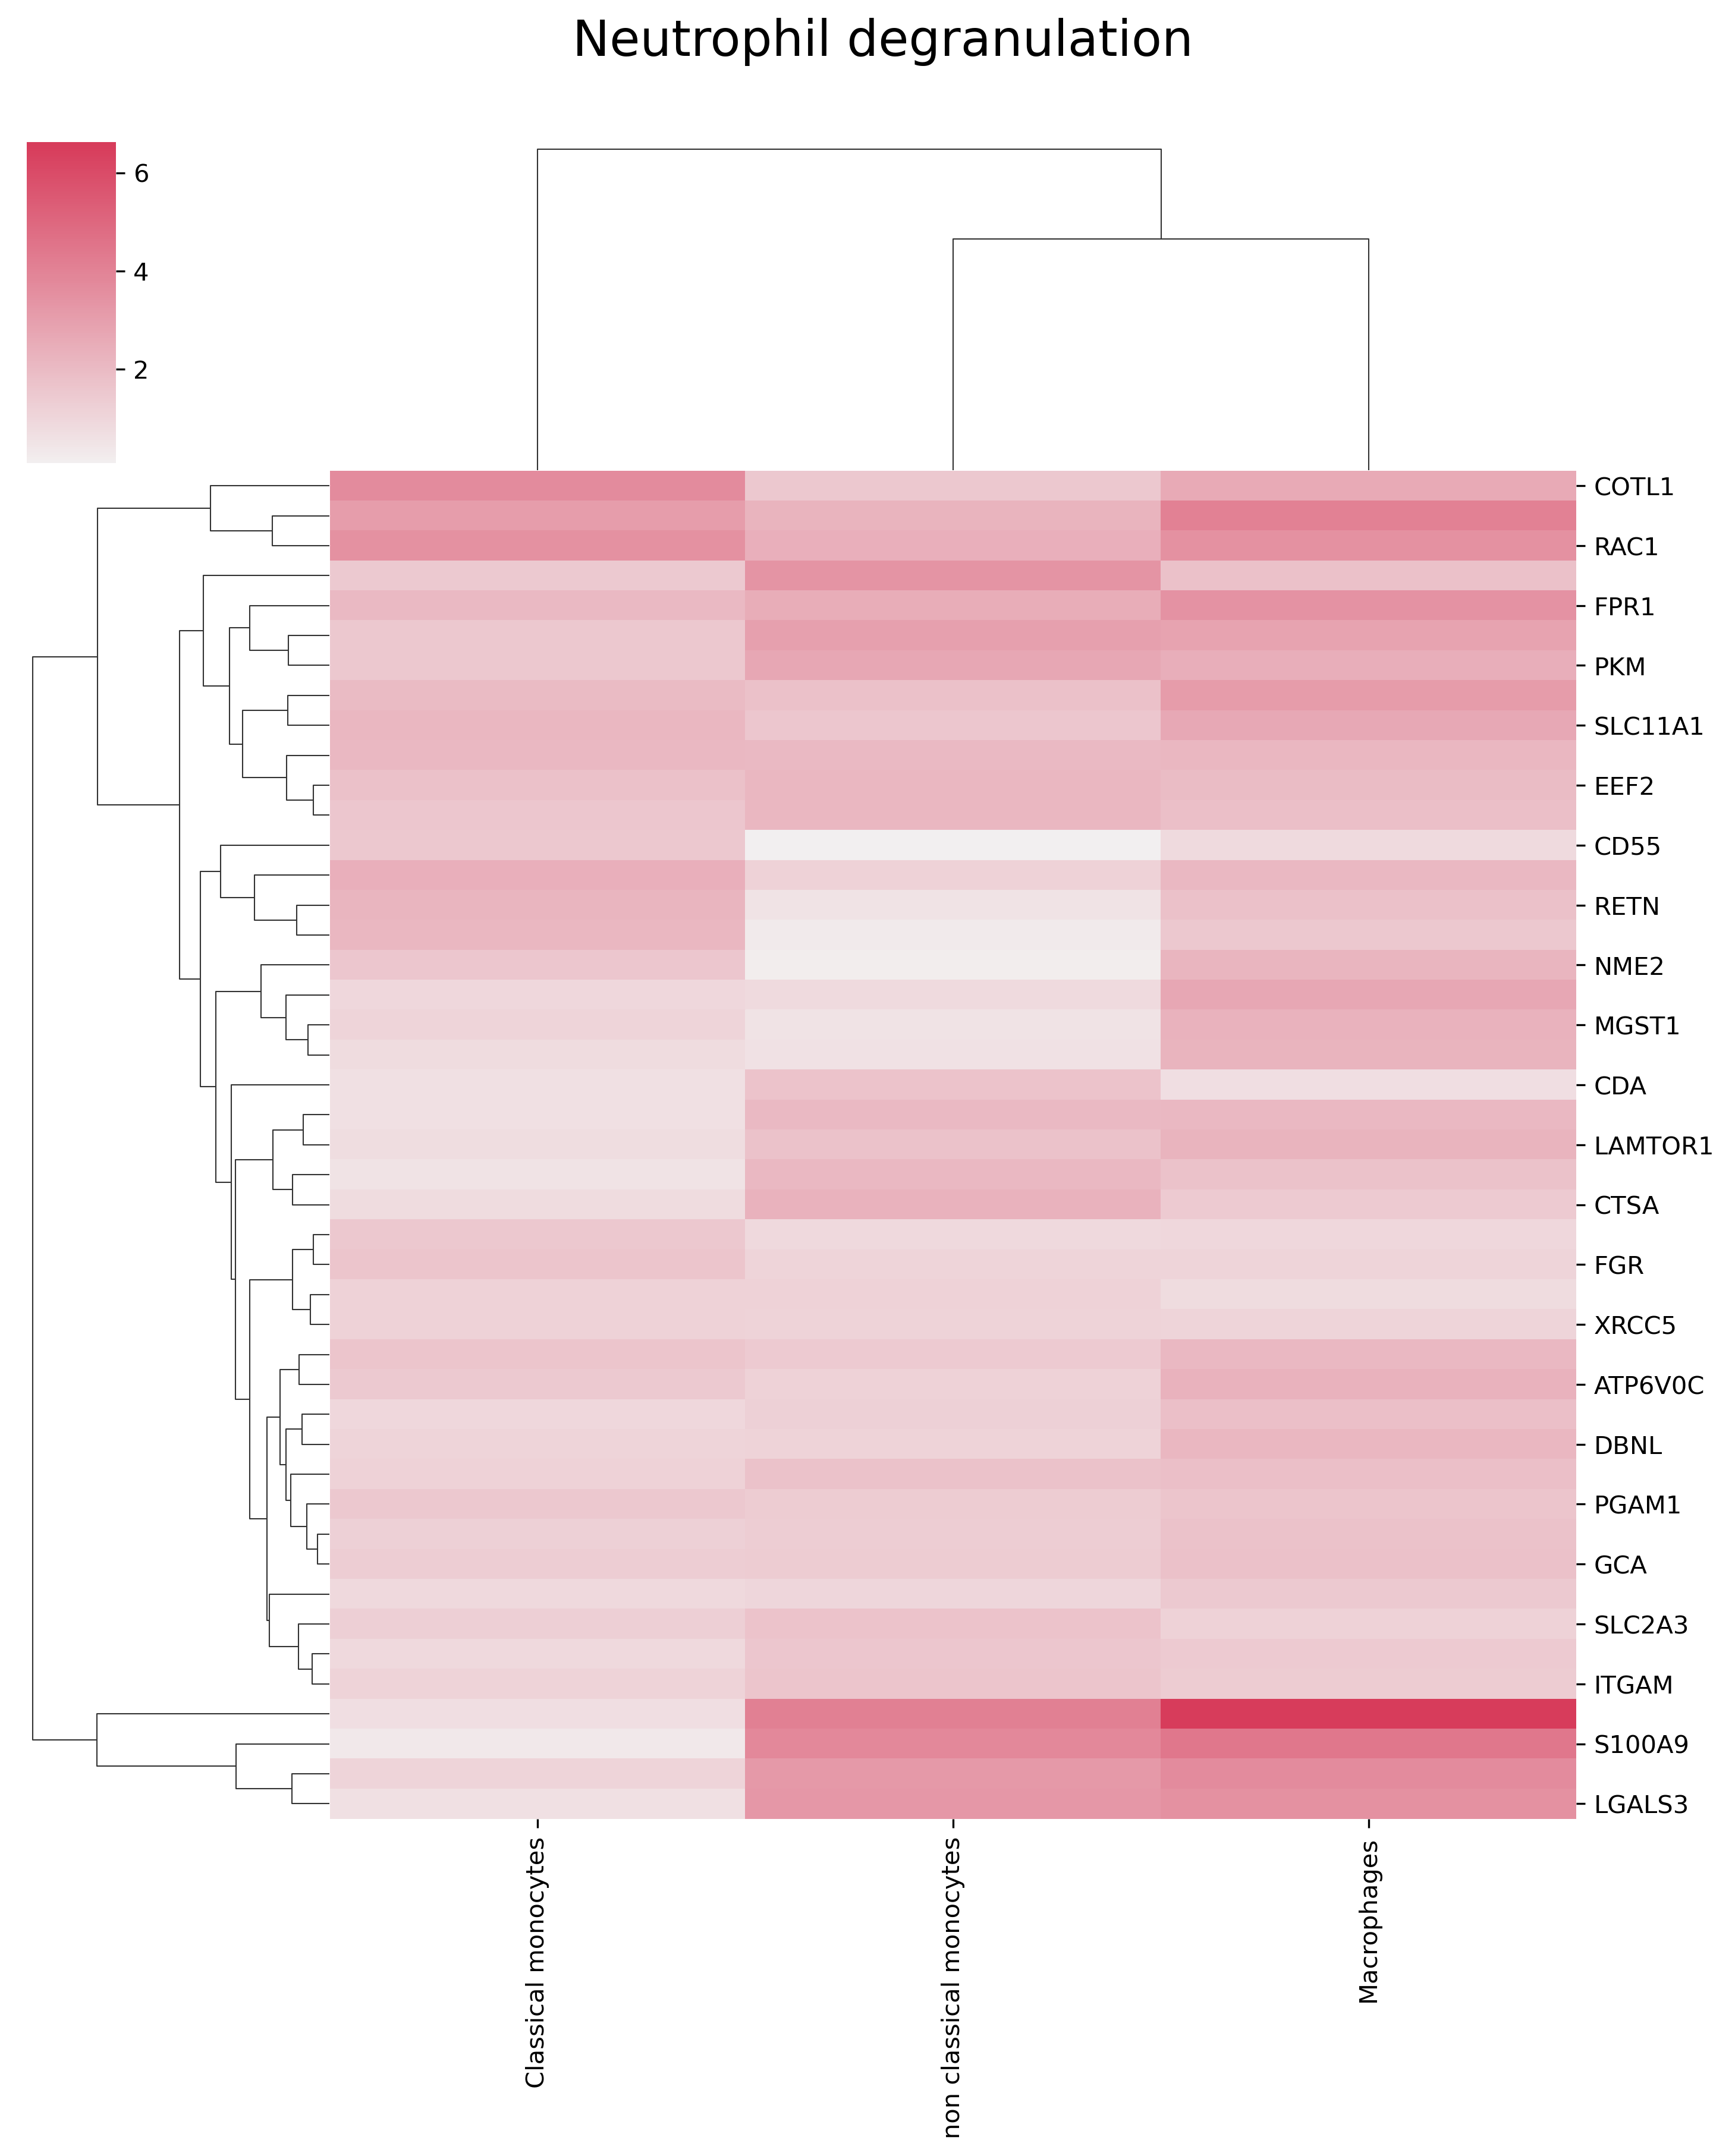

In [171]:
pathway_heatmap(subct, g_list1, 'Neutrophil degranulation')

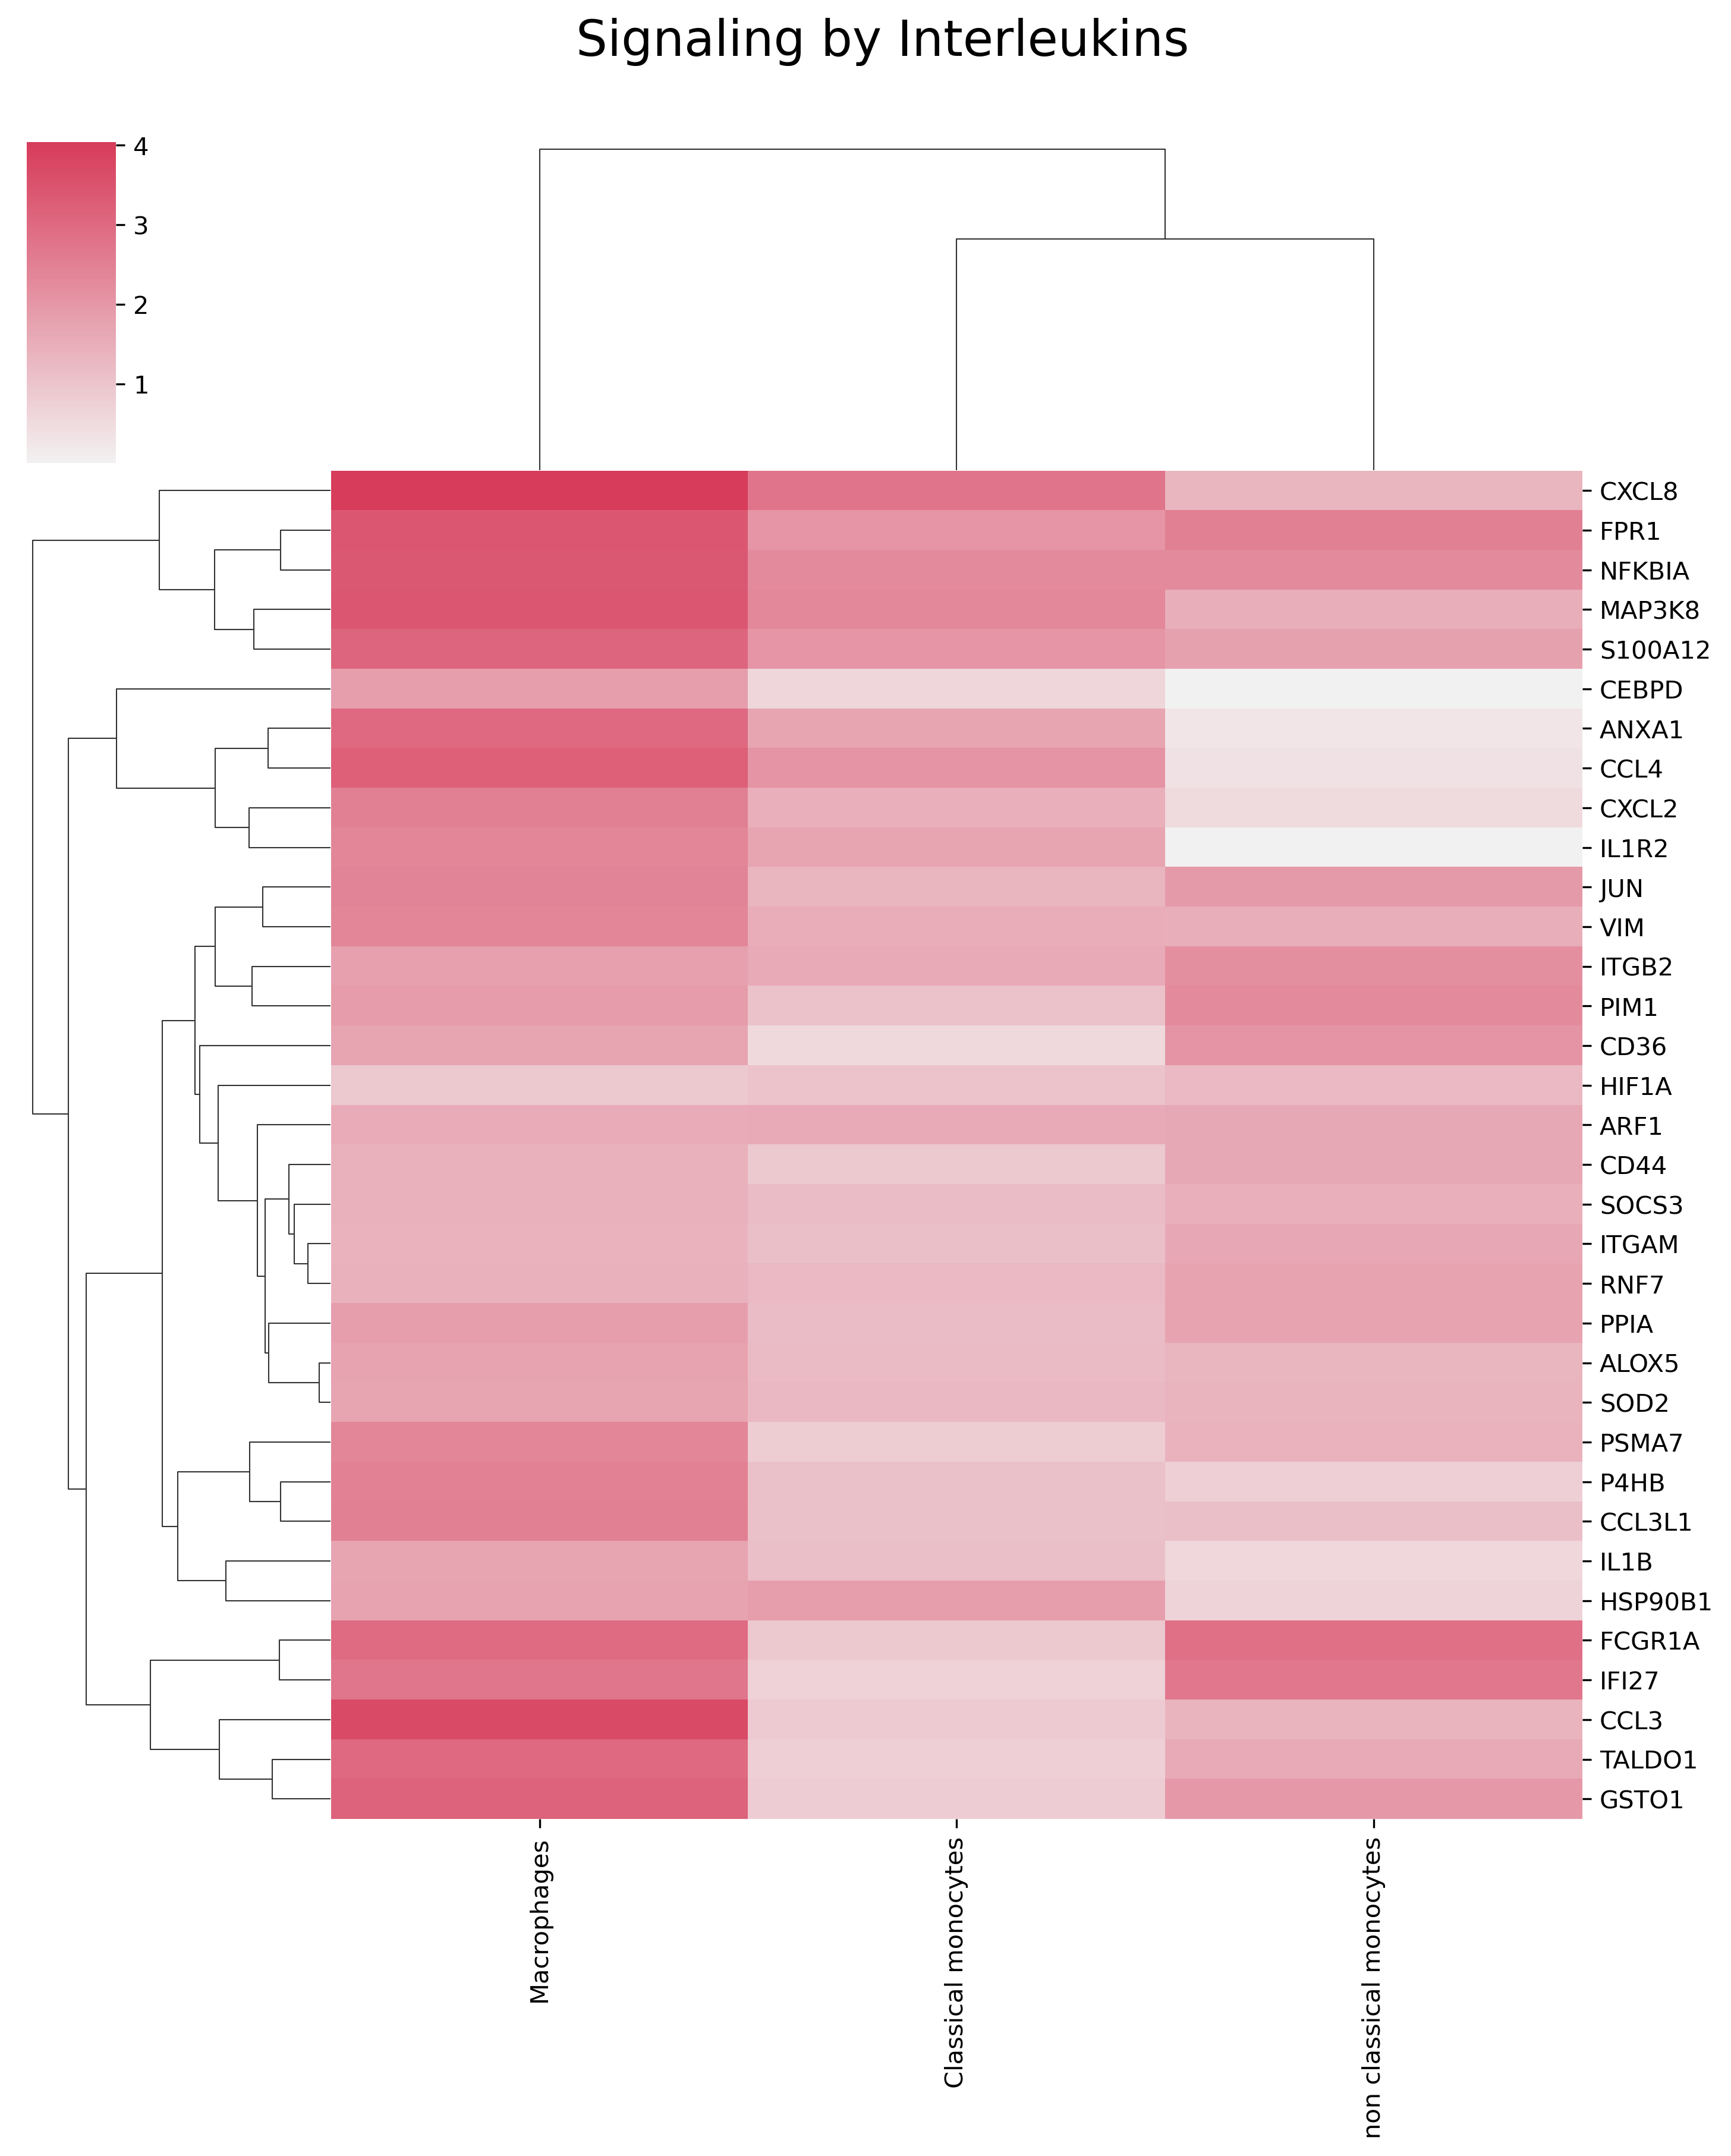

In [172]:
pathway_heatmap(subct, g_list2, 'Signaling by Interleukins')

In [173]:
#pathway_heatmap(g_list3, 'Interferon Signaling')

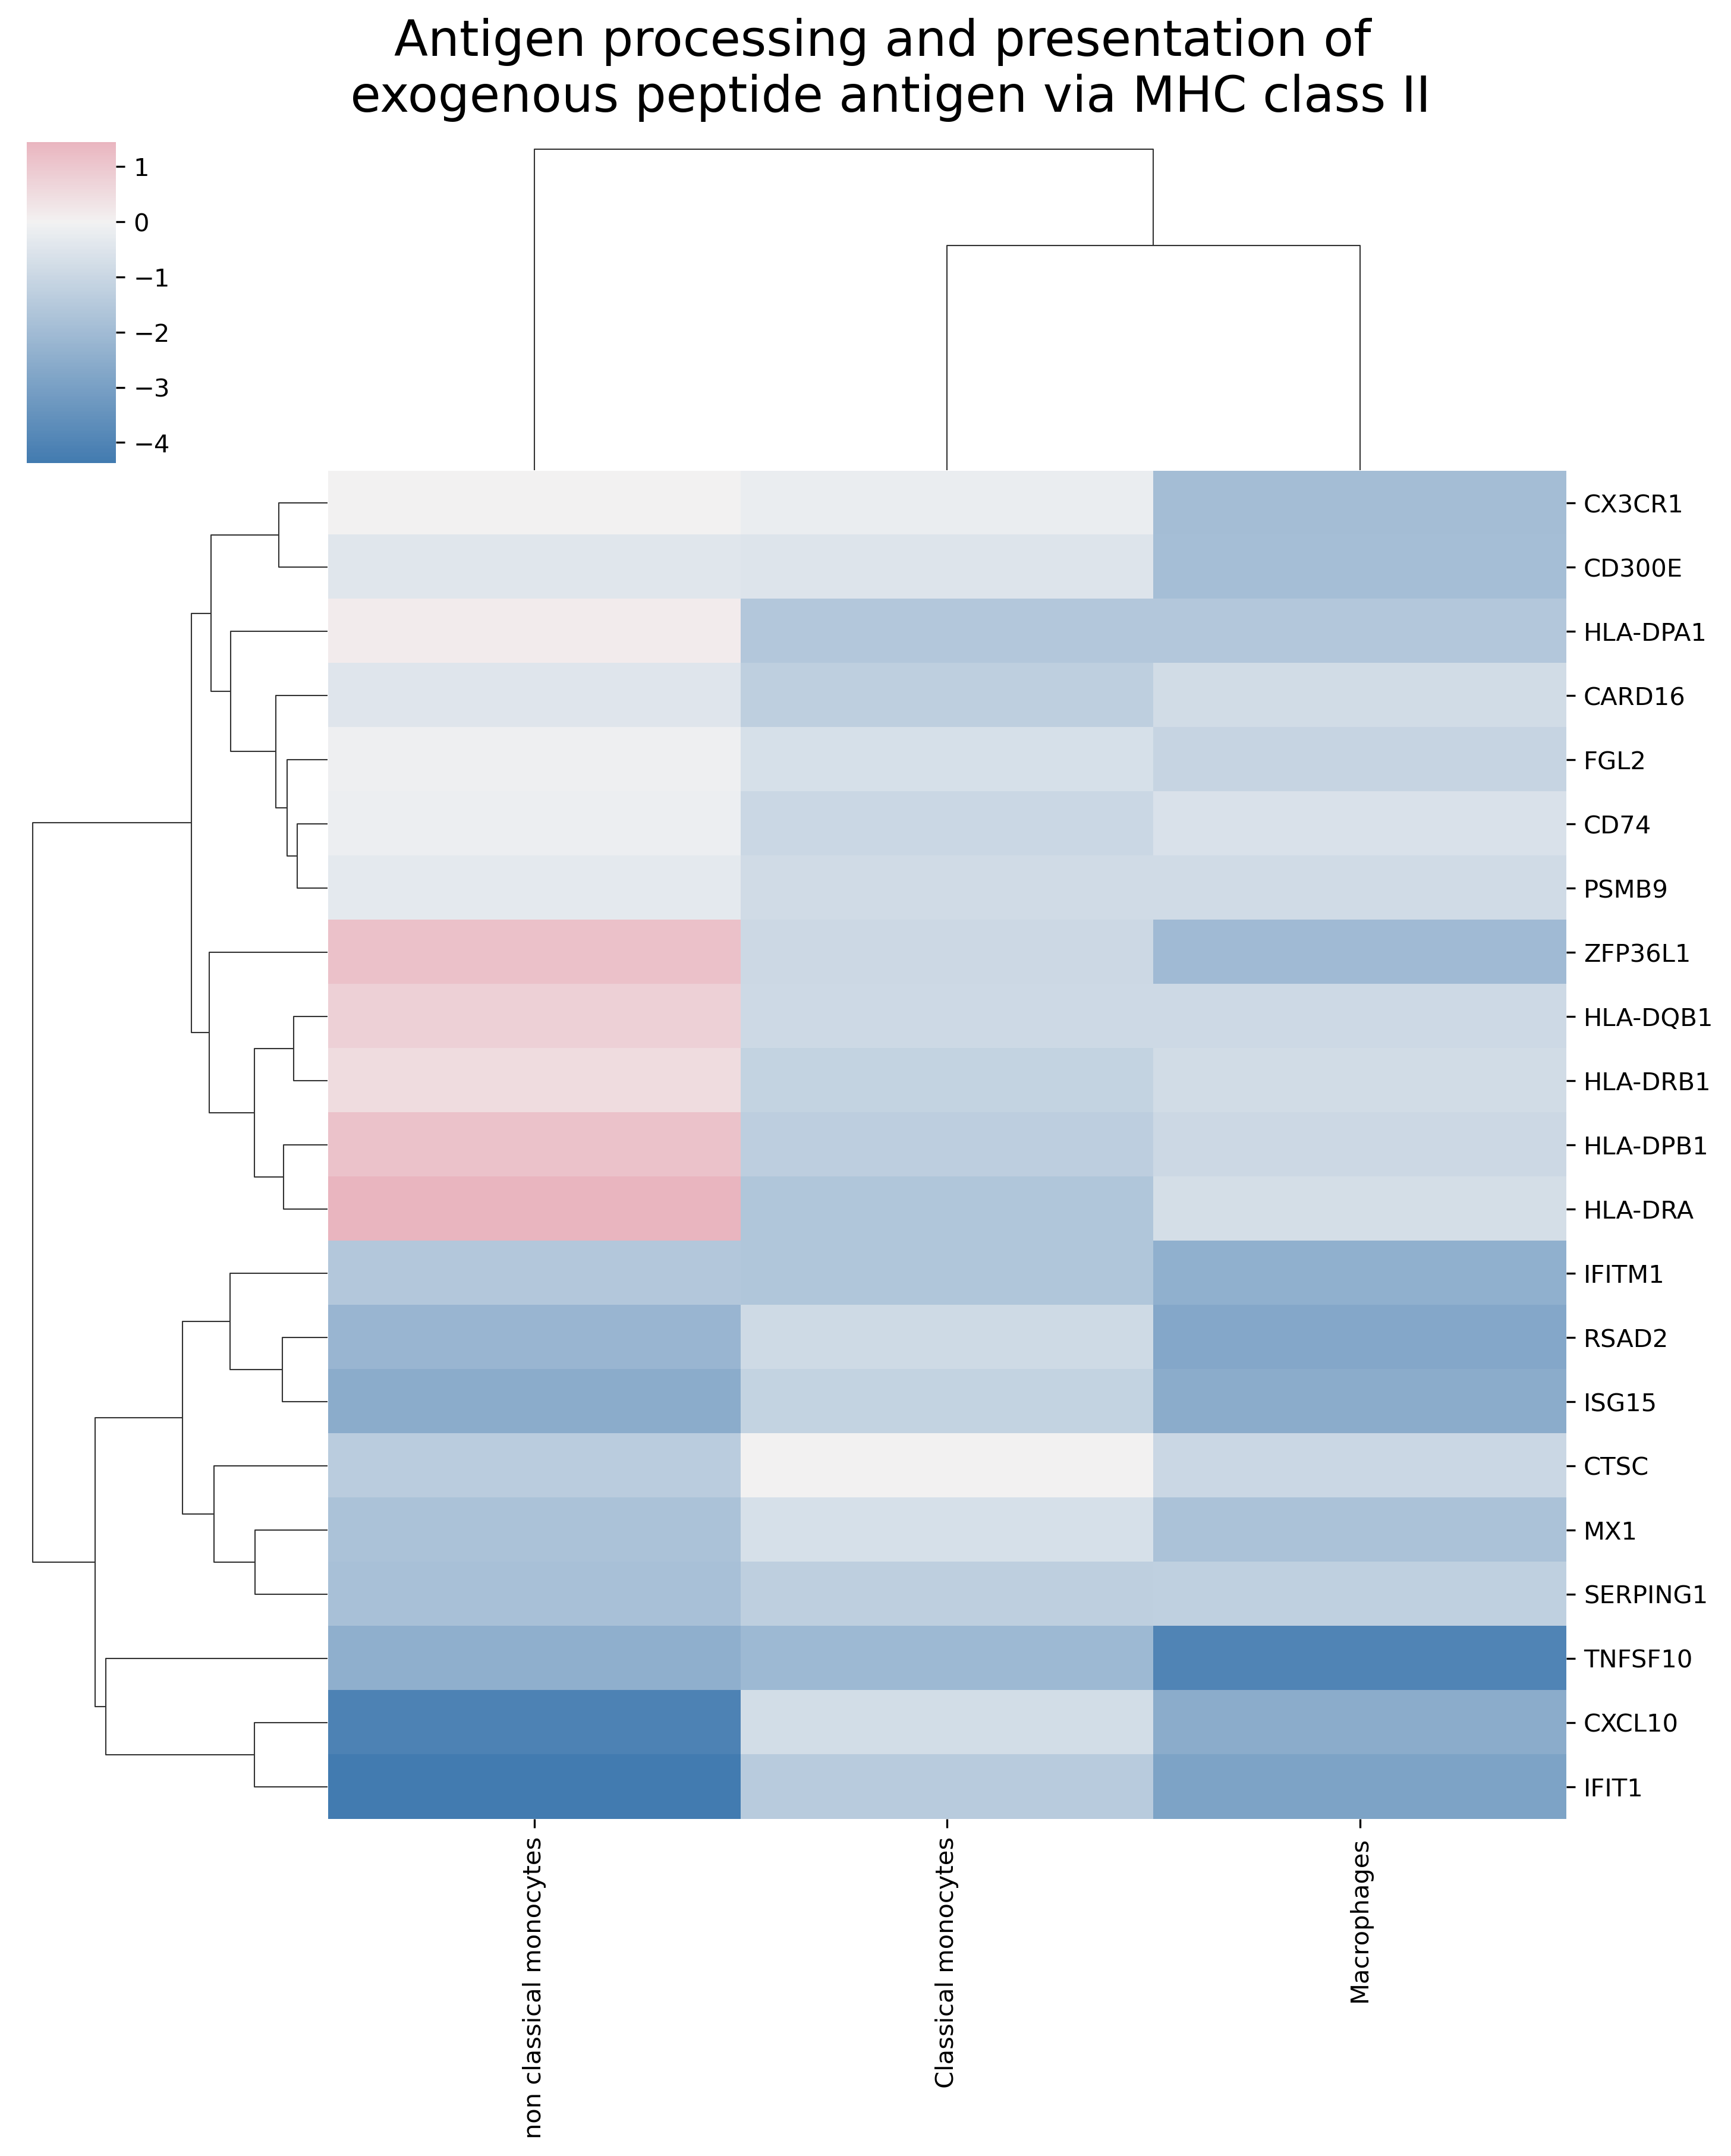

In [179]:
pathway_heatmap(subct, g_list4, 'Antigen processing and presentation of\n exogenous peptide antigen via MHC class II')

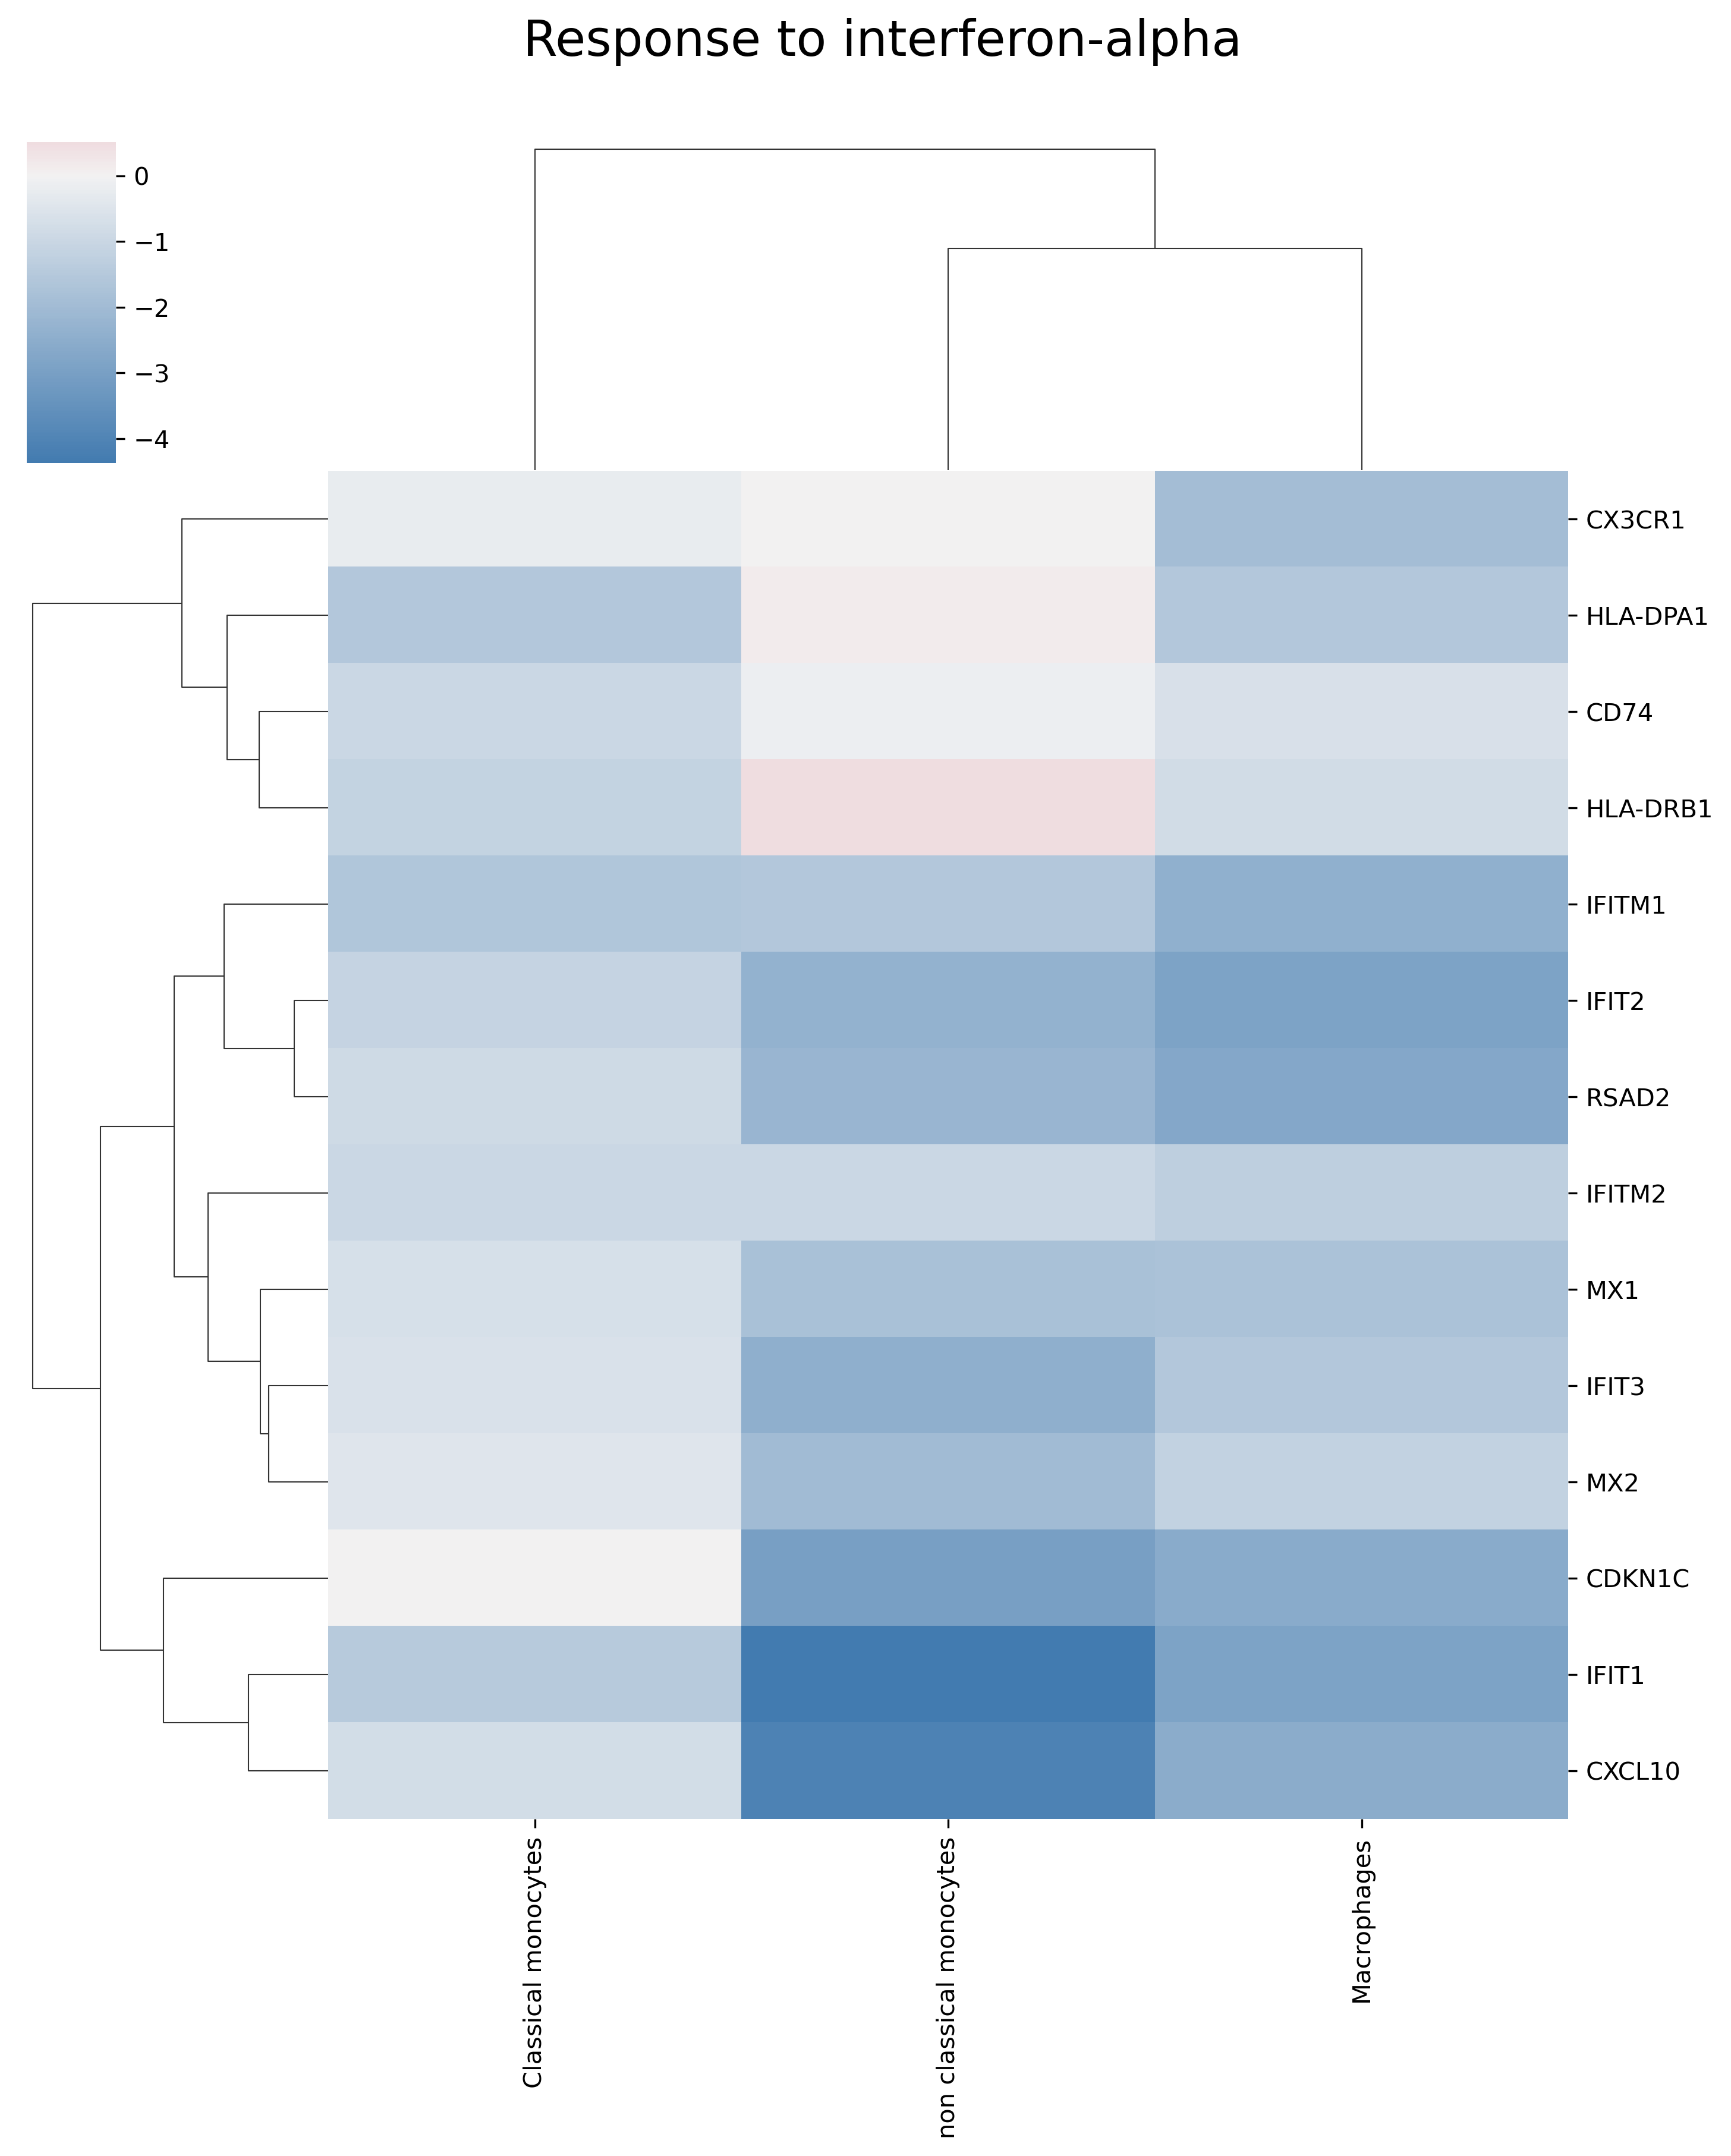

In [175]:
pathway_heatmap(subct, [gene for gene in g_list5 if gene in adata_kid.var_names], 'Response to interferon-alpha')

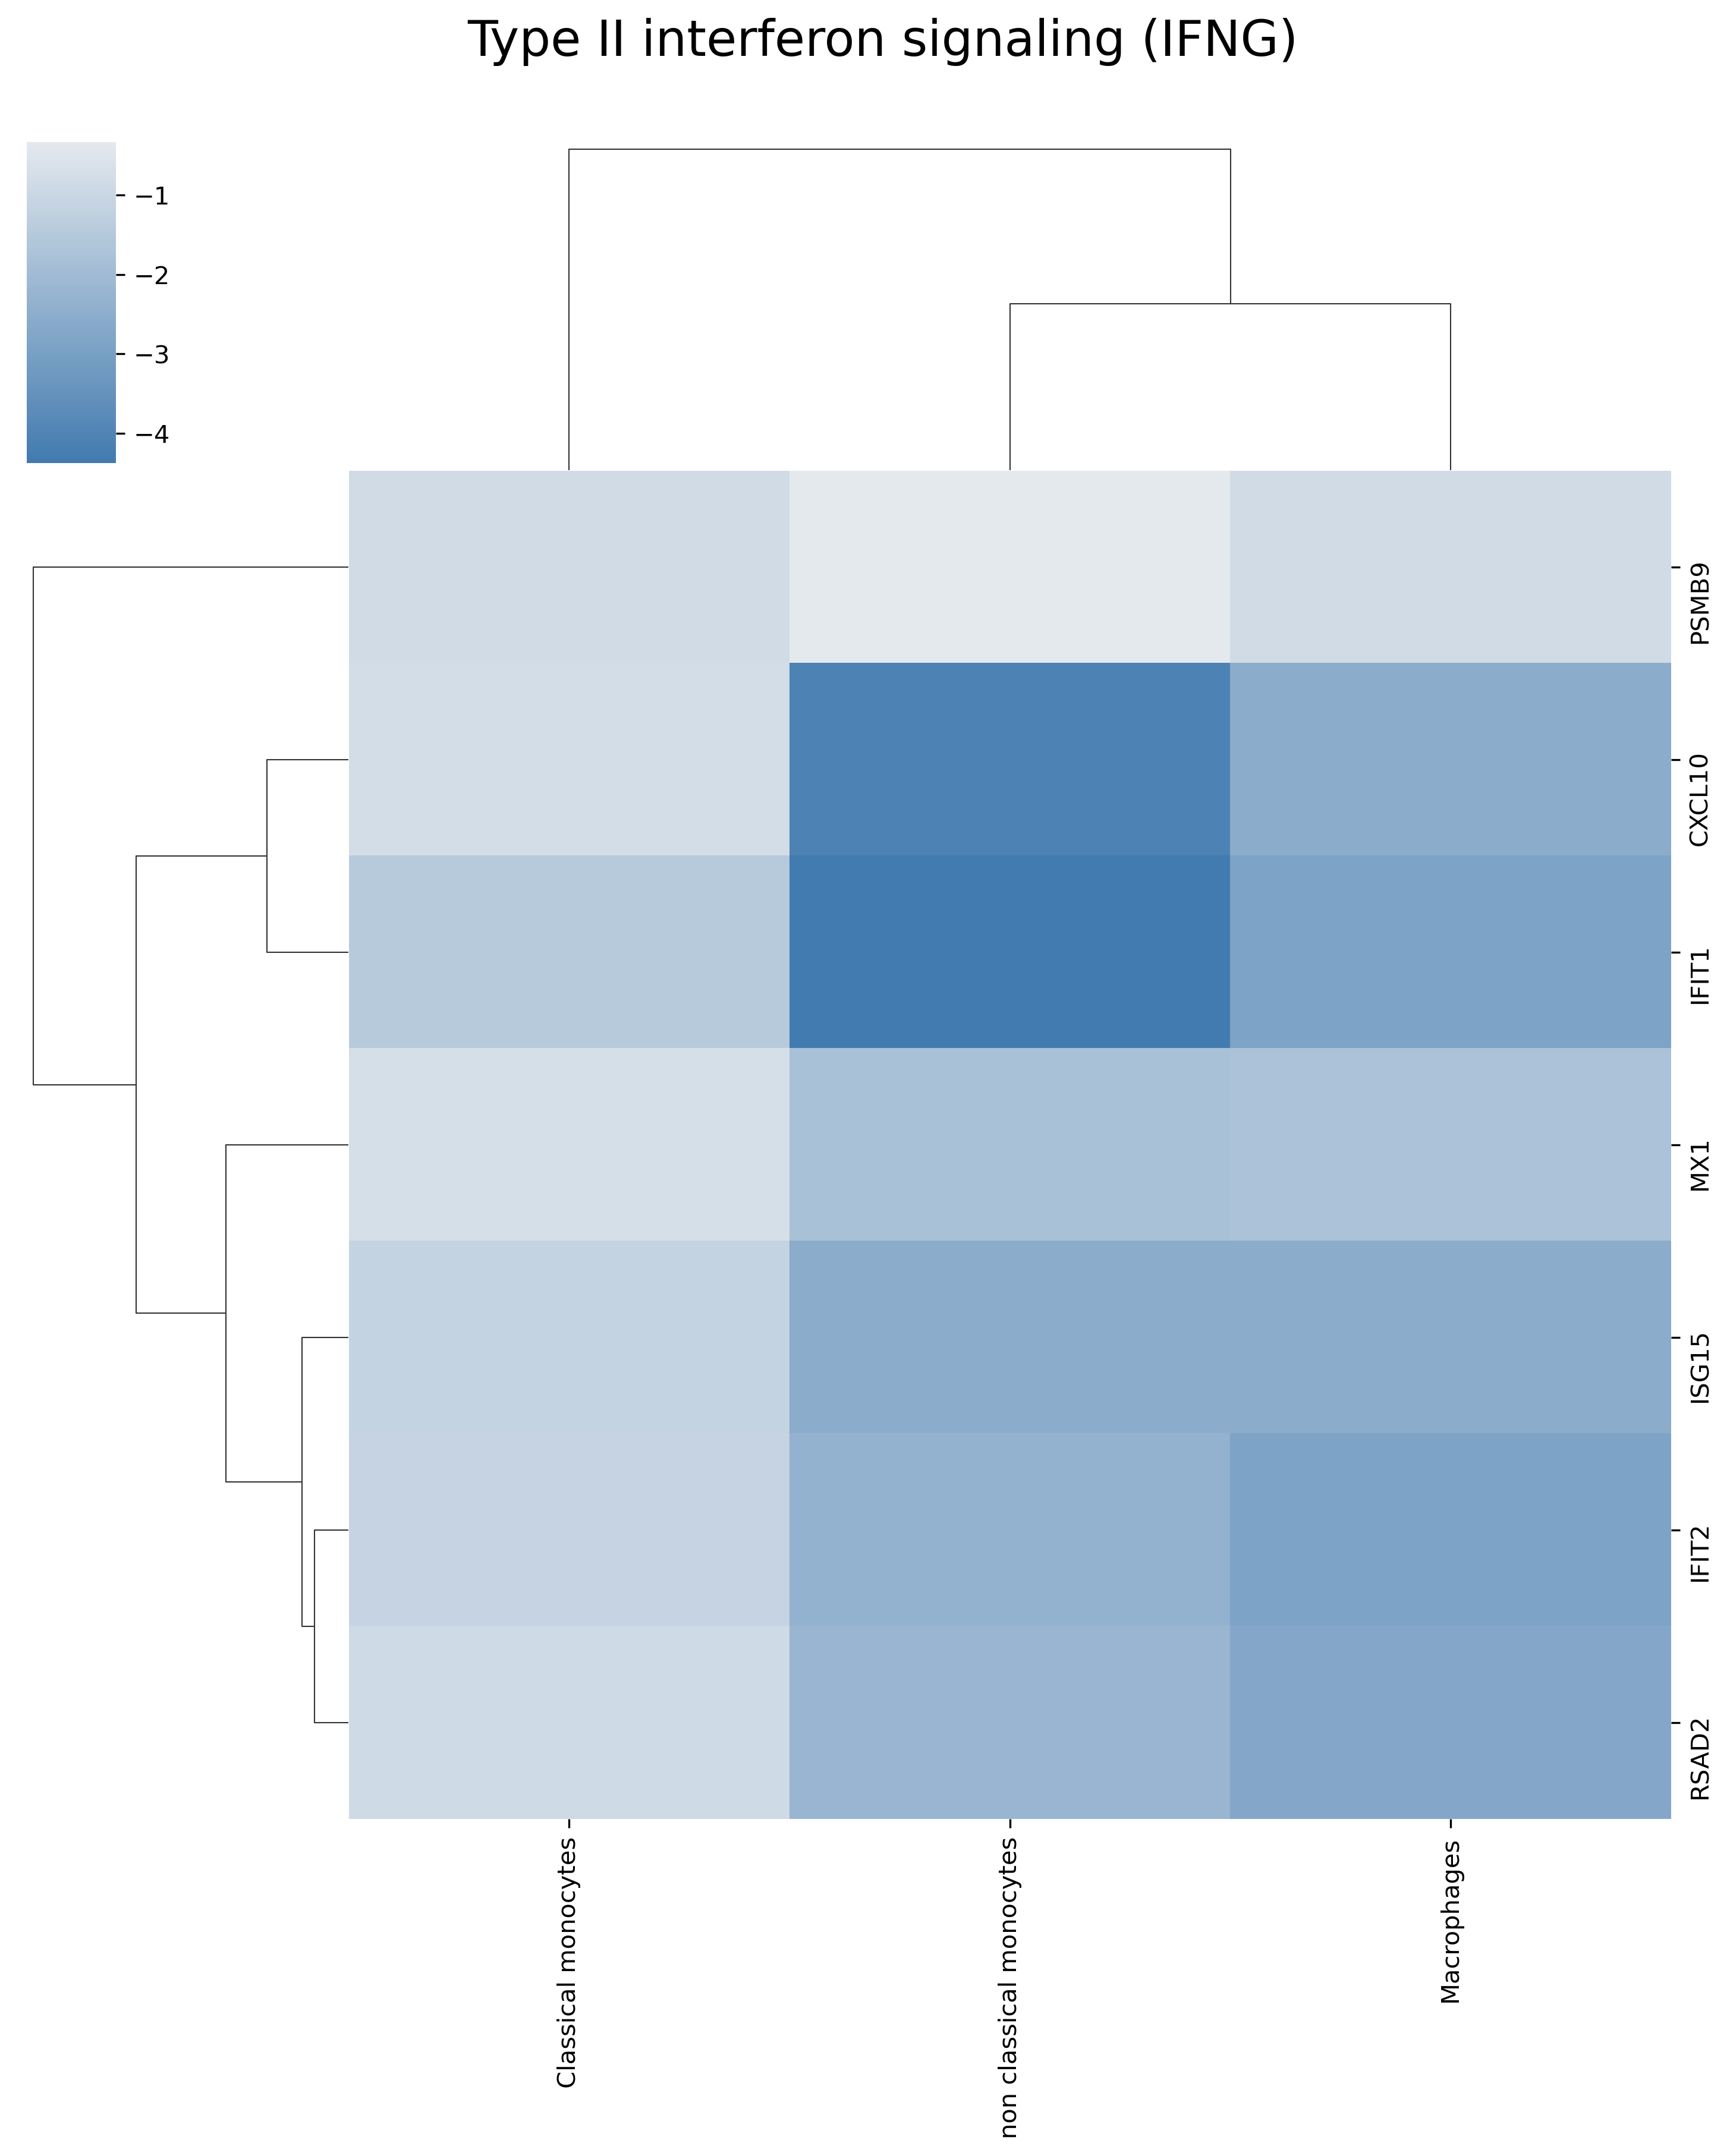

In [176]:
pathway_heatmap(subct, [gene for gene in g_list6 if gene in adata_kid.var_names], 'Type II interferon signaling (IFNG)')

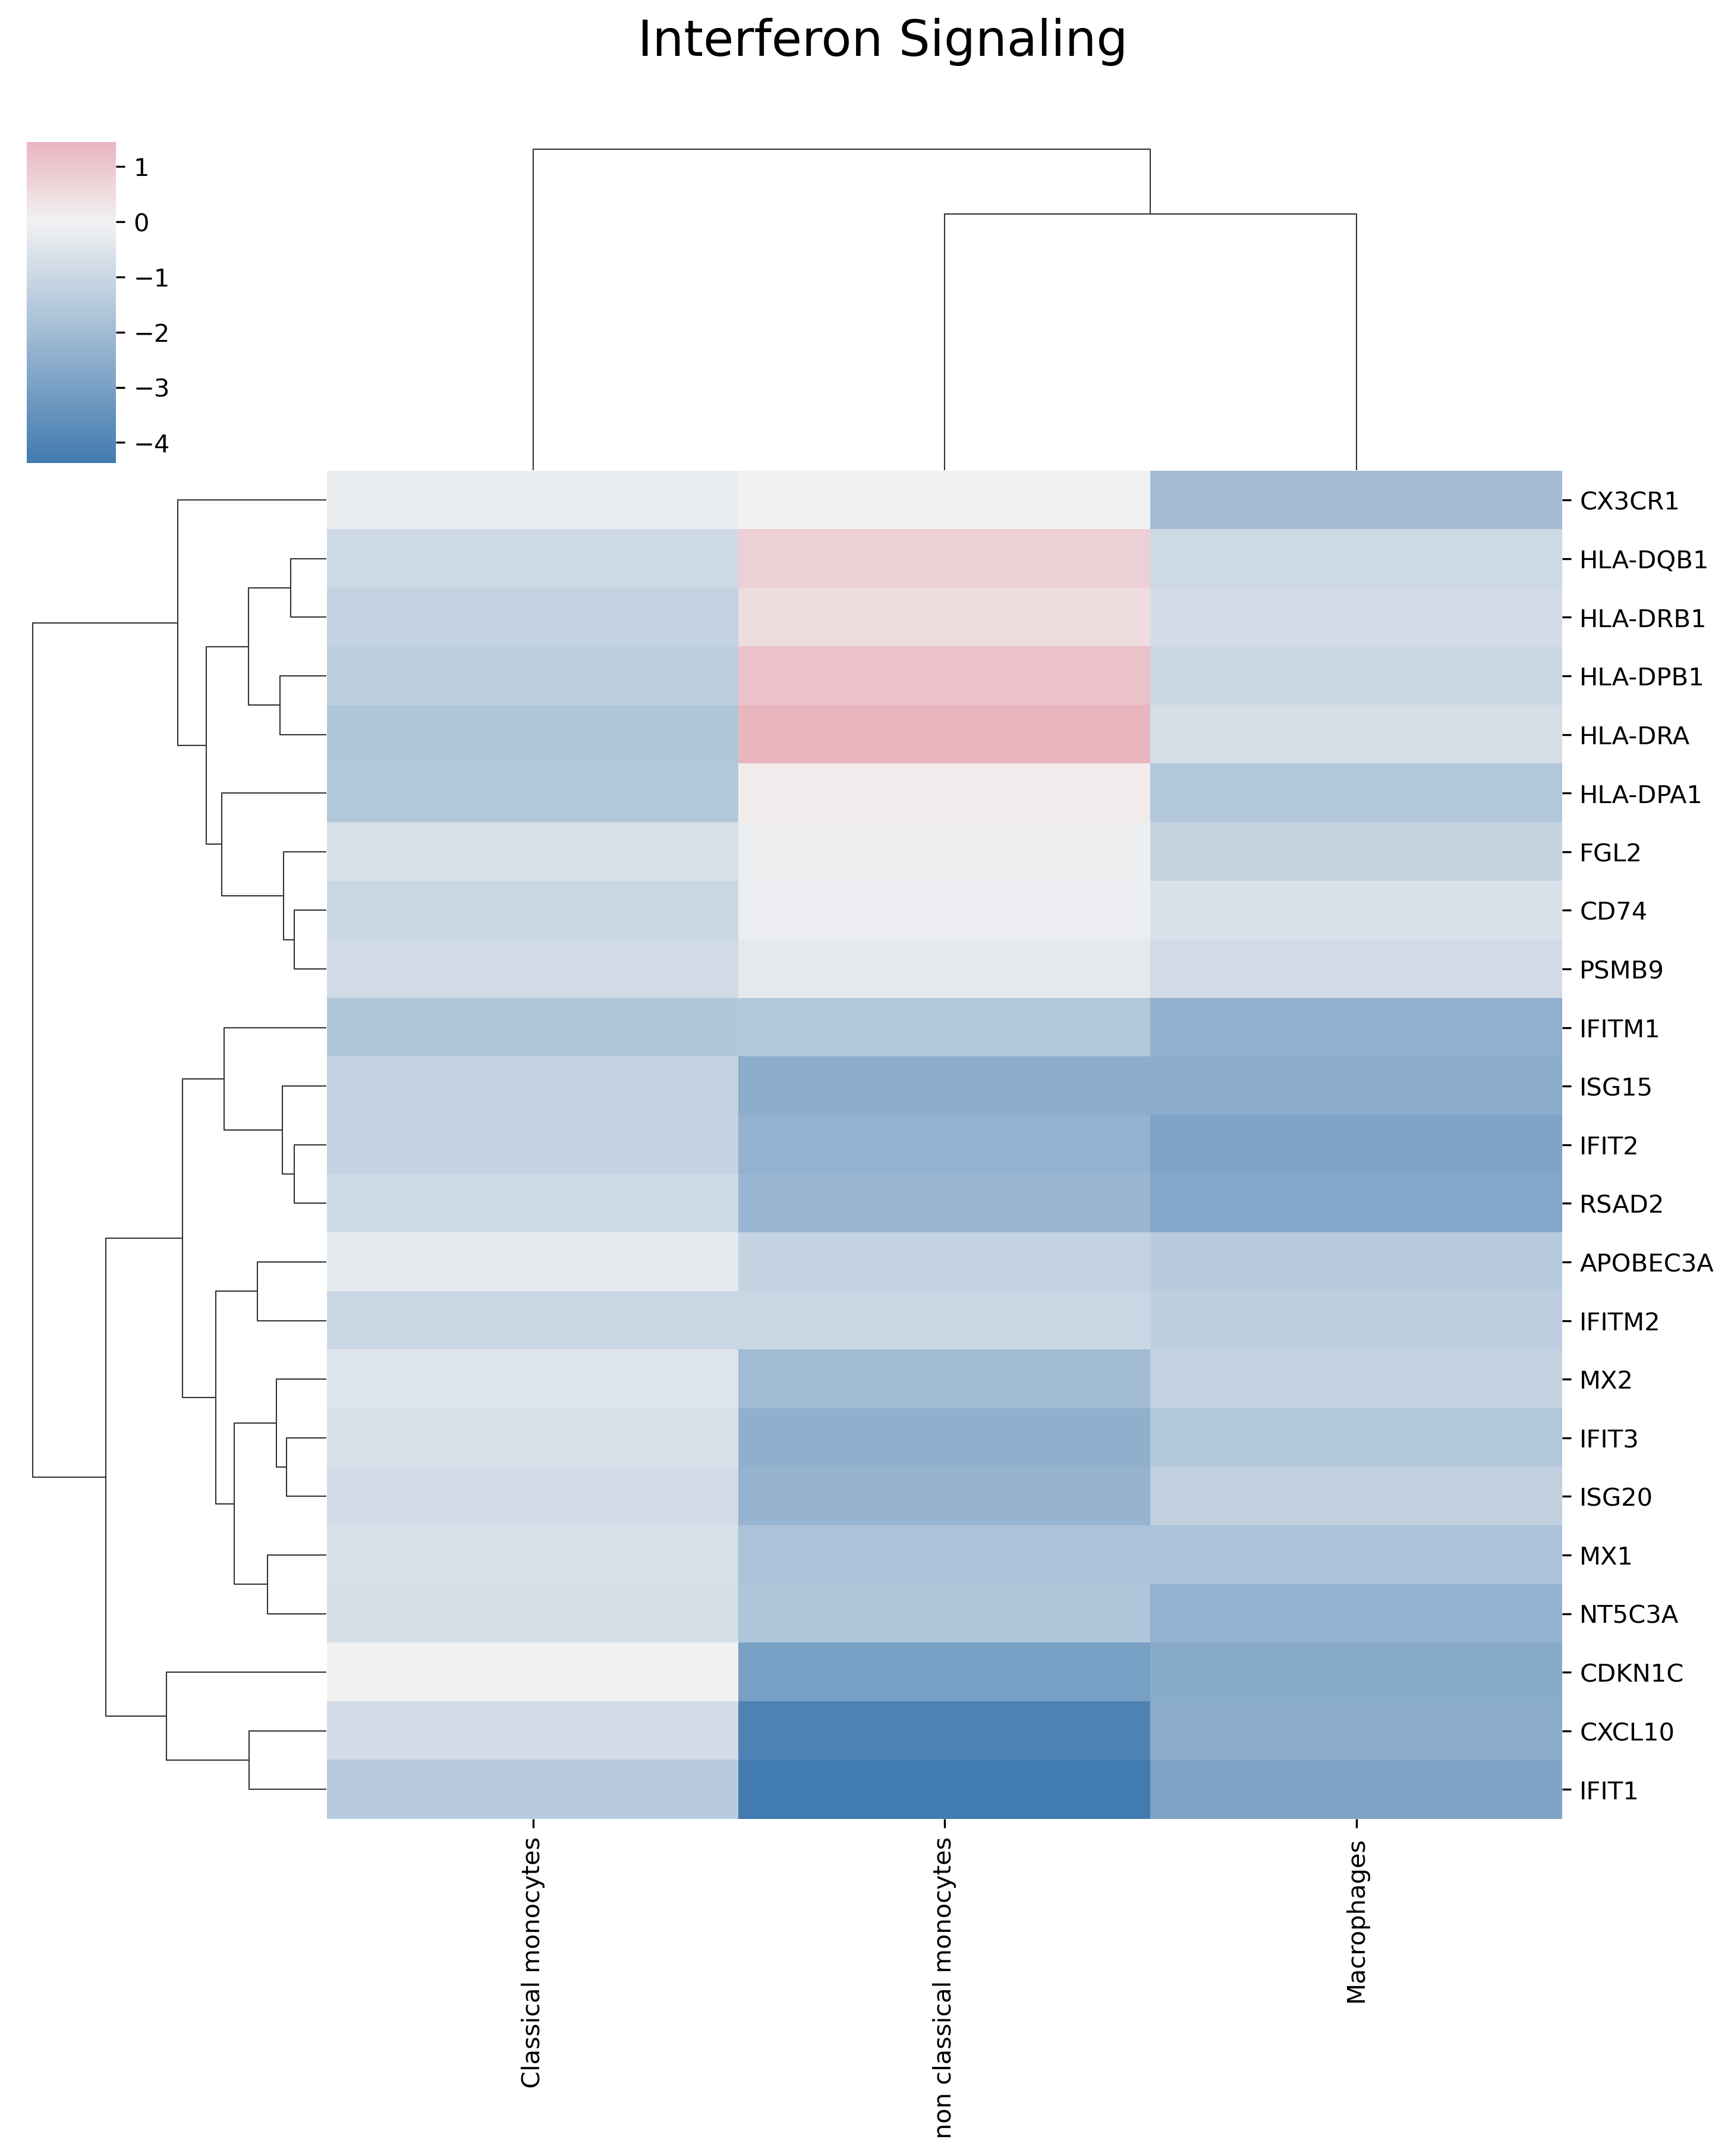

In [177]:
pathway_heatmap(subct, [gene for gene in np.unique(g_list3 + g_list5 + g_list6) if gene in adata_kid.var_names], 'Interferon Signaling')

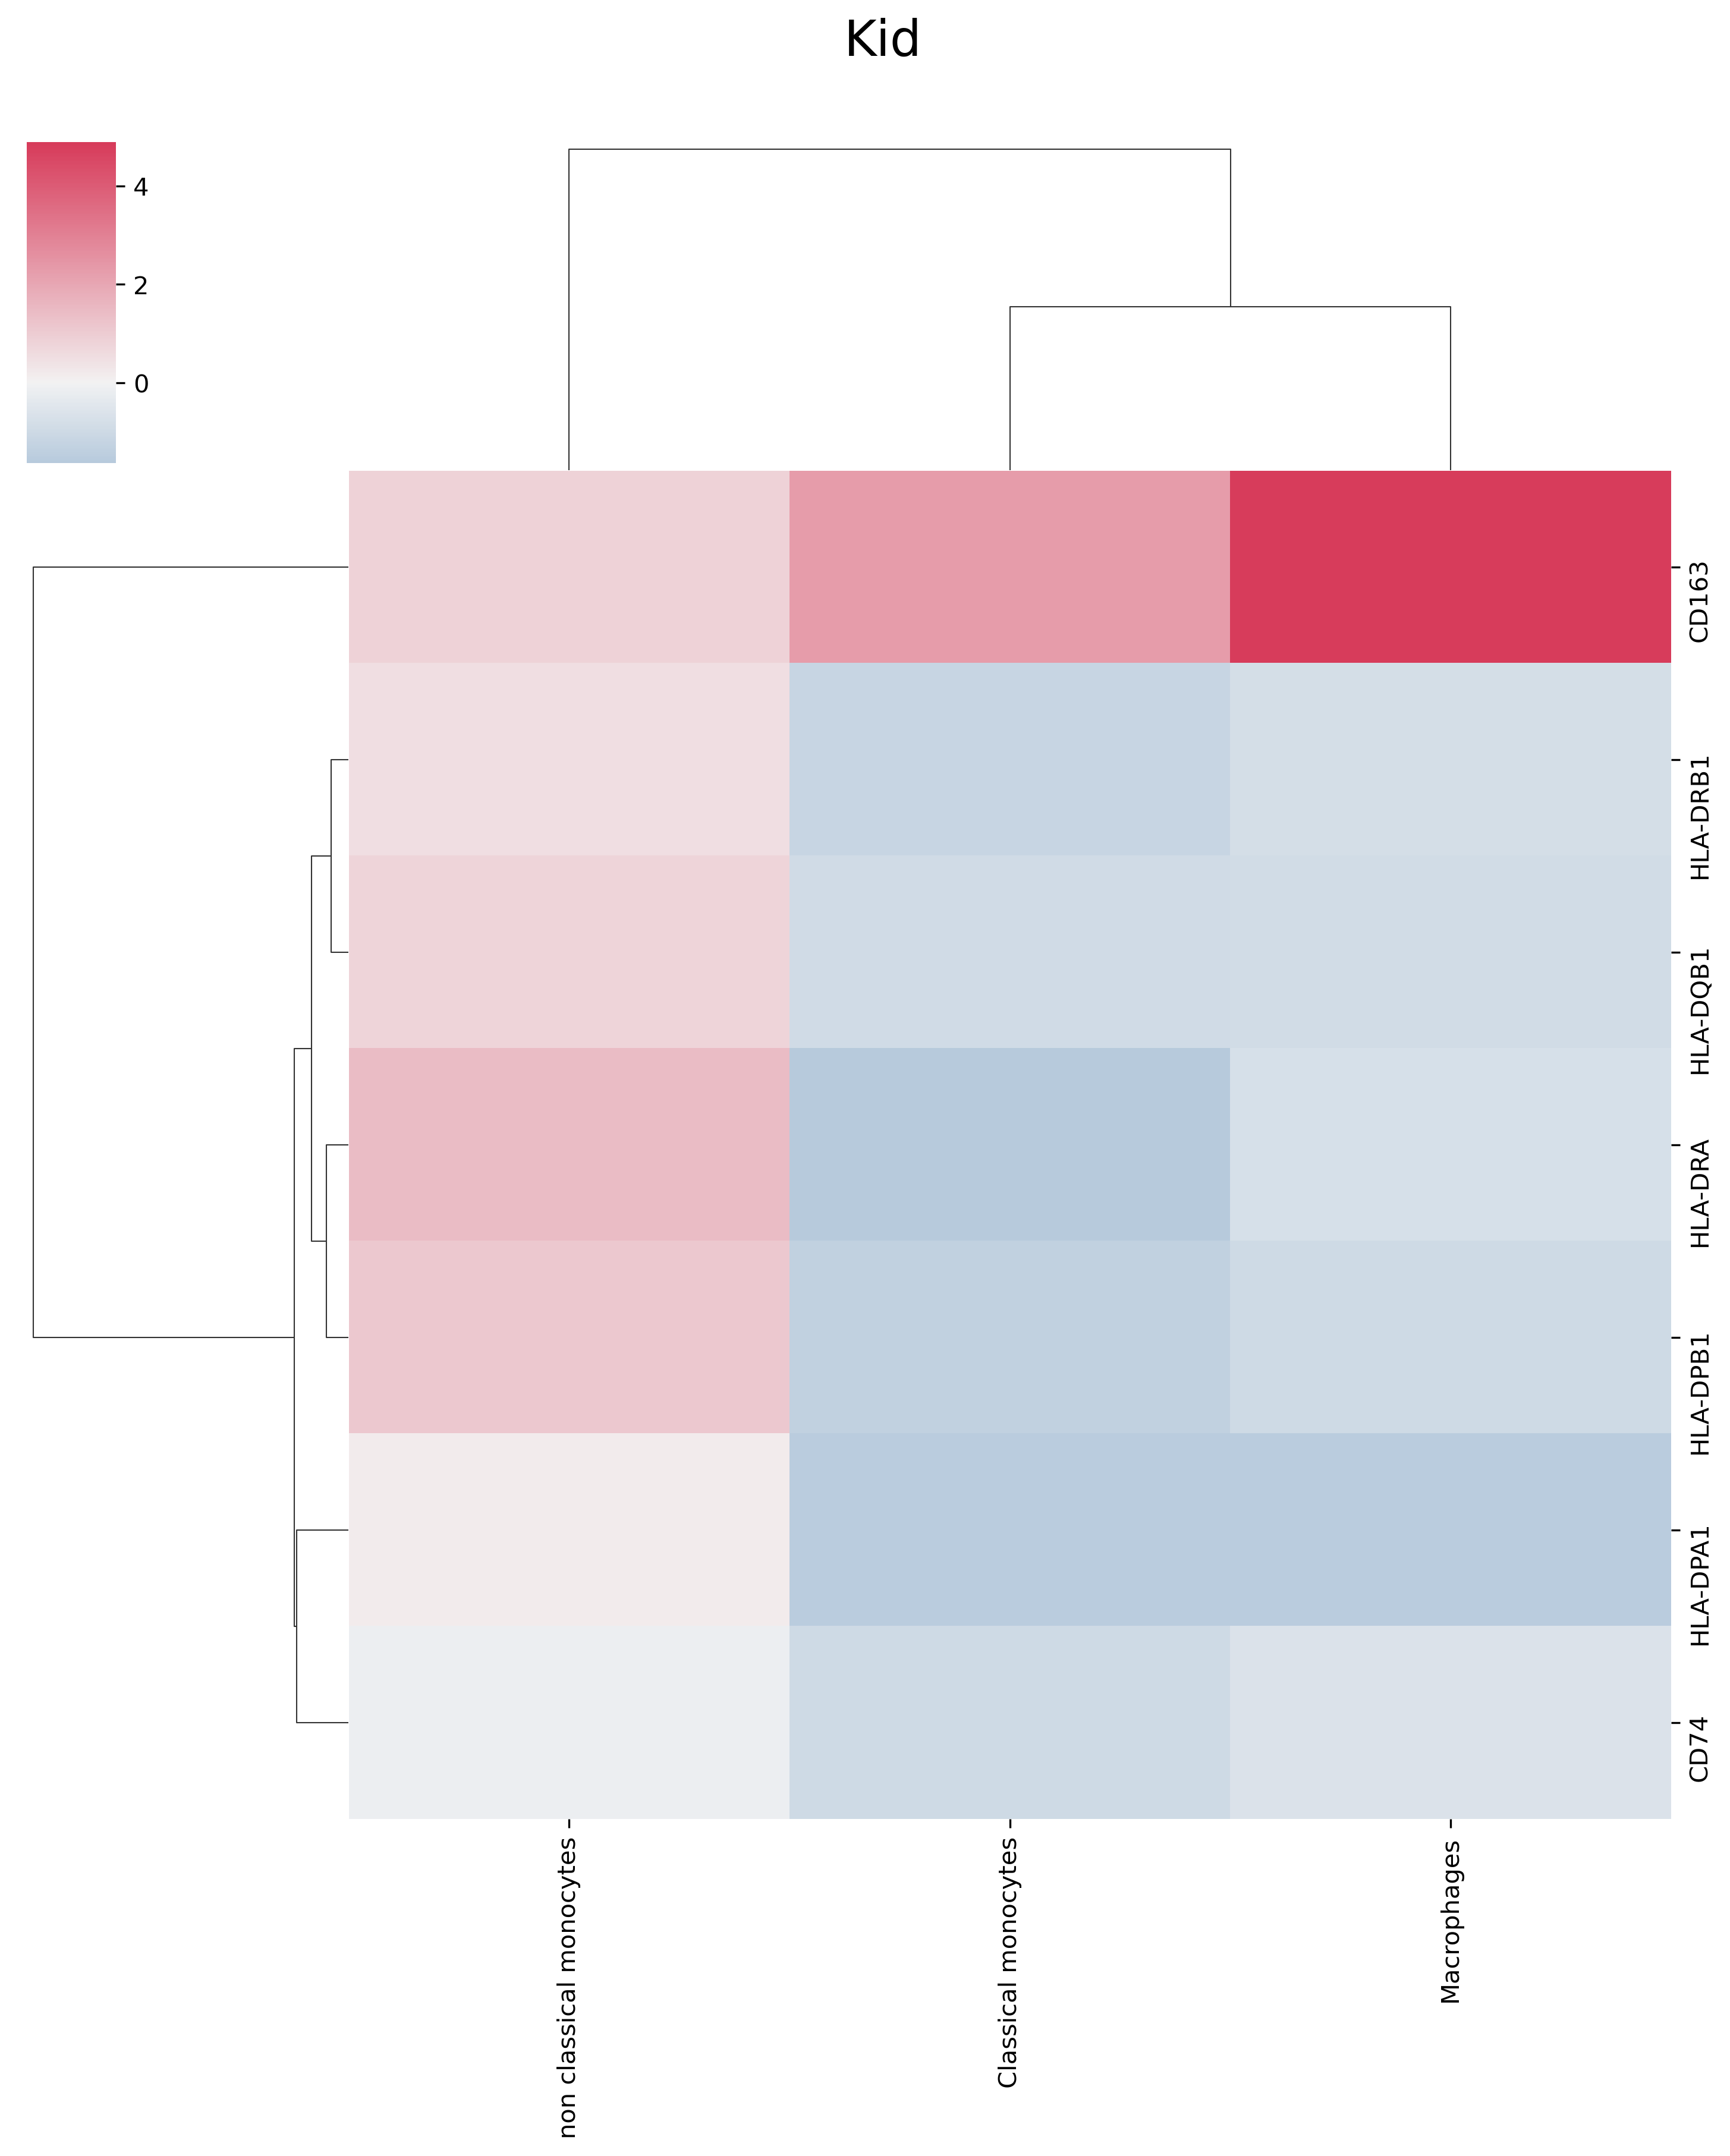

In [180]:
pathway_heatmap(subct, ['CD163', 'HLA-DRB1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DPB1', 'HLA-DPA1', 'CD74'], 'Kid')

# get 50 random pair comparession of children and adults

In [360]:
def pair_comparison(adata, cell_types, gene_cut_off, cell_cut_off, log1p=False):    
    import random
    ress = pd.DataFrame([])
    log2FC = pd.DataFrame([])
    
    cds = ['dengue', 'S_dengue']
    p_ID = 'ID'
    
    for cell_type in cell_types:
        ct_obs = 'cell_subtype_2'
        if cell_type in adata.obs['cell_type'].unique():
            ct_obs = 'cell_type'
            
        adata_ct = adata[adata.obs[ct_obs] == cell_type]
        
        ####### filter out genes expressed less than gene_cut_off in all patients
        IDs = list(adata_ct.obs['ID'].unique())
        fra = [np.asarray((adata_ct[adata_ct.obs['ID'] == ID].X > 0).mean(axis=0))[0] for ID in IDs]
        fra=pd.DataFrame(fra, index=IDs, columns=adata_ct.var_names).T
        gene_list = fra.index.tolist()
        
        if gene_cut_off is not False:
            for idx, row in fra.iterrows():
                n = 0
                for i in row.tolist():
                    if i <= gene_cut_off:
                        n += 1
                if n == len(IDs):
                    gene_list.remove(idx)
        
        adata_ct = adata_ct[:, gene_list]
        
        ####### filter out patient with less than 5 cells for the cell type
        if ct_obs == 'cell_type':
            ct = cell_type
        elif ct_obs == 'cell_subtype_2':
            ct = adata_ct.obs['cell_type'].unique()[0]
        
        for ID in IDs:
            if adata[(adata.obs['cell_type'] == ct) & (adata.obs[p_ID] == ID)].obs.shape[0] < cell_cut_off:
                IDs.remove(ID)
        adata_ct = adata_ct[adata_ct.obs[p_ID].isin(IDs)]
        
        adata_S_ct = adata_ct[adata_ct.obs['Condition'] == cds[1]]
        adata_NS_ct = adata_ct[adata_ct.obs['Condition'] == cds[0]]
        
        IDs_S = list(adata_S_ct.obs[p_ID].unique())
        IDs_NS = list(adata_NS_ct.obs[p_ID].unique())
                
        ####### pair comparison
        log2_fc = []
        for ID_S in IDs_S:
            adata_S_ID = adata_S_ct[adata_S_ct.obs[p_ID] == ID_S]
            
            for ID_NS in IDs_NS:
                adata_NS_ID = adata_NS_ct[adata_NS_ct.obs[p_ID] == ID_NS]

                X_S = adata_S_ID.X
                X_NS = adata_NS_ID.X
                avg_S = np.asarray(X_S.mean(axis=0))[0]
                avg_NS = np.asarray(X_NS.mean(axis=0))[0]

                if log1p is False:
                    log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))
                elif log1p not in (True, 2):
                    log2_fc.append((avg_S - avg_NS) / np.log2(log1p))
                else:
                    log2_fc.append(avg_S - avg_NS)

        log2_fc = np.asarray(log2_fc)
        
        if log2_fc.size == 0:
            continue
        med_pair = np.median(log2_fc, axis=0)
        fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

        res = pd.DataFrame([], index=adata_ct.var_names)
        res['med_pair'] = med_pair
        res['fra_pair'] = fra_pair
        res['cell_subtype'] = cell_type
        ress = pd.concat([ress, res], join='outer')
        ress['gene'] = ress.index.tolist()

        FCs = pd.DataFrame(log2_fc, columns = adata_ct.var_names, index=[cell_type] * log2_fc.shape[0])
        log2FC = pd.concat([log2FC, FCs], join='outer')
        
    return {'pair_res': ress, 'log_FCs': log2FC}

In [425]:
def log2_fold_change(adata, cell_types, log1p=False):
    
    log2FC = pd.DataFrame([])
    for cell_type in cell_types:
        ct_obs = 'cell_subtype_2'
        if cell_type in adata.obs['cell_type'].unique():
            ct_obs = 'cell_type'
 
            adata_S = adata[(adata.obs[ct_obs] == cell_type) & (adata.obs['Condition'] == 'S_dengue')]
            adata_NS = adata[(adata.obs[ct_obs] == cell_type) & (adata.obs['Condition'] == 'dengue')]

            X_S = adata_S.X
            X_NS = adata_NS.X
            avg_S = np.asarray(X_S.mean(axis=0))[0]
            avg_NS = np.asarray(X_NS.mean(axis=0))[0]

            if log1p is False:
                log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))
            elif log1p not in (True, 2):
                log2_fc.append((avg_S - avg_NS) / np.log2(log1p))
            else:
                log2_fc.append(avg_S - avg_NS)

        FCs = pd.DataFrame(log2_fc, columns = adata_ct.var_names, index=[cell_type] * len(log2_fc))
        log2FC = pd.concat([log2FC, FCs])
    return log2_FC

In [345]:
#pair comparison generation for kids
cts = adata_kid.obs['cell_type'].unique().tolist()
pair = pair_comparison(adata_kid, cts, gene_cut_off=0.1, cell_cut_off=5, log1p=2)

pair['pair_res'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/ct_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/ct_log2FC.tsv', sep='\t')

In [346]:
#pair comparison generation for kids monocyte subtype
csts = adata_kid.obs['cell_subtype_2'].unique().tolist()
csts.remove('doublets')
csts.remove('pDCs')
pair = pair_comparison(adata_kid, csts, gene_cut_off=0.1, cell_cut_off=5, log1p=2)

pair['pair_res'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/cst_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/cst_log2FC.tsv', sep='\t')

In [427]:
cts = ['Monocytes', 'B_cells', 'T_cells']
pair = pair_comparison(adata_adult, cts, gene_cut_off=0.1, cell_cut_off=5, log1p=2)

pair['pair_res'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/adult_ct_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/adult_ct_log2FC.tsv', sep='\t')

In [429]:
def pairwise_boxplot(data, genes, title, path=False):
    box_data = data[genes]
    box_data = pd.melt(box_data)
    
    fig, ax = plt.subplots(dpi=300)
    medians = np.median(np.asarray(data[genes]), axis=0)
    colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]

    sns.boxplot(data = box_data, y = 'variable', x = 'value', palette = colors, orient = 'h', ax=ax)
    yticklabels = [label.get_text().split('_')[0] for label in ax.get_yticklabels()]

    ax.set(xlabel = 'diff log2 fold change', ylabel = None, xlim = (-7.5, 7.5), title = title, yticklabels=yticklabels)
    ax.axvline(0, c='black', ls='--')
    
    if path is not False:
        fig.savefig(path, bbox_inches='tight')
        
    return {'figure': fig, 'ax': ax}

In [6]:
pair_kid = pd.read_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/ct_pair.tsv', sep='\t', index_col='cell_subtype')
log2fc_kid = pd.read_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/ct_log2FC.tsv', sep='\t', index_col=0)

pair_adult = pd.read_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/adult_ct_pair.tsv', sep='\t', index_col='cell_subtype')
log2fc_adult = pd.read_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/adult_ct_log2FC.tsv', sep='\t', index_col=0)

In [213]:
up_mono = pair_kid.loc['Monocytes'].sort_values('med_pair', ascending=False).head(10)['gene'].tolist()
down_mono = pair_kid.loc['Monocytes'].sort_values('med_pair', ascending=False).tail(10)['gene'].tolist()

<ipython-input-271-0c6070fce0ef>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]


{'figure': <Figure size 1800x1200 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Upregulated genes in the SD group'}, xlabel='diff log2 fold change'>}

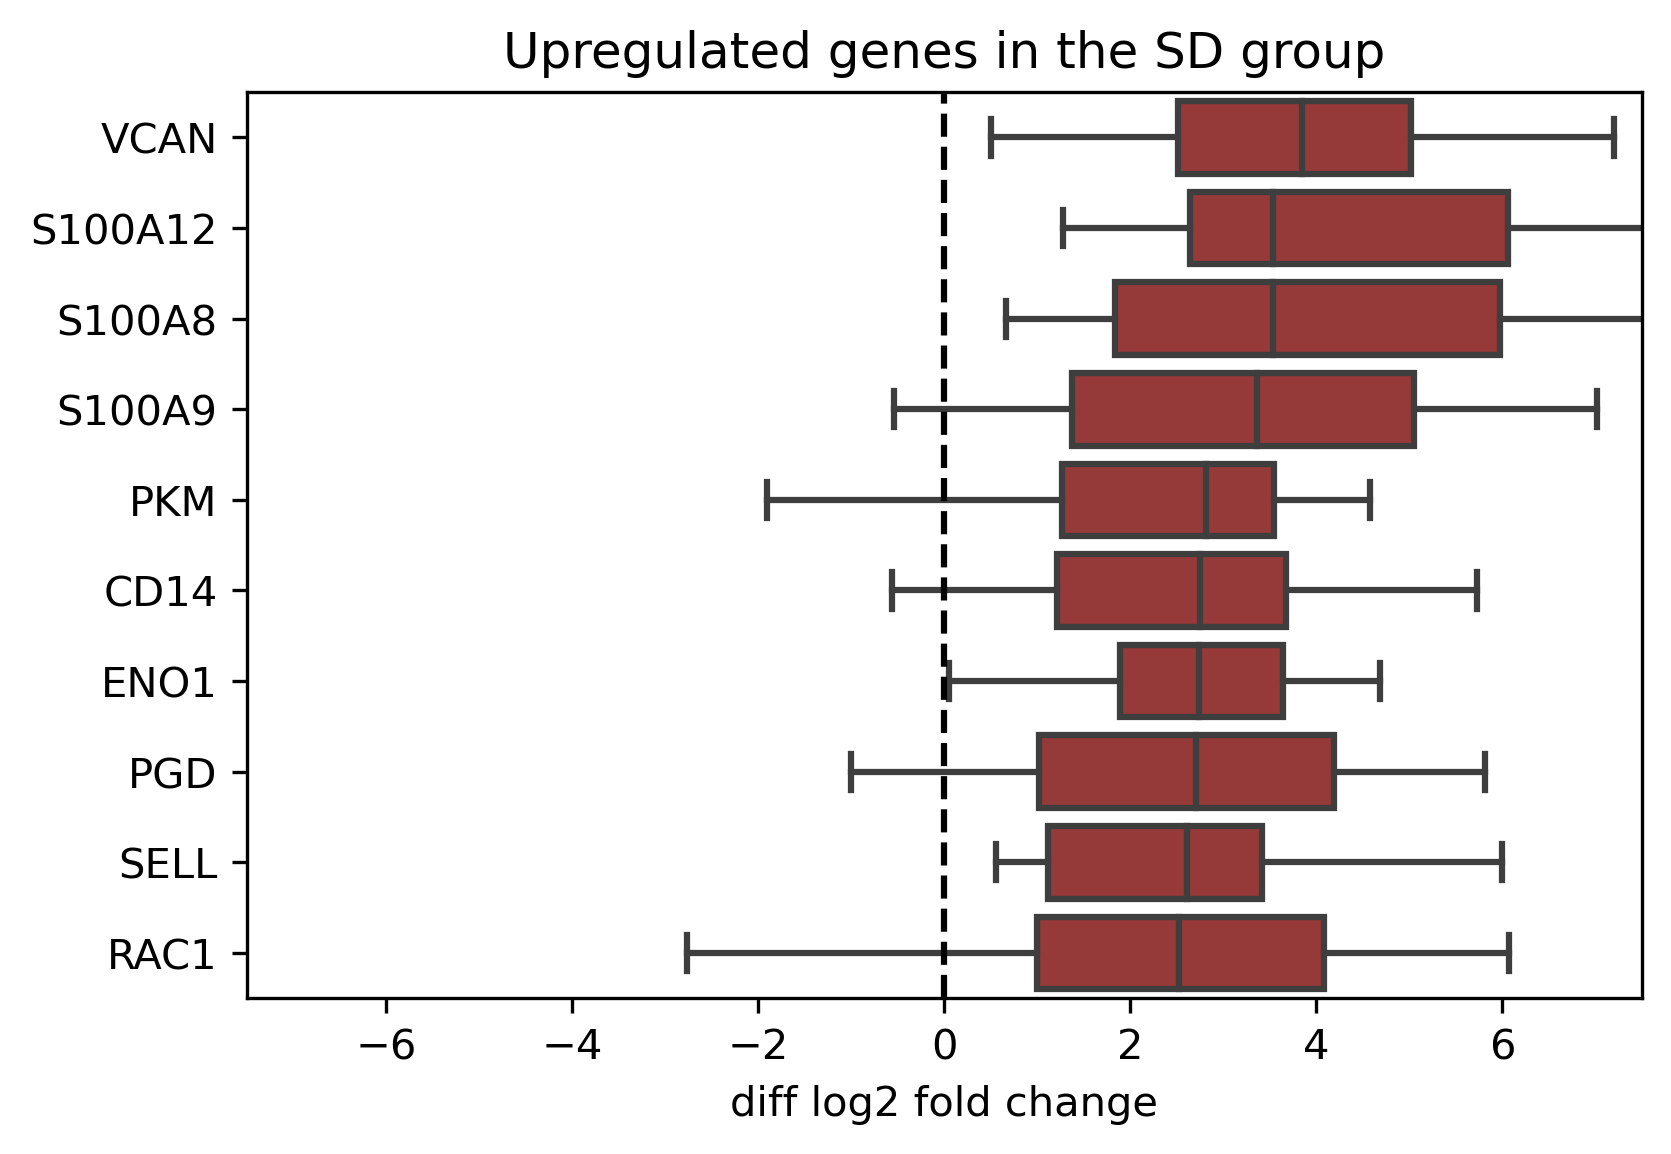

In [272]:
pairwise_boxplot(log2fc_kid.loc['Monocytes'], up_mono, 'Upregulated genes in the SD group', path=save_fdn + 'Upregulated genes in SD monocytes.png')

<ipython-input-271-0c6070fce0ef>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]


{'figure': <Figure size 1800x1200 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Downregulated genes in the SD group'}, xlabel='diff log2 fold change'>}

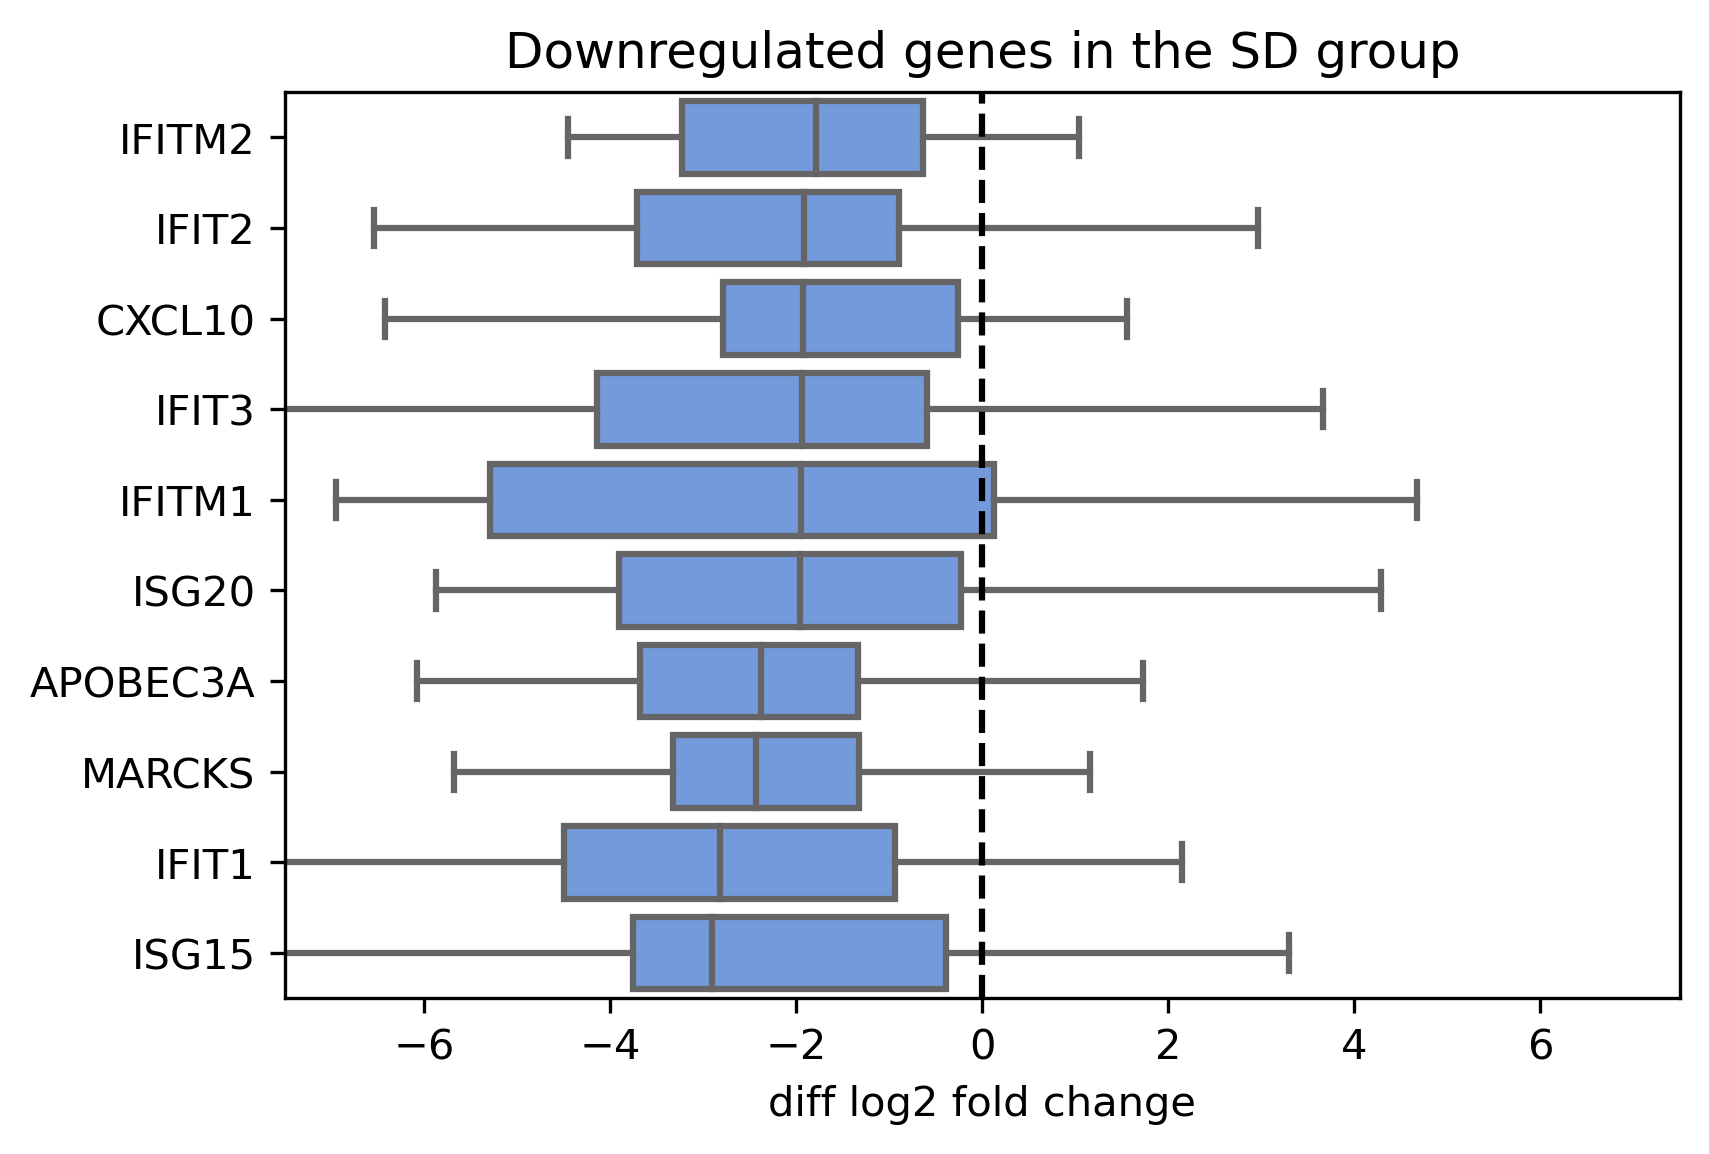

In [273]:
pairwise_boxplot(log2fc_kid.loc['Monocytes'], down_mono, 'Downregulated genes in the SD group', path=save_fdn + 'Downregulated genes in SD monocytes.png')

<ipython-input-271-0c6070fce0ef>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]


{'figure': <Figure size 1800x1200 with 1 Axes>,
 'ax': <AxesSubplot:xlabel='diff log2 fold change'>}

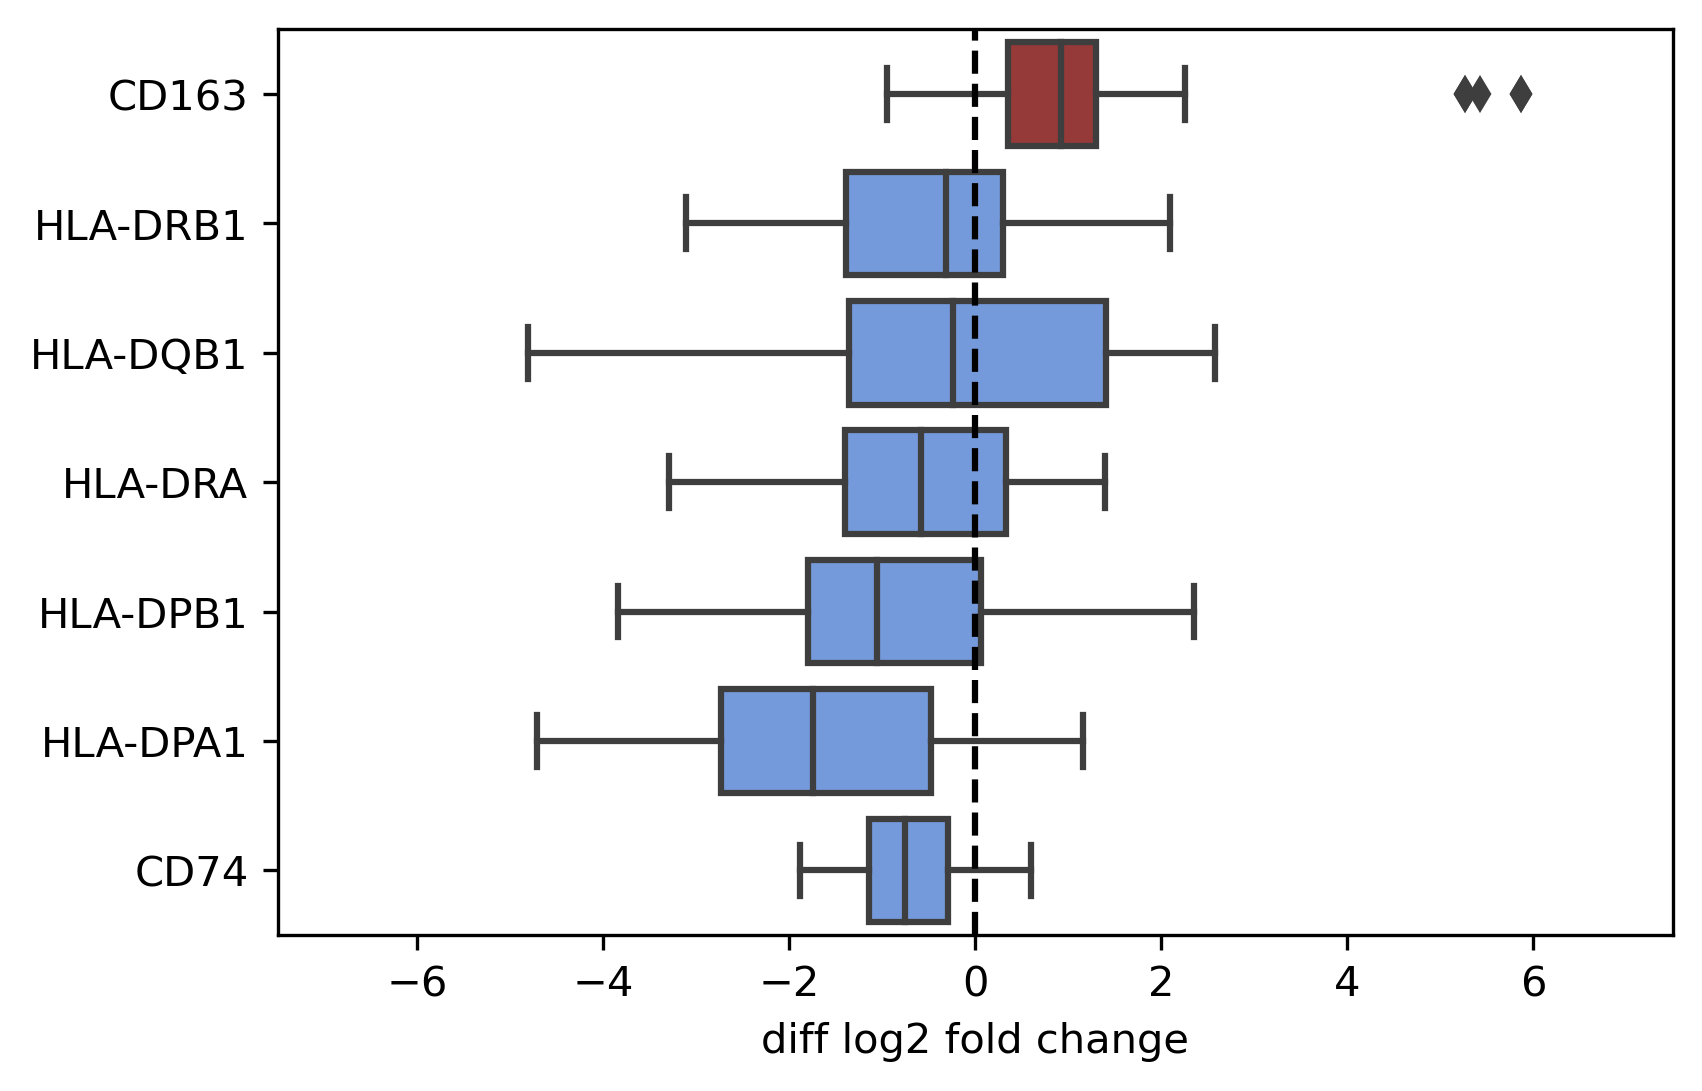

In [274]:
pairwise_boxplot(log2fc_kid.loc['Monocytes'], ['CD163', 'HLA-DRB1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DPB1', 'HLA-DPA1', 'CD74'], None, path=save_fdn + 'MHC class II in children.png')

<ipython-input-429-fa26da97780a>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]


{'figure': <Figure size 1800x1200 with 1 Axes>,
 'ax': <AxesSubplot:xlabel='diff log2 fold change'>}

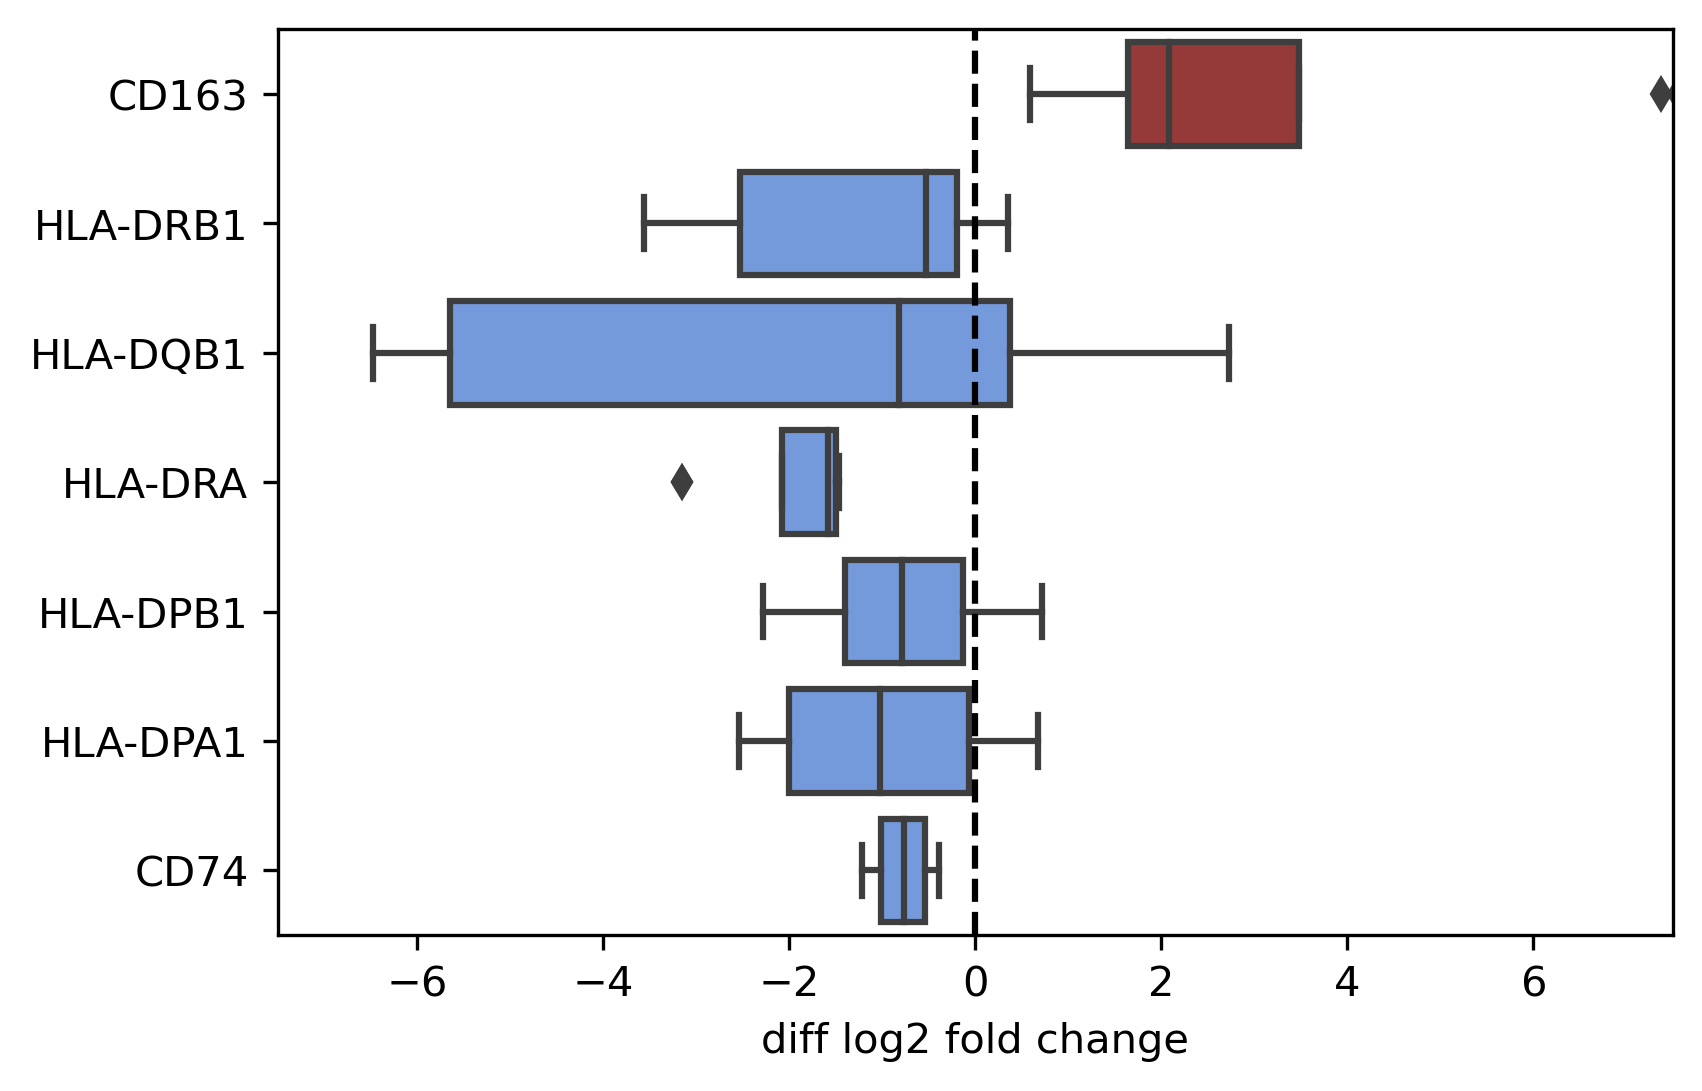

In [431]:
pairwise_boxplot(log2fc_adult.loc['Monocytes'], ['CD163', 'HLA-DRB1_4', 'HLA-DQB1_2', 'HLA-DRA_5', 'HLA-DPB1', 'HLA-DPA1', 'CD74'], None, path=save_fdn + 'MHC class II in adults.png')

# The scatter plot showing DEGs (SD vs D) between children and adults using pair comparison

In [13]:
#Fabio's function
def draw_8_slices(ax, center, radius=1.0):
    def cp(amin, amax, center, ndots=100):
            xc, yc = center
            angles = np.linspace(amin, amax, ndots)
            xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
            return [(xi, yi) for xi, yi in zip(xcircs, ycircs)][::-1]

    def draw_wedge(ax, points, color):
            points = np.array(points)
            center = points.mean(axis=0)
            delta = points - center
            points = center + 0.99 * delta

            rgb = list(mpl.colors.to_rgba(color)[:-1])
            rgba_edge = tuple(rgb + [0.6])
            rgba_fill = tuple(rgb + [0.2])
            ax.add_artist(plt.Polygon(
                points, edgecolor=rgba_edge, facecolor=rgba_fill, lw=2,
                clip_on=False,
                ))

    xc, yc = center
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Cross
    ax.axvline(xc, ls='--', color='k')
    ax.axhline(yc, ls='--', color='k')

    # Circle
    rgb = list(mpl.colors.to_rgba('grey'))[:-1]
    circle = plt.Circle(center, radius, facecolor=tuple(rgb + [0.2]), edgecolor='k')
    ax.add_artist(circle)

    # Wedges
    # 1. intersections with circle
    angles = np.array([np.arcsin(1/radius), np.arccos(1/radius), np.pi-np.arccos(1/radius), np.pi - np.arcsin(1/radius),
                               np.pi+np.arcsin(1/radius), np.pi+np.arccos(1/radius), 2*np.pi-np.arccos(1/radius), 2*np.pi-np.arcsin(1/radius)])

    xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
    circs = np.vstack([xcircs, ycircs]).T
    # 2. Intersections with axes border
    xbords, ybords = [], []
    xbords.append(xmax)
    ybords.append(yc + 1)
    xbords.append(xc + 1)
    ybords.append(ymax)
    xbords.append(xc - 1)
    ybords.append(ymax)
    xbords.append(xmin)
    ybords.append(yc + 1)
    xbords.append(xmin)
    ybords.append(yc - 1)
    xbords.append(xc - 1)
    ybords.append(ymin)
    xbords.append(xc + 1)
    ybords.append(ymin)
    xbords.append(xmax)
    ybords.append(yc - 1)

    bords = np.vstack([xbords, ybords]).T

    # 3. draw wedges
    draw_wedge(ax, [circs[0], bords[0], (xmax, ymax), bords[1], circs[1]] + cp(angles[0], angles[1], center), color='purple')
    draw_wedge(ax, [circs[1], bords[1], bords[2], circs[2]] + cp(angles[1], angles[2], center), color='grey')
    draw_wedge(ax, [circs[2], bords[2], (xmin, ymax), bords[3], circs[3]] + cp(angles[2], angles[3], center), color='dodgerblue')
    draw_wedge(ax, [circs[3], bords[3], bords[4], circs[4]] + cp(angles[3], angles[4], center), color='lawngreen')
    draw_wedge(ax, [circs[4], bords[4], (xmin, ymin), bords[5], circs[5]] + cp(angles[4], angles[5], center), color='orange')
    draw_wedge(ax, [circs[5], bords[5], bords[6], circs[6]] + cp(angles[5], angles[6], center), color='grey')
    draw_wedge(ax, [circs[6], bords[6], (xmax, ymin), bords[7], circs[7]] + cp(angles[6], angles[7], center), color='tomato')
    draw_wedge(ax, [circs[7], bords[7], bords[0], circs[0]] + cp(angles[7], 2*np.pi+angles[0], center), color='pink')
    

def scatter_pairwise_processing(df_kid, df_adult):
    df_kid, df_adult = pair_kid.loc['Monocytes'], pair_adult.loc['Monocytes']
    df_kid.set_index('gene', inplace=True)
    df_adult.set_index('gene', inplace=True)
    
    ###### merge two df
    intersect = [x for x in df_kid.index if x in df_adult.index]
    df_adult.columns = [col+'_a' for col in df_adult.columns]
    df = pd.concat([df_kid.loc[intersect], df_adult.loc[intersect]], axis=1)
    
    ###### define robost genes for kids, adults or both
    ind_kid = df[(df['fra_pair'] >= 0.7) | (df['fra_pair'] <= 0.3)].index
    ind_adult = df[(df['fra_pair_a'] >= 0.7) | (df['fra_pair_a'] <= 0.3)].index
    ind_merge = list(set(ind_kid) & set(ind_adult))
    
    df['outlier'] = 'no'
    df.loc[ind_kid, 'outlier'] = 'kid_only'
    df.loc[ind_adult, 'outlier'] = 'adult_only'
    df.loc[ind_merge, 'outlier'] = 'both'
    
    ###### calculate marker and distance
    df['x_kid'] = df['med_pair'] - df['med_pair'].mean()
    df['y_adult'] = df['med_pair_a'] - df['med_pair_a'].mean()
    df['r'] = np.sqrt(df['x_kid'] ** 2 + df['y_adult'] ** 2)
    
    ###### set markers for genes
    df_2 = df[df['r'] >= df['r'].quantile(q = 0.95)]
    r = df_2.sort_values('r').iloc[0]['r']
    
    df['markers'] = 'no'
    df.loc[df_2[(df_2['x_kid'] > 1) & (df_2['y_adult'] > -1)].index, 'markers'] = '1'
    df.loc[df_2[(df_2['x_kid'] < -1) & (df_2['y_adult'] > -1)].index, 'markers'] = '2'
    df.loc[df_2[(df_2['x_kid'] < -1) & (df_2['y_adult'] < -1)].index, 'markers'] = '3'
    df.loc[df_2[(df_2['x_kid'] > 1) & (df_2['y_adult'] < -1)].index, 'markers'] = '4'
    
    df['new_markers'] = 'no'
    df.loc[df_2[(df_2['x_kid'] > 1) & (df_2['y_adult'] > 1)].index, 'new_markers'] = '1'
    df.loc[df_2[(df_2['x_kid'] < -1) & (df_2['y_adult'] > 1)].index, 'new_markers'] = '2'
    df.loc[df_2[(df_2['x_kid'] < -1) & (-1 < df_2['y_adult']) & (df_2['y_adult'] < 1)].index, 'new_markers'] = '3'
    df.loc[df_2[(df_2['x_kid'] < -1) & (df_2['y_adult'] < -1)].index, 'new_markers'] = '4'
    df.loc[df_2[(df_2['x_kid'] > 1) & (df_2['y_adult'] < -1)].index, 'new_markers'] = '5'
    df.loc[df_2[(df_2['x_kid'] > 1) & (-1 < df_2['y_adult']) & (df_2['y_adult'] < 1)].index, 'new_markers'] = '6'
    
    return (df, r)

def scatter_pairwise(df, r, marklist, name=False):
    ###### plot scatter_pairwise
    import matplotlib as mpl

    fig, ax = plt.subplots(figsize=(16, 16))
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42

    sns.scatterplot(data=df, x='med_pair', y='med_pair_a', ax=ax, hue='markers', 
                    hue_order=['1', '2', '3', '4', 'no'],
                    palette=['red', 'purple', 'orange', 'blue', 'grey'], edgecolor=None)
    sns.kdeplot(data=df, x='med_pair', y='med_pair_a', ax=ax)

    x_mean = df['med_pair'].mean()
    y_mean = df['med_pair_a'].mean()
    ax.axvline(x=x_mean, ls = '--', c = 'black', lw = 2)
    ax.axhline(y=y_mean, ls = '--', c = 'black', lw = 2)

    mark_list = marklist
    for gene in mark_list:
        ax.text(df.loc[gene, 'med_pair']-0.6, 
        df.loc[gene, 'med_pair_a'] + 0.005,
        gene, color = 'black',
        fontsize = 14)

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    # Draw 8 slices using Fabio's function  
    draw_8_slices(ax, (x_mean, y_mean), radius=r)
    ax.set_xlabel('diff log2 fold change kid')
    ax.set_ylabel('diff log2 fold change adult')

    ax.set_title('SD vs D')
    ax.get_legend().remove()
    
    if name is not False:
        filename = save_fdn + name
        fig.savefig(filename, bbox_inches = 'tight')
    
    return {'figure': fig, 'ax': ax}

In [8]:
df, r = scatter_pairwise_processing(pair_kid.loc['Monocytes'], pair_adult.loc['Monocytes'])

In [10]:
mark_list = []
for m in ['1', '2', '3', '4', '5', '6']:   
    mark_list += df[df['new_markers'] == m].sort_values('r', ascending=False).head(2).index.tolist()
mark_list

['RNASE2',
 'CD99',
 'IFIT1',
 'COL6A3',
 'MARCKS',
 'IFITM1',
 'HLA-DRB5',
 'CALHM6',
 'S100A8',
 'CXCL8',
 'S100A12',
 'VCAN']

{'figure': <Figure size 1152x1152 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'SD vs D'}, xlabel='diff log2 fold change kid', ylabel='diff log2 fold change adult'>}

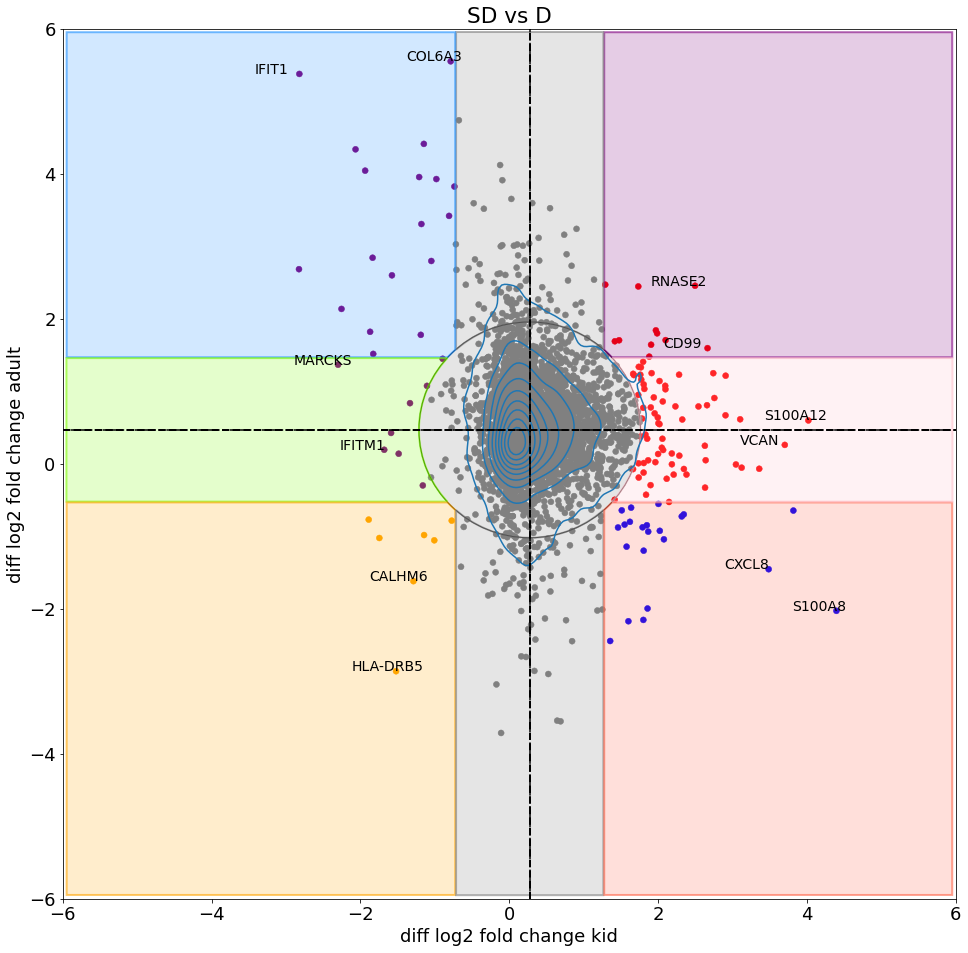

In [16]:
###### plot scatter_pairwise
scatter_pairwise(df, r, mark_list, name='scatter_pairwise_mono.png')

# The pie and stack bar plots showing percentages and the disease severity of patients detecting VHCs

In [193]:
########### dataframe for axs[0]
df = pd.DataFrame([], index=adata_kid[adata_kid.obs['Condition'] != 'Healthy'].obs['ID'].unique())
condition = []
DENV = []
for ID in df.index:
    adata_ID = adata_kid[adata_kid.obs['ID'] == ID]
    condition.append(adata_ID.obs['Condition'][0])
    
    if adata_ID.obs['DENV_reads'].sum() > 0:
        DENV.append('With DENV reads')
    else:
        DENV.append('No DENV reads')

df['condition'] = condition
df['DENV'] = DENV

########### dataframe for axs[1]
df_n = pd.DataFrame([])
fra = []
DENV = []
for cd in df['condition'].unique():
    df_cd = df[df['condition'] == cd]
    fra.append(int(df_cd[df_cd['DENV'] == 'With DENV reads'].shape[0] * 100 / df[df['DENV'] == 'With DENV reads'].shape[0]))
df_n['condition'] = df['condition'].unique().tolist()
df_n['DENV'] = fra

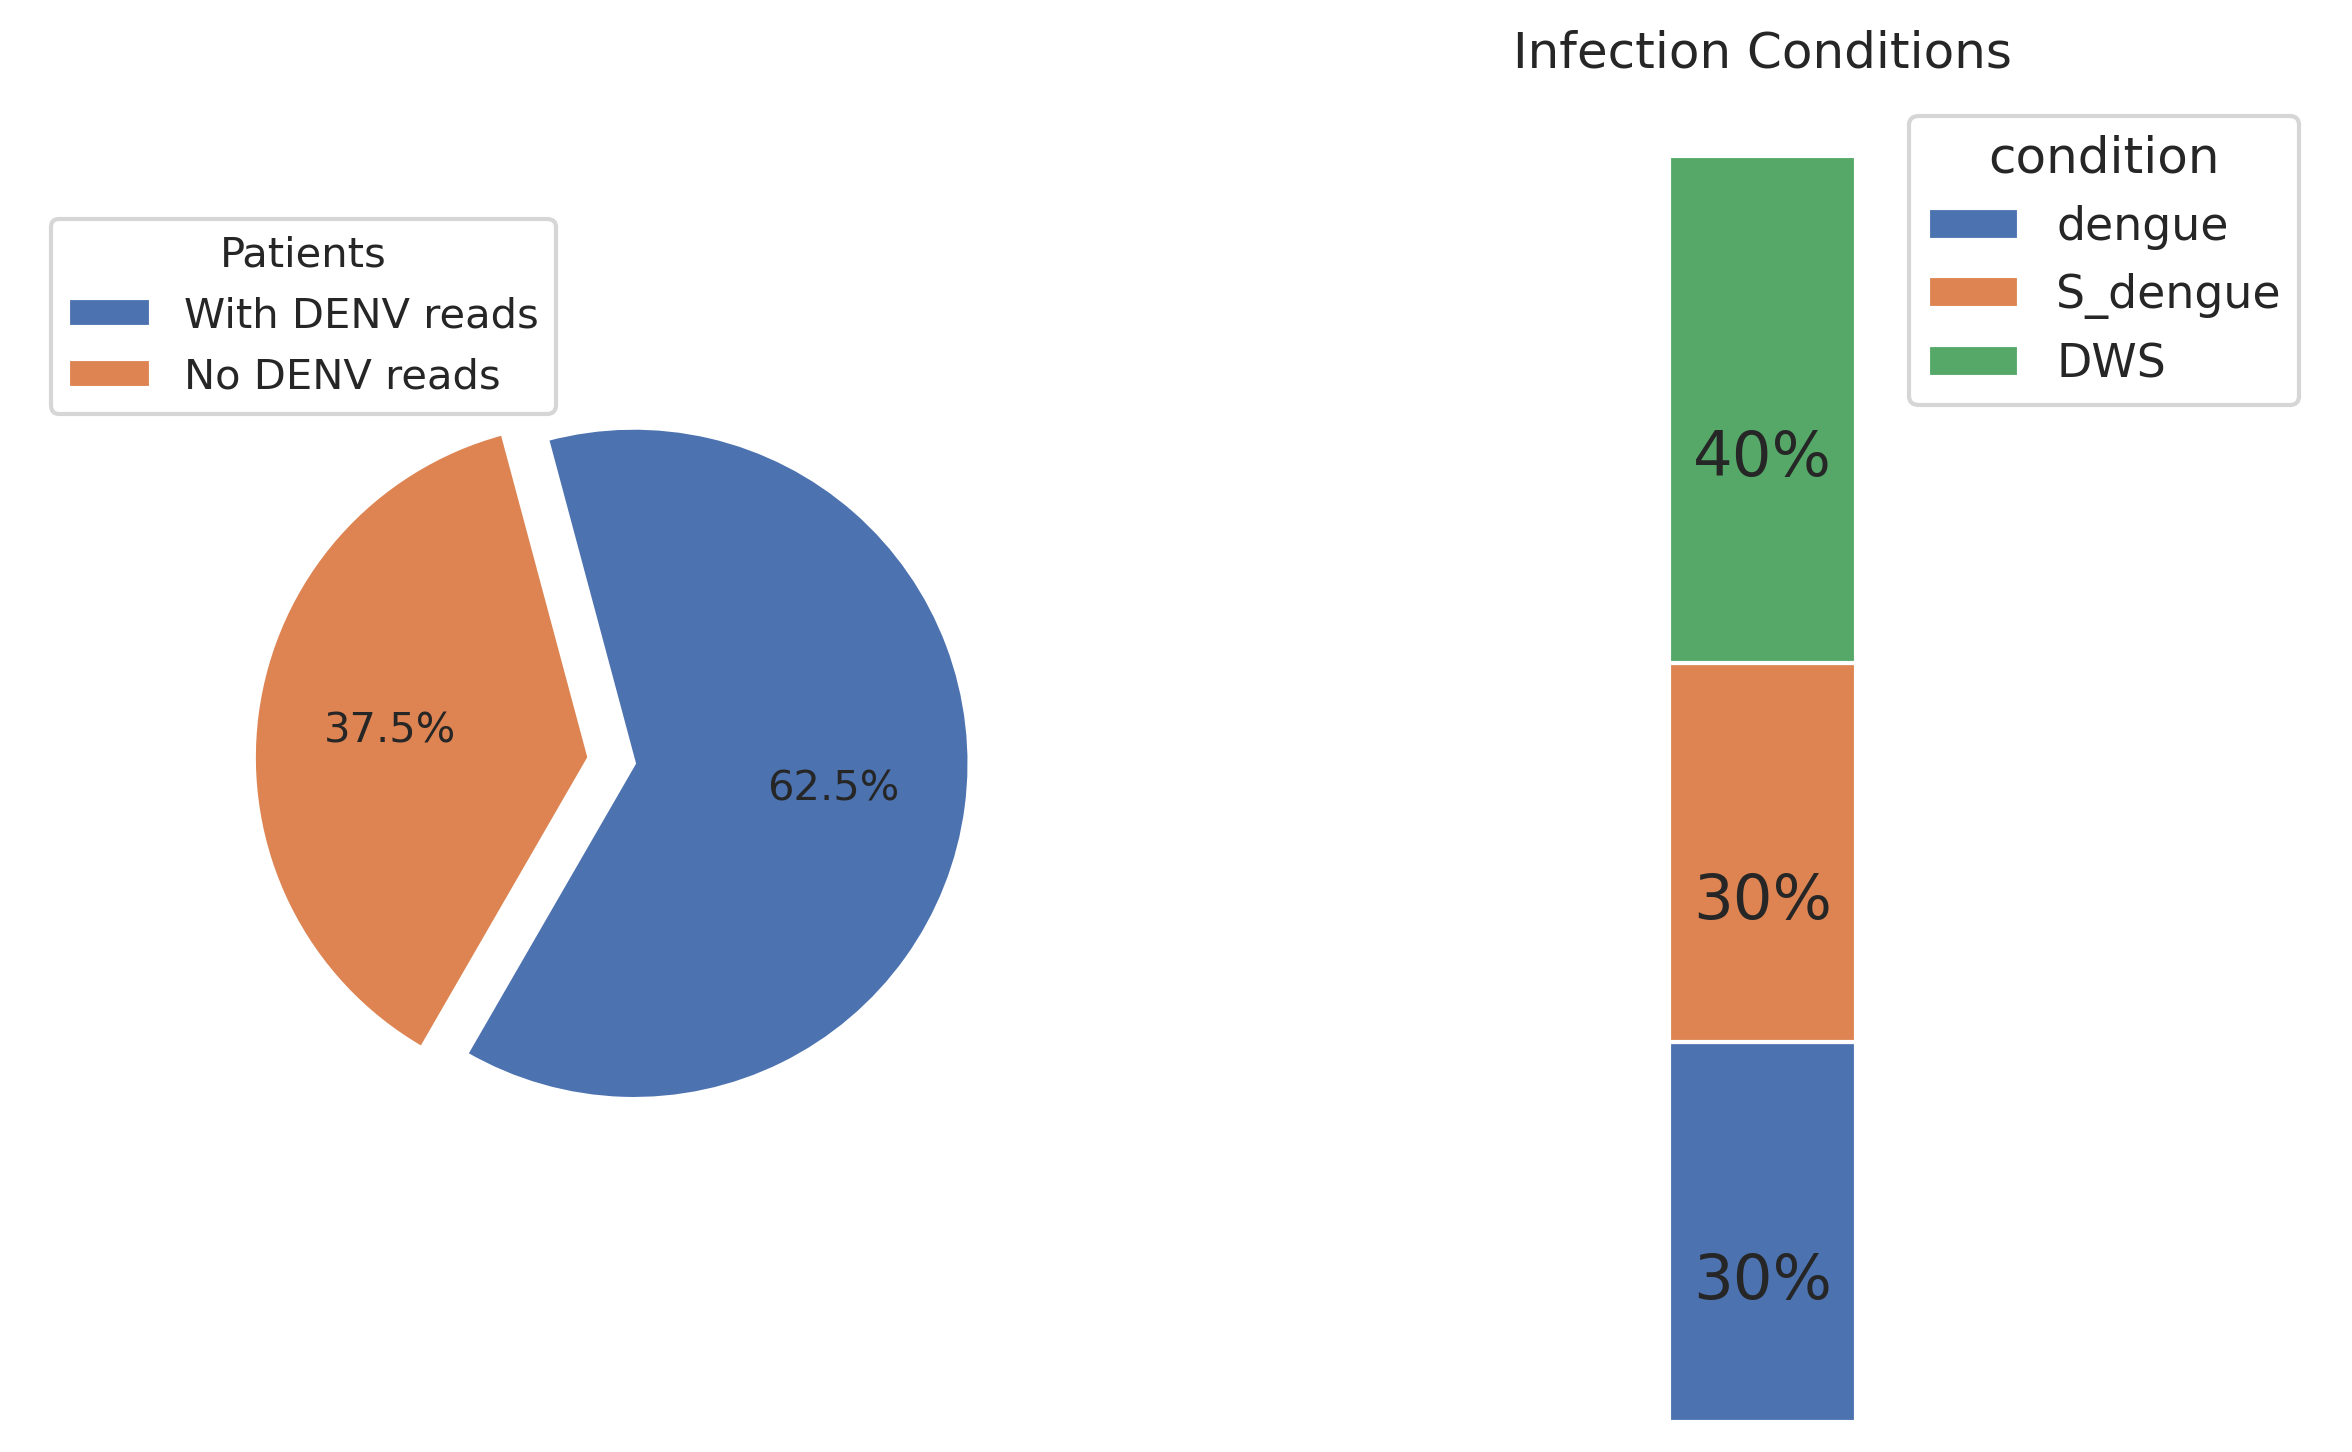

In [211]:
fig,axs = plt.subplots(1, 2, figsize=[8, 5], dpi=300)
per = df['DENV'].value_counts()
axs[0].pie(per, autopct='%1.1f%%', radius=0.75, explode=(0.1,0), textprops={'fontsize': 10}, startangle=240)
axs[0].legend(loc='upper left', title='Patients', labels=per.index, title_fontsize=10, fontsize=10)

df_n.set_index('condition').T.plot(kind='bar', stacked=True, width=0.1, ax=axs[1])
axs[1].set_axis_off()
axs[1].set_title('Infection Conditions')

height = 0
heights = [0]
for p, t in zip(axs[1].patches, df_n['DENV']):
    height += p.get_height()
    heights.append(height)
    axs[1].annotate(str(t) + '%', 
                   (p.get_x() + p.get_width() / 2., (heights[-1] + heights[-2]) / 2), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

# The stack bar plots showing the absolute VHCs numbers and the distribution of immune cell types in each patient captured VHCs

Text(0.5, 1.0, 'DENV harboring cells')

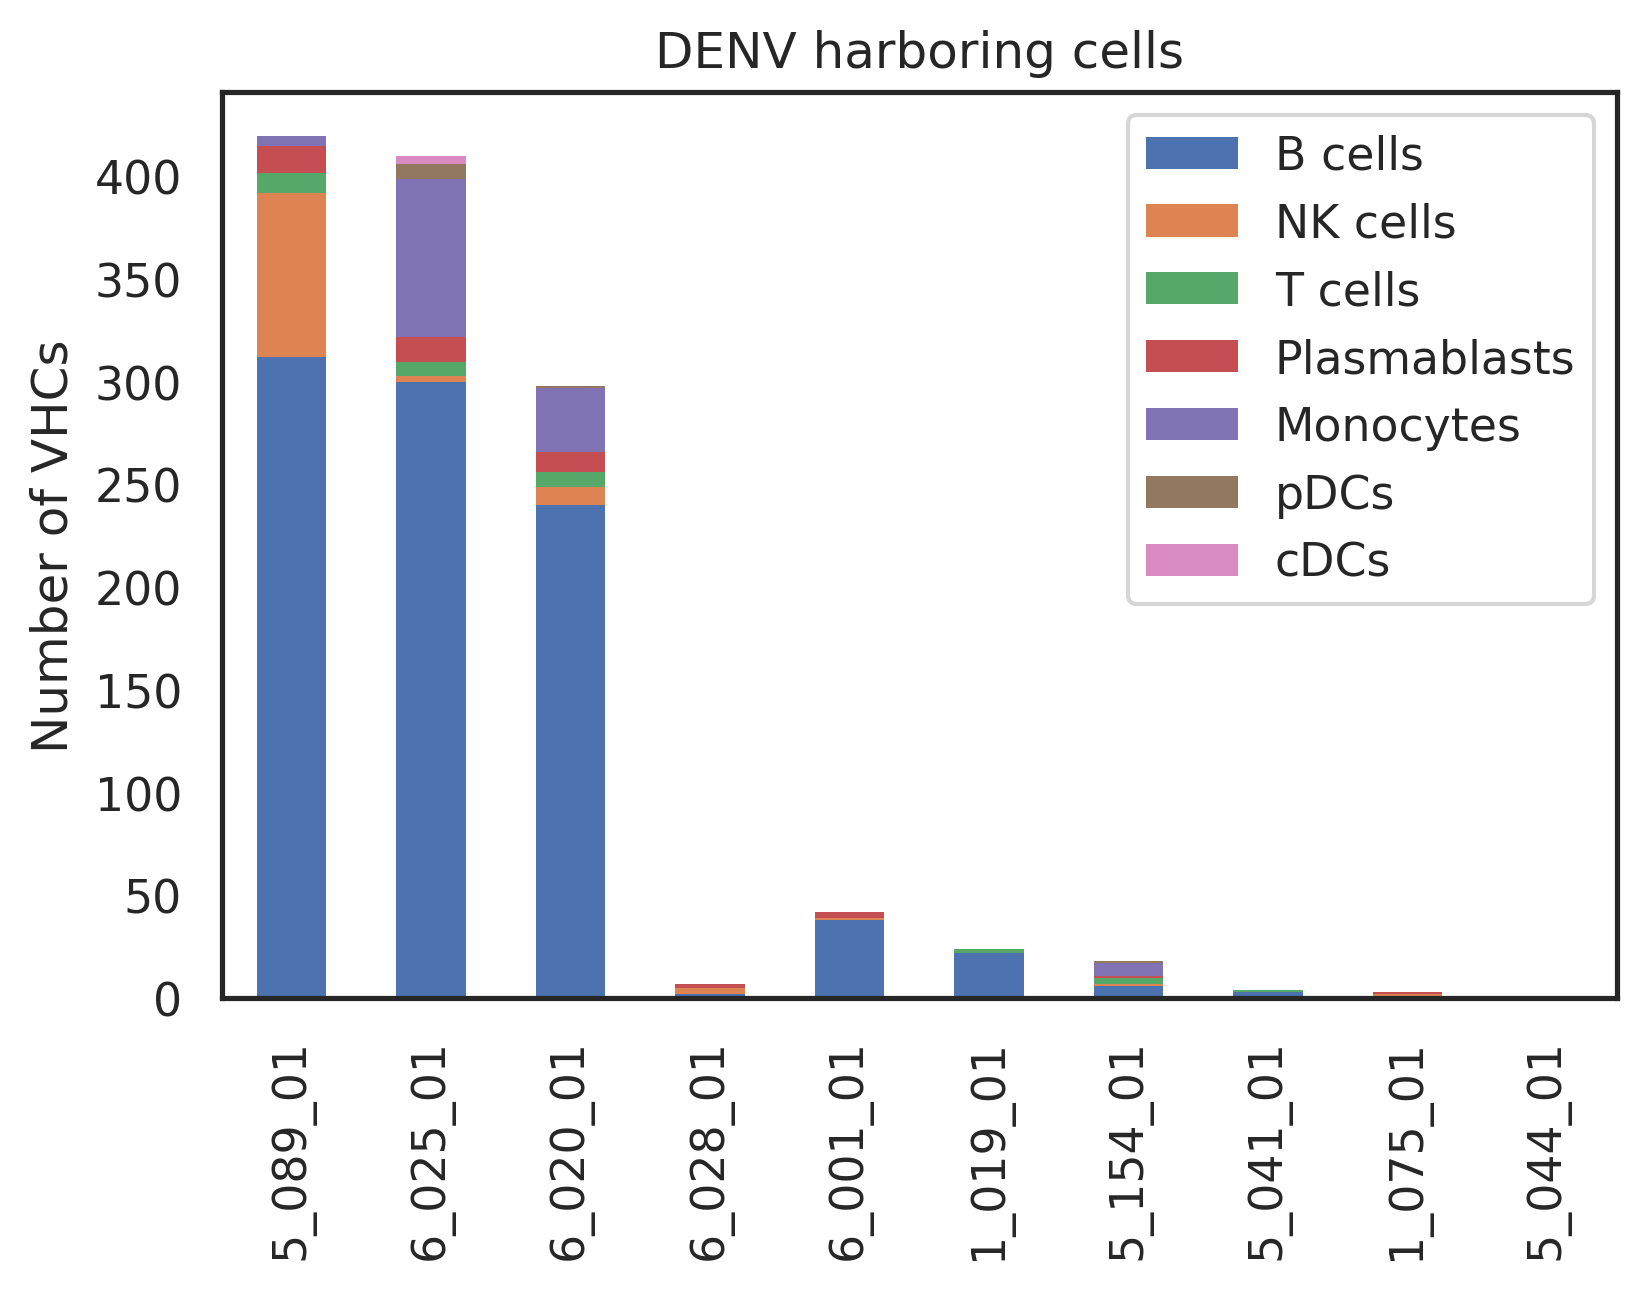

In [181]:
df = adata_kid[adata_kid.obs['Condition'] != "healthy"].obs.copy()
df.loc[df['DENV_reads'] > 0, 'DENV'] = 'yes'
df.loc[df['DENV_reads'] == 0, 'DENV'] = 'no'
a = df.groupby(['ID', 'cell_type', 'DENV']).size().unstack()
a.reset_index(inplace=True)

cts = ['B_cells', 'NK_cells', 'T_cells', 'Plasmablasts', 'Monocytes', 'pDCs', 'cDCs']
# a[a['yes'] != 0]['ID'].unique().tolist()
VHC_IDs = [
    '5_089_01',
    '6_025_01',
    '6_020_01',
    '6_028_01',
    
    '6_001_01',
    '1_019_01',
    '5_154_01',
    
    '5_041_01',
    '1_075_01',
    '5_044_01',]

df_VHCs = pd.DataFrame(np.zeros([len(cts), len(VHC_IDs)]), index=cts, columns=VHC_IDs)
for ct in cts:
    for ID in VHC_IDs:
        df_VHCs.at[ct, ID] = a.reset_index().set_index(['cell_type', 'ID']).loc[ct, ID]['yes']

fig, ax = plt.subplots(dpi=300)
sns.set_style('ticks')
df_VHCs.T.plot(kind='bar', stacked=True, ax=ax, edgecolor='none')
ax.set_ylabel('Number of VHCs')
handles, labels = ax.get_legend_handles_labels()
labels = [label.replace('_', ' ') for label in labels]
ax.legend(labels)
ax.set_title('DENV harboring cells')

# The bar plot showing the ratio of VHCs in each immune cell type of the top 3 patients with most VHCs.

In [254]:
df = adata_kid[adata_kid.obs['ID'].isin(['5_089_01', '6_025_01', '6_020_01',])].obs.copy()
df.loc[df['DENV_reads'] > 0, 'DENV'] = 'yes'
df.loc[df['DENV_reads'] == 0, 'DENV'] = 'no'
a = df.groupby(['cell_type', 'DENV']).size().unstack()
a.reset_index(inplace=True)
a['per %'] = (100 * a['yes'] / (a['yes'] + a['no'])).astype('int')

Text(0.5, 0, 'Percentage of cells with DENV RNA')

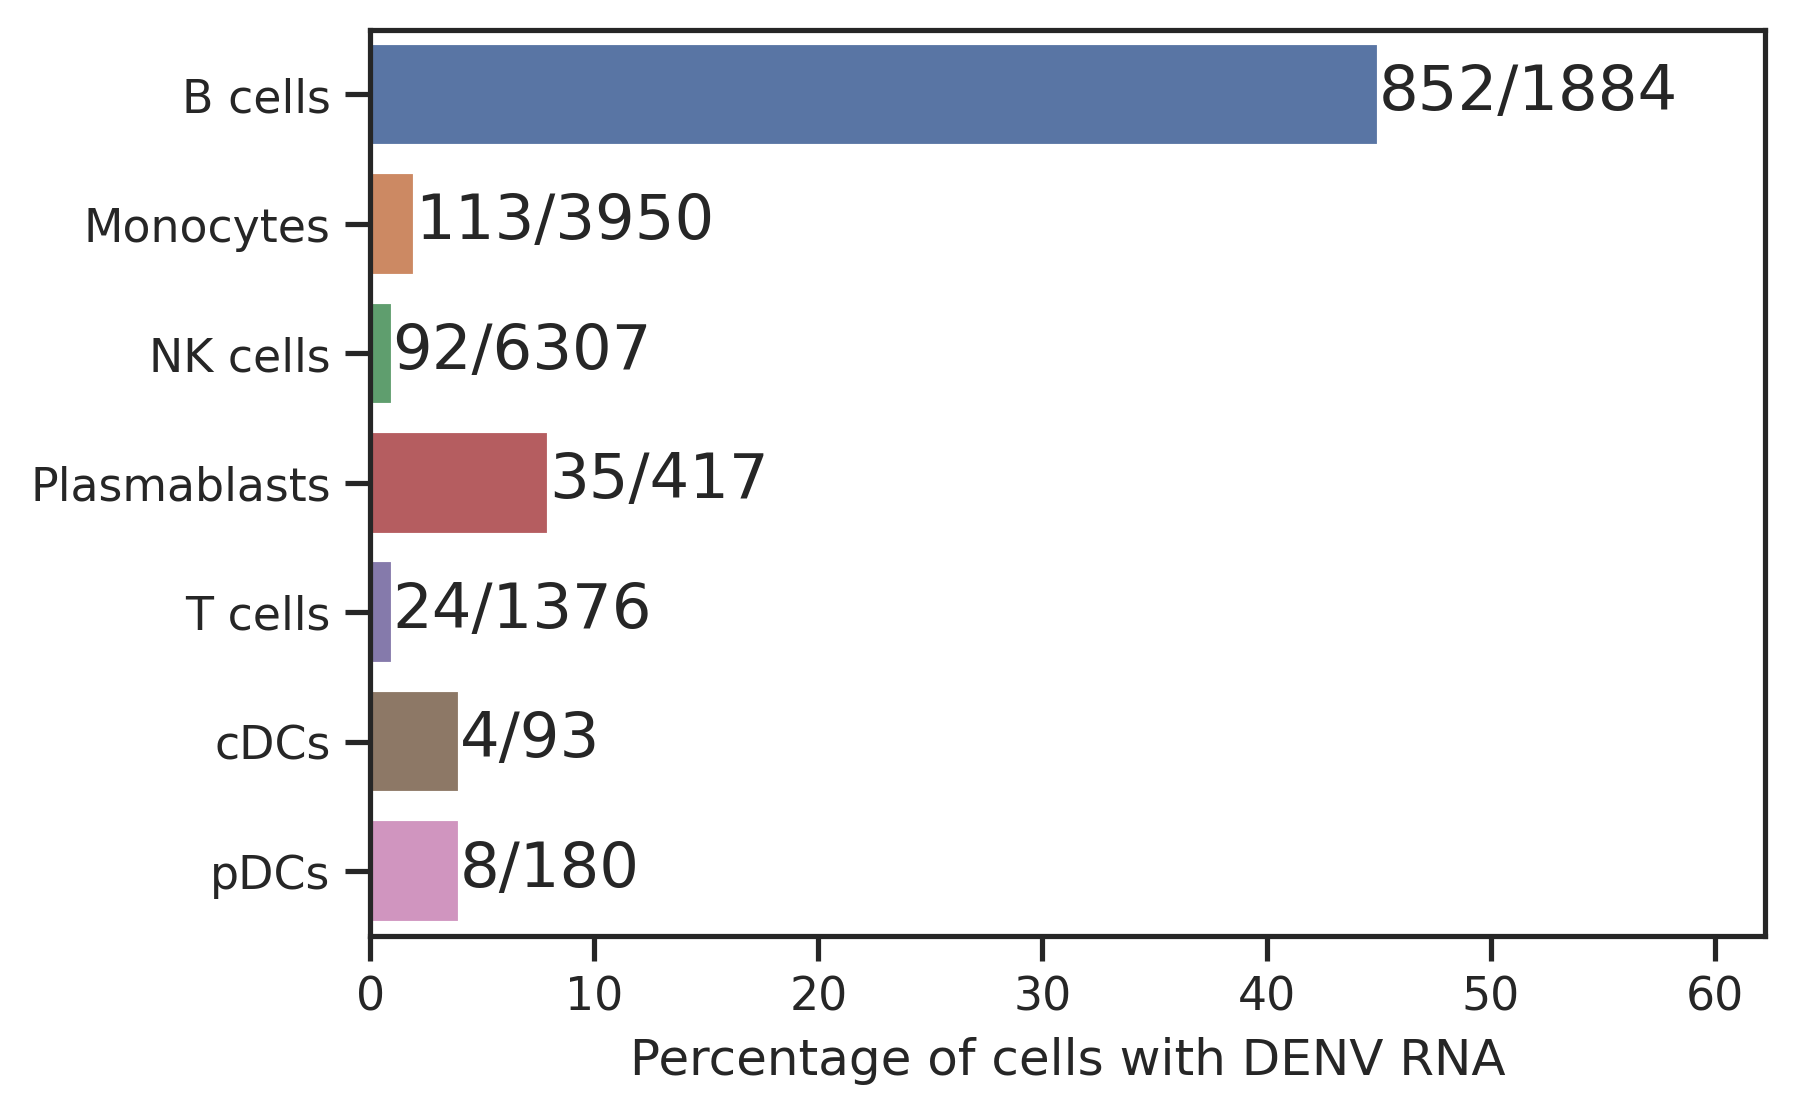

In [265]:
fig, ax = plt.subplots(dpi=300)
sns.barplot(data=a, y='cell_type', x='per %', orient='h', ax=ax)

for p, ct in zip(ax.patches, a['cell_type']):
    n = str(a.set_index('cell_type').loc[ct]['yes']) + '/' + str(a.set_index('cell_type').loc[ct]['yes'] + a.set_index('cell_type').loc[ct]['no'])
    ax.annotate(n, 
                   (p.get_width(), p.get_y(), ), 
                   ha = 'left', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.set_xlabel(None)
ax.set_ylabel(None)
labels = [label.get_text() for label in ax.get_yticklabels()]
labels = [label.replace('_', ' ') for label in labels]
ax.set_yticklabels(labels)
ax.set_xlim([0, ax.get_xlim()[1] + 15])
ax.set_xlabel('Percentage of cells with DENV RNA')

# The bar plot showing the negative / positive strands ratio of GAPDH, ACTB and DENV RNA reads

In [442]:
### this panel need bam file

<AxesSubplot:>

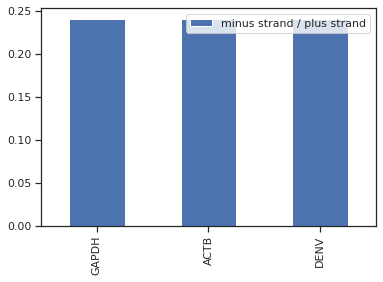

In [274]:
# df = pd.DataFrame([], index=['GAPDH', 'ACTB', 'DENV'], columns=['minus strand / plus strand'])

# GAPDH = adata_kid[:, 'GAPDH'][adata_kid[:, 'GAPDH'].obs['DENV_reads'] > 0]
# ACTB = adata_kid[:, 'ACTB'][adata_kid[:, 'ACTB'].obs['DENV_reads'] > 0]
# DENV = adata_kid[adata_kid.obs['DENV_reads'] > 0]

# col = []
# for ad in [GAPDH, ACTB, DENV]:
#     col.append((ad.obs['DENV_minus'] > 0).sum() / (ad.obs['DENV_plus'] > 0).sum())

# df['minus strand / plus strand'] = col

# df.plot(kind='bar')

# The box plots showing top representative DEGs between VHCs and bystanders in B cells, Monocytes and NK cells

DEGs were identified by the median log2 fold change out of 100 comparisons between equal numbers of VHCs and the corresponding bystanders

In [473]:
def pair_comparison_DENV(adata, cell_types, gene_cut_off, cell_cut_off, log1p=False):    
    import random
    ress = pd.DataFrame([])
    log2FC = pd.DataFrame([])
    
    cds = ['dengue', 'S_dengue']
    p_ID = 'ID'
    
    for cell_type in cell_types:
        ct_obs = 'cell_subtype_2'
        if cell_type in adata.obs['cell_type'].unique():
            ct_obs = 'cell_type'
            
        adata_ct = adata[adata.obs[ct_obs] == cell_type]
        
        ####### filter out genes expressed less than gene_cut_off in all patients
        IDs = list(adata_ct.obs['ID'].unique())
        fra = [np.asarray((adata_ct[adata_ct.obs['ID'] == ID].X > 0).mean(axis=0))[0] for ID in IDs]
        fra=pd.DataFrame(fra, index=IDs, columns=adata_ct.var_names).T
        gene_list = fra.index.tolist()
        
        if gene_cut_off is not False:
            for idx, row in fra.iterrows():
                n = 0
                for i in row.tolist():
                    if i <= gene_cut_off:
                        n += 1
                if n == len(IDs):
                    gene_list.remove(idx)
        
        adata_ct = adata_ct[:, gene_list]
        
        ####### filter out patient with less than 5 cells for the cell type
        if ct_obs == 'cell_type':
            ct = cell_type
        elif ct_obs == 'cell_subtype_2':
            ct = adata_ct.obs['cell_type'].unique()[0]
        
        for ID in IDs:
            if adata[(adata.obs['cell_type'] == ct) & (adata.obs[p_ID] == ID)].obs.shape[0] < cell_cut_off:
                IDs.remove(ID)
        adata_ct = adata_ct[adata_ct.obs[p_ID].isin(IDs)]

        ####### pair comparison
        adata_S_ct = adata_ct[adata_ct.obs['DENV_reads'] > 0]
        adata_NS_ct = adata_ct[adata_ct.obs['DENV_reads'] == 0]
        
        S_cells = adata_S_ct.obs_names
        NS_cells = adata_NS_ct.obs_names
        
        log2_fc = []
        for i in range(100):
            if len(S_cells) > len(NS_cells):
                S_n = random.sample(range(len(adata_S_ct.obs_names)), len(adata_NS_ct.obs_names))
                S_c = [adata_S_ct.obs_names[i] for i in S_n]
                adata_Si = adata_S_ct[S_c, :]
                adata_NSi = adata_NS_ct.copy()
                
            elif len(S_cells) < len(NS_cells):
                NS_n = random.sample(range(len(adata_NS_ct.obs_names)), len(adata_S_ct.obs_names))
                NS_c = [adata_NS_ct.obs_names[i] for i in NS_n]
                adata_NSi = adata_NS_ct[NS_c, :]
                adata_Si = adata_S_ct.copy()

            X_S = adata_Si.X
            X_NS = adata_NSi.X
            avg_S = np.asarray(X_S.mean(axis=0))[0]
            avg_NS = np.asarray(X_NS.mean(axis=0))[0]

            if log1p is False:
                log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))
            elif log1p not in (True, 2):
                log2_fc.append((avg_S - avg_NS) / np.log2(log1p))
            else:
                log2_fc.append(avg_S - avg_NS)

        log2_fc = np.asarray(log2_fc)
        
        if log2_fc.size == 0:
            continue
        med_pair = np.median(log2_fc, axis=0)
        fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

        res = pd.DataFrame([], index=adata_ct.var_names)
        res['med_pair'] = med_pair
        res['fra_pair'] = fra_pair
        res['cell_subtype'] = cell_type
        ress = pd.concat([ress, res], join='outer')
        ress['gene'] = ress.index.tolist()

        FCs = pd.DataFrame(log2_fc, columns = adata_ct.var_names, index=[cell_type] * log2_fc.shape[0])
        log2FC = pd.concat([log2FC, FCs], join='outer')
        
    return {'pair_res': ress, 'log_FCs': log2FC}

In [474]:
data = pair_comparison_DENV(adata_kid, ['Monocytes', 'B_cells', 'NK_cells', 'T_cells', 'Plasmablasts'], gene_cut_off=0.1, cell_cut_off=5, log1p=2)

data['pair_res'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/DENV_pair.tsv', sep='\t', index=False)
data['log_FCs'].to_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/DENV_log2FC.tsv', sep='\t')

In [475]:
pair_DENV = pd.read_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/DENV_pair.tsv', sep='\t', index_col='cell_subtype')
log2fc_DENV = pd.read_csv('/home/yike/phd/dengue/figures/paper_figure/all_figures/DENV_log2FC.tsv', sep='\t', index_col=0)

In [438]:
up_mono = pair_DENV .loc['Monocytes'].sort_values('med_pair', ascending=False).head(10)['gene'].tolist()
down_mono = pair_DENV .loc['Monocytes'].sort_values('med_pair', ascending=False).tail(10)['gene'].tolist()

In [476]:
up_B = pair_DENV .loc['B_cells'].sort_values('med_pair', ascending=False).head(10)['gene'].tolist()
down_B = pair_DENV .loc['B_cells'].sort_values('med_pair', ascending=False).tail(10)['gene'].tolist()

<ipython-input-298-fa26da97780a>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]


{'figure': <Figure size 1800x1200 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Upregulated genes in the SD group'}, xlabel='diff log2 fold change'>}

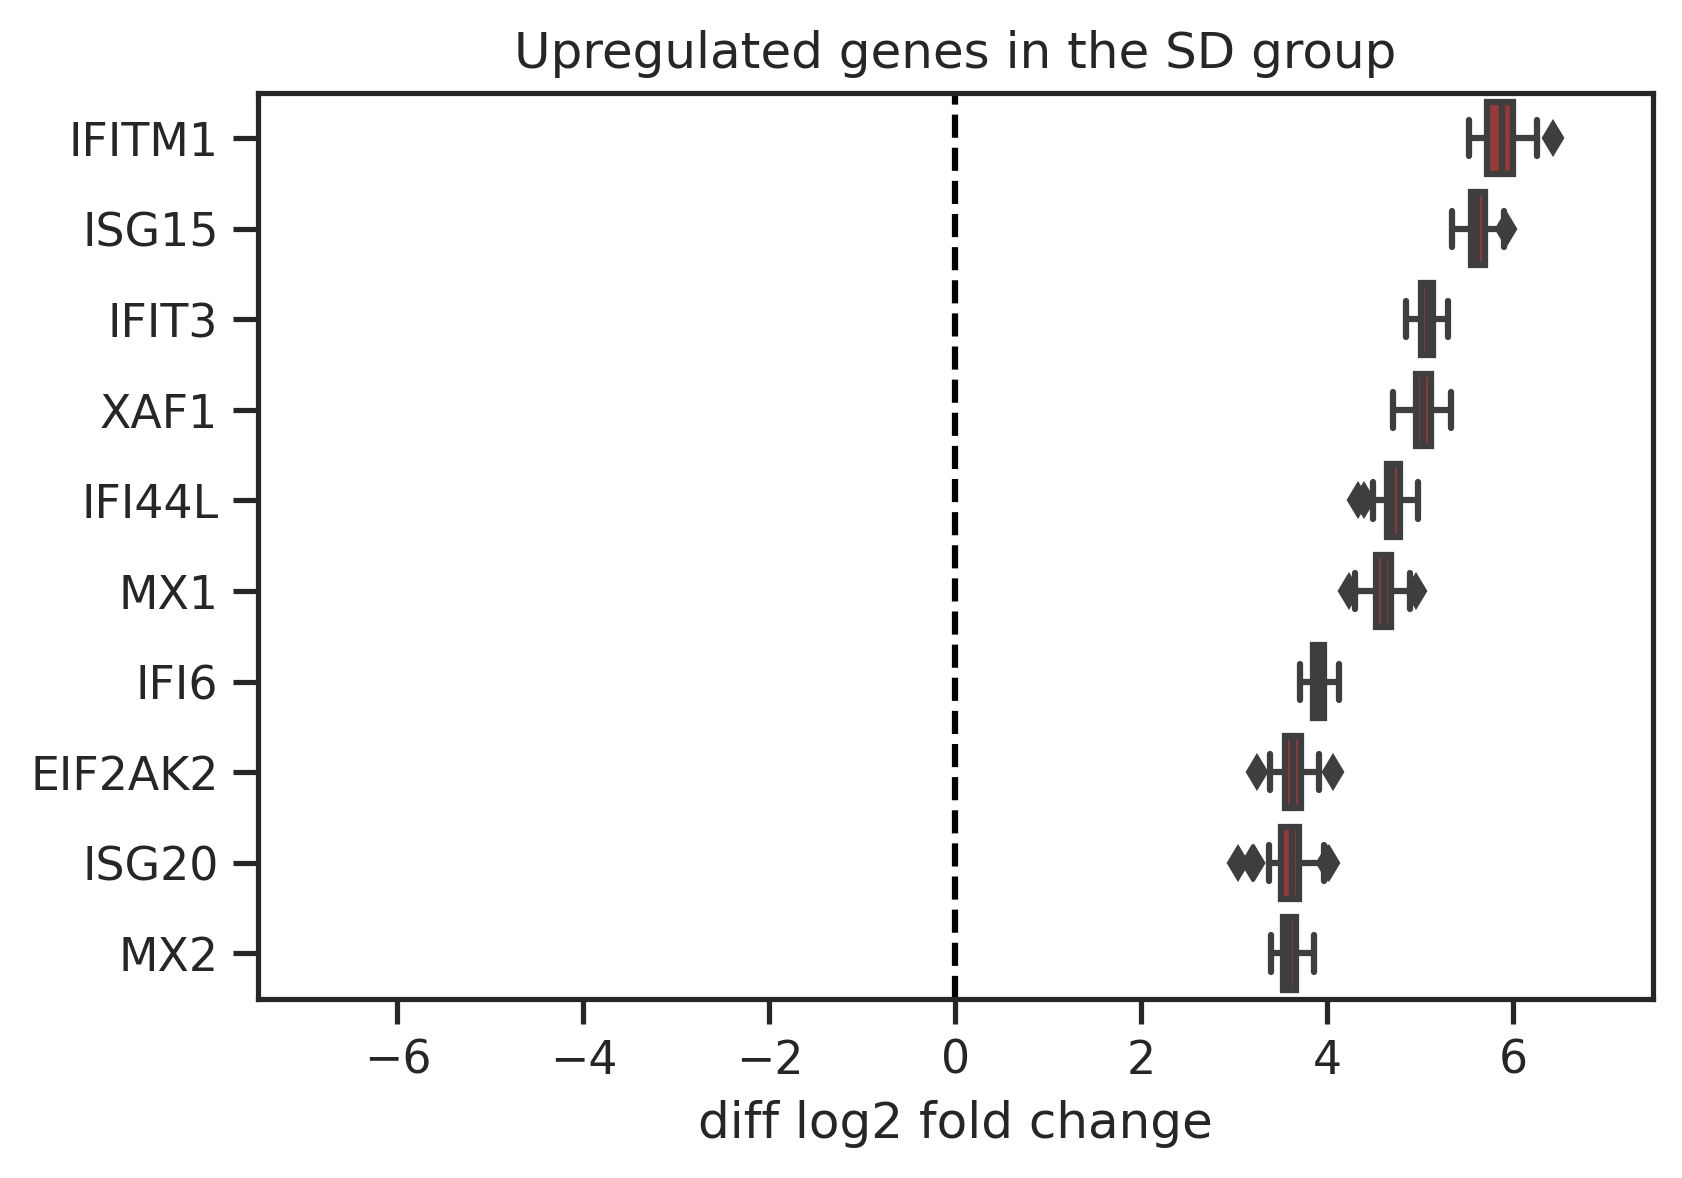

In [477]:
pairwise_boxplot(log2fc_DENV.loc['B_cells'], up_B, 'Upregulated genes in the SD group', path=False)

<ipython-input-298-fa26da97780a>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [['Brown', 'CornflowerBlue'][median < 0] for median in medians]


{'figure': <Figure size 1800x1200 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Upregulated genes in the SD group'}, xlabel='diff log2 fold change'>}

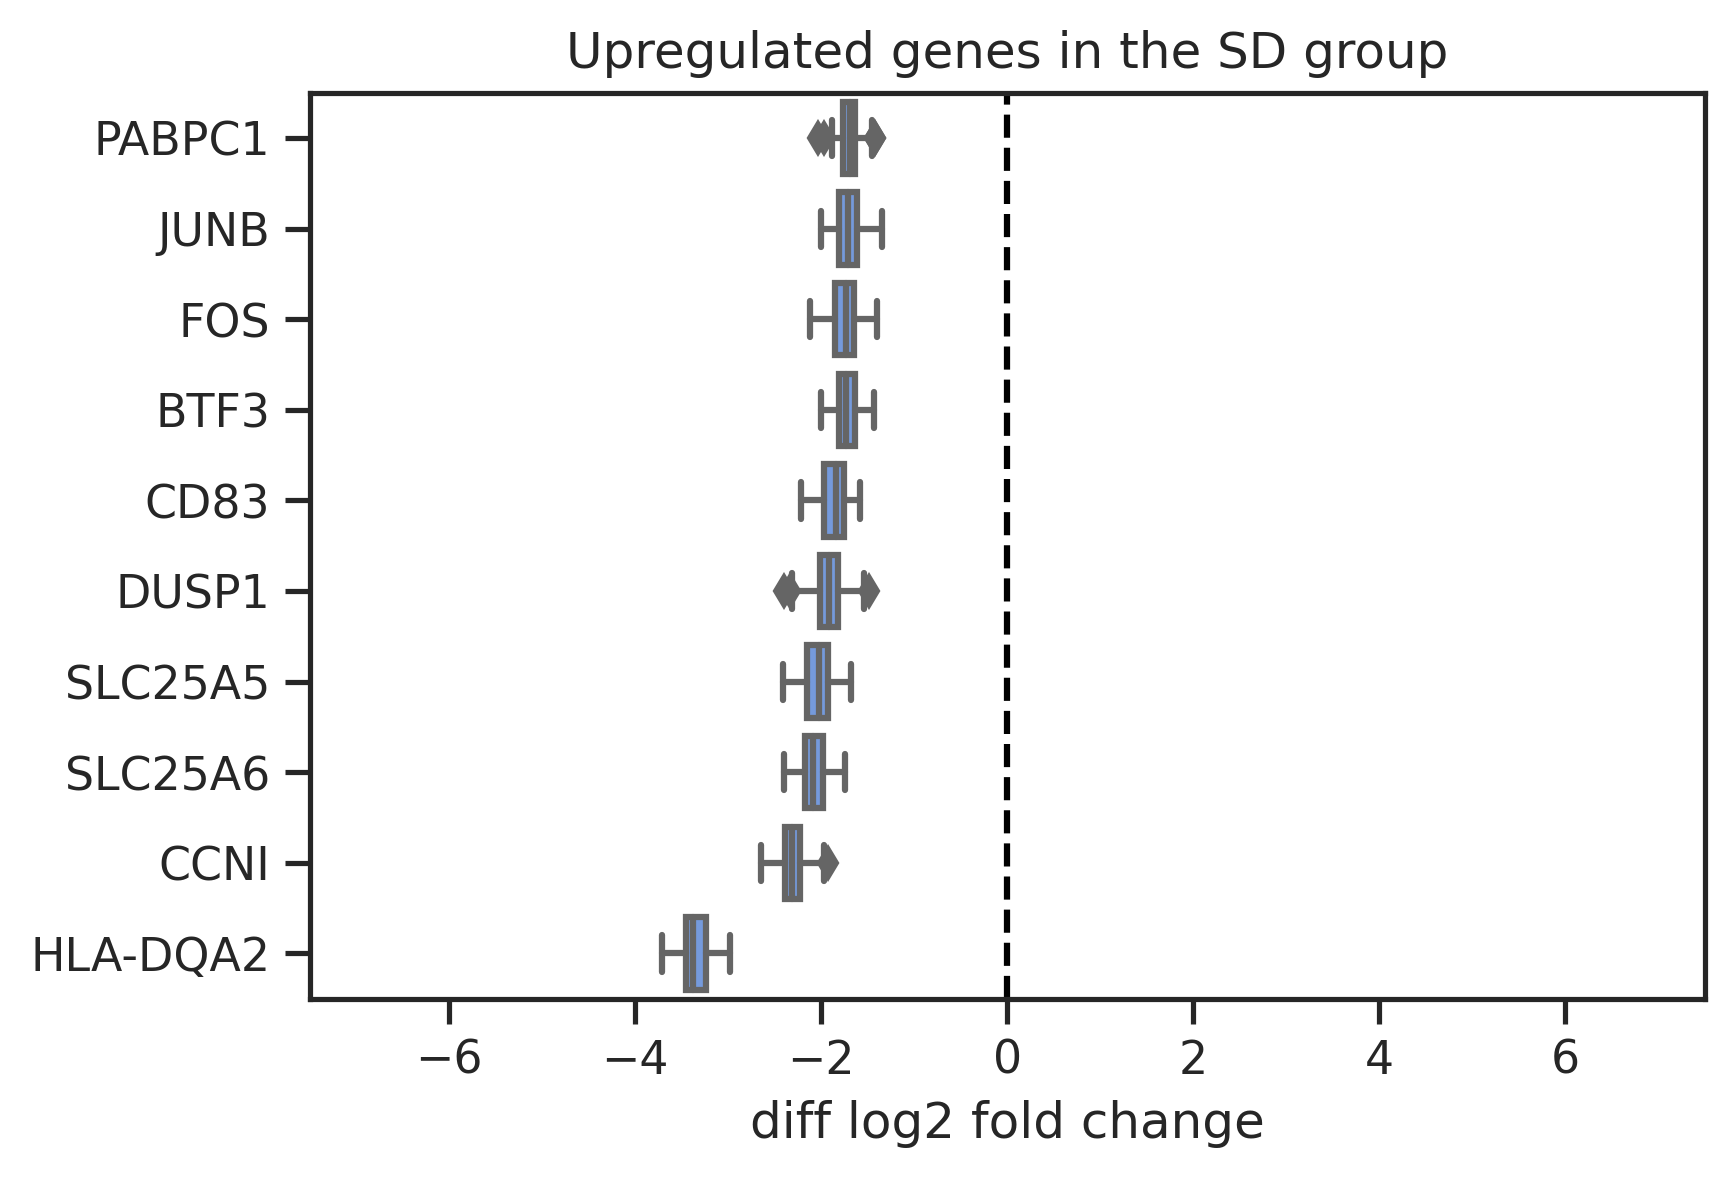

In [478]:
pairwise_boxplot(log2fc_DENV.loc['B_cells'], down_B, 'Upregulated genes in the SD group', path=False)